# The $\mathbb{Z}_N$-axion model with a Reheaton-Higgs Portal

## 0. Preamble

Can't start without these.

### 0.1 Loading Packages and Settings

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from math import pi

from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, brentq, fsolve, least_squares
from scipy.integrate import quad, simpson, solve_ivp
from scipy.special import zeta
from scipy.sparse import csr_matrix
from scipy.ndimage import gaussian_filter1d

import warnings as warn

import emcee

from tqdm import tqdm

In [2]:
# aesthetic definitions for the plots

# plt.rcParams['font.family'] = 'Times New Roman'
# plt.rcParams['mathtext.fontset'] = 'stix'#['dejavusans', 'dejavuserif', 'cm', 'stix', 'stixsans', 'custom']
# font = {'family': 'Times New Roman',
#         #'color':  'black',
#         'weight': 'normal',
#         'size': 14,
        # }

# font = {'size'   : 16, 'family':'STIXGeneral'}
# axislabelfontsize='large'
# matplotlib.rc('font', **font)
# matplotlib.mathtext.rcParams['legend.fontsize']='medium'
# plt.rcParams["figure.figsize"] = [8.0,6.0]

# %config InlineBackend.figure_format = "retina"
# plt.rcParams['figure.figsize'] = (13, 8)
# plt.rcParams['font.family'] = 'STIXGeneral'
# matplotlib.mathtext.rcParams['legend.fontsize']='medium'
# plt.rcParams['font.serif'] = ['New Times Roman']
# # plt.rc('text', usetex=True)

### 0.2 Definitions, Constants, and Parameters

Path to data:

In [3]:
path_to_data = './data/'

Natural Units:

In [4]:
eV = 1.e-9
keV = 1.e-6
MeV = 1.e-3
GeV = 1.
TeV = 1.e3

SI Units (and others):

In [5]:
Kelvin = (8.61734231196981e-5)*eV
sec = (1.519268e21)/MeV
yr = (3.15576e7)*sec
gr = (5.609589e23)*GeV
mtr = (5.067731e15)/GeV
km = 1000*mtr
cm = 0.01*mtr
Mpc = (3.08567758128e19)*km

Useful cosmological parameters and constants:

In [6]:
Mpl = (1.22091e19) * GeV
mpl = Mpl/np.sqrt(8.*pi)
MGUT = 1.e15 * GeV

In [7]:
h = 0.6766
rho_crit = 3.* mpl**2 * (100.*h * km/sec / Mpc)**2
H0 = np.sqrt(rho_crit / (3. * mpl**2))

In [8]:
T_g0 = 2.7255*Kelvin
# gs0 = 3.94
gs0 = 3.909 # arXiv:1609.04979, Table 2
# ge0 = 3.38
ge0 = 3.363 # arXiv:1609.04979, Table 2
ge_1nu = 2.*(7./8.)*(4./11.)**(4./3.)
gSM = 106.75

ncoeff = zeta(3.)/(pi**2)
ffn = 3./4.

rho_coeff = (pi**2.)/ 30.
ffrho = 7./8.

scoeff = 2.*pi**2 / 45.
ffs = ffrho

s0tot = gs0*scoeff*T_g0**3.
nsRatio = ncoeff/scoeff

In [9]:
Omega_b = 0.02242/h**2
Omega_dm = 0.11933/h**2
Omega_m = Omega_b + Omega_dm

sig_omega_dm = 0.00091

Useful particle physics constants and parameters:

In [10]:
vEW = 246.*GeV
mh = 125.25*GeV
mZ = 91.19*GeV
mW = 80.377*GeV

mu, md, ms, mc, mb, mt = 2.16*MeV, 4.67*MeV, 93.4*MeV, 1.27*GeV, 4.18*GeV, 172.69*GeV

mp = 938.2720813*MeV
mn = 939.5654133*MeV
mpi = 134.9768*MeV
fpi = 92.*MeV
me = 0.51099895*MeV

zud = mu/md
zp = zud/(1 + zud)**2

Tcrit = 150.*MeV

alpha_em = 0.00729735253

## 1. Important Cosmological Functions

The building blocks of time evoltion in cosmology.

### 1.1 $\rho_{\rm rad}(g_{*e}, T)$, and $H(\rho)$

In [11]:
def rho_rad(gse, Temp):
    """
    rho_rad : radiation energy density [GeV^4].

    Parameters:
    gse : relativistic d.o.f. in entropy
    Temp : temperature [GeV]

    Returns:
    rho_rad [GeV^4]
    """

    return rho_coeff * gse * Temp**4

def Hubble(rho):
    """
    Hubble : Hubble expansion rate [GeV].

    Parameters:
    rho : energy density [GeV^4]

    Returns:
    Hubble [GeV]
    """

    return np.sqrt( rho/ (3. * mpl**2.))

### 1.2 $g_{*s}(T)$

Obtaining $\ g_{*s}(T \text{ [GeV]})$ table from data file:

In [12]:
# gs_data = np.genfromtxt('./data/entropy_dof_old.csv', delimiter=',')
gs_data = np.genfromtxt(path_to_data+'entropy_dof.csv', delimiter=',')[::-1]
gs_data

array([[1.00000000e-05, 3.90900000e+00],
       [1.97918150e-05, 3.90900000e+00],
       [3.44144802e-05, 3.90900000e+00],
       [5.25734858e-05, 3.92236845e+00],
       [6.65278050e-05, 4.04065353e+00],
       [9.35935685e-05, 4.57767716e+00],
       [1.30129870e-04, 5.66954735e+00],
       [1.83071107e-04, 7.10579875e+00],
       [2.69966517e-04, 8.59396436e+00],
       [4.32297524e-04, 9.73614643e+00],
       [7.17118711e-04, 1.03322177e+01],
       [1.23235214e-03, 1.05807421e+01],
       [2.27273877e-03, 1.06438017e+01],
       [3.90564972e-03, 1.07072371e+01],
       [6.87164481e-03, 1.07072371e+01],
       [1.18087648e-02, 1.07072371e+01],
       [2.05333620e-02, 1.12285216e+01],
       [3.36632893e-02, 1.27208499e+01],
       [5.45432754e-02, 1.45838090e+01],
       [8.73401749e-02, 1.66205412e+01],
       [1.27289427e-01, 2.03416931e+01],
       [1.50092098e-01, 2.46018486e+01],
       [1.70839330e-01, 3.01099253e+01],
       [1.79075076e-01, 3.35089863e+01],
       [1.967567

Taking the $\log_{10}$ of the x-axis (i.e., the temperature):

In [13]:
gs_Lxydata = np.array([np.log10(gs_data[:,0]), gs_data[:,1]]).transpose()
gs_Lxydata

array([[-5.00000000e+00,  3.90900000e+00],
       [-4.70351438e+00,  3.90900000e+00],
       [-4.46325879e+00,  3.90900000e+00],
       [-4.27923323e+00,  3.92236845e+00],
       [-4.17699681e+00,  4.04065353e+00],
       [-4.02875399e+00,  4.57767716e+00],
       [-3.88562300e+00,  5.66954735e+00],
       [-3.73738019e+00,  7.10579875e+00],
       [-3.56869010e+00,  8.59396436e+00],
       [-3.36421725e+00,  9.73614643e+00],
       [-3.14440895e+00,  1.03322177e+01],
       [-2.90926518e+00,  1.05807421e+01],
       [-2.64345048e+00,  1.06438017e+01],
       [-2.40830671e+00,  1.07072371e+01],
       [-2.16293930e+00,  1.07072371e+01],
       [-1.92779553e+00,  1.07072371e+01],
       [-1.68753994e+00,  1.12285216e+01],
       [-1.47284345e+00,  1.27208499e+01],
       [-1.26325879e+00,  1.45838090e+01],
       [-1.05878594e+00,  1.66205412e+01],
       [-8.95207668e-01,  2.03416931e+01],
       [-8.23642173e-01,  2.46018486e+01],
       [-7.67412141e-01,  3.01099253e+01],
       [-7.

Interpolating the resulting grid:

In [14]:
gs_fnLxy = interp1d(gs_Lxydata[:,0], gs_Lxydata[:,1], bounds_error=False)

Finally, defining the function $g_{*s}(T \, \text{[GeV]})$ for any temperature:

In [15]:
def gs_fn(Temp):
    """
    gs_fn : function giving the relativistic d.o.f. in entropy.
    
    Parameters:
    Temp : temperature [GeV]

    Returns:
    gs_fn
    """

    Tarr = np.asarray(Temp)

    result = np.where(Tarr <= gs_data[0,0],
                      gs0,
                      np.where(Tarr <= gs_data[-1,0],
                               gs_fnLxy(np.log10(Tarr)),
                               gSM
                              )
                     )
    
    if np.isscalar(Temp):
        return result.item()
    else:
        return result

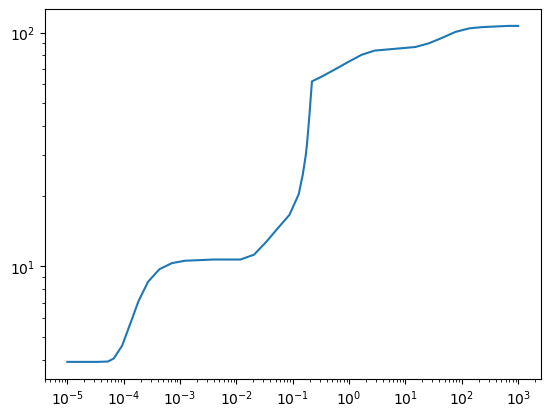

In [16]:
plt.loglog(gs_data[:,0], gs_data[:,1])

### 1.3 Useful derivatives

Defining $\frac{d \ln g_{*s}}{d \ln T}$:

In [17]:
Thi = 100.*TeV

# Temp_arr = np.logspace(np.log10(T_g0), np.log10(Thi), 10001)
Temp_arr = np.logspace(np.log10(keV), np.log10(Thi), 50001)
gs_arr = np.vectorize(gs_fn)(Temp_arr)

dLgdLT_arr = np.gradient(np.log(gs_arr), np.log(Temp_arr))

In [18]:
def smooth(data, window_size):
    """
    A smoothing function for noisy data.

    Parameters:
    data : An array of data.
    window_size : the size of the smoothing window (int)
    """
    box = np.ones(window_size) / window_size
    smoothed_data = np.convolve(data, box, mode='same')
    
    return smoothed_data

From entropy conservation ($S = g_{*s} T^3 a^3 = \text{const.}$) we get:

$\frac{d \ln a}{d \ln T} = -1 - \frac{1}{3} \frac{d \ln g_{*s}}{d \ln T}$

In [19]:
dLadLT_arr = -1. - (1./3.)*dLgdLT_arr # original data

smooth_dLadLT_arr = gaussian_filter1d(dLadLT_arr, 300, mode='nearest') # smoothing the data!

# derivative function

# from original data
# dLadLT_fn = interp1d(np.log(Temp_arr), dLadLT_arr, bounds_error=False) # NOTE: the argument is lnT (not log10T), and the result is lna (not log10a)

# from smoothed data
dLadLT_fn = interp1d(np.log(Temp_arr), smooth_dLadLT_arr, bounds_error=False) # NOTE: the argument is lnT (not log10T), and the result is lna (not log10a)

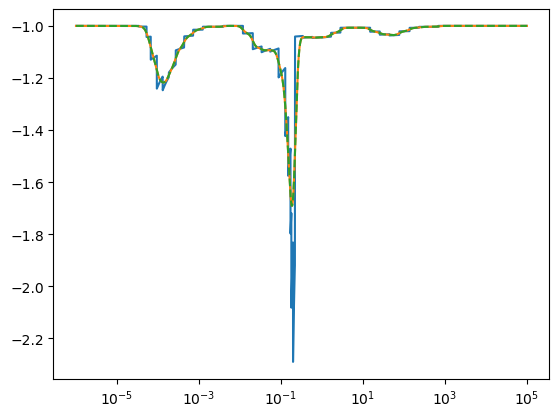

In [20]:
plt.plot(Temp_arr, dLadLT_arr)
plt.plot(Temp_arr, smooth_dLadLT_arr)
plt.plot(Temp_arr, dLadLT_fn(np.log(Temp_arr)), ls='--')
plt.xscale('log')
# plt.ylim(-1.7,-1);
# plt.xlim(1.e-4, 1.01e-4)

(0.6, 1.4)

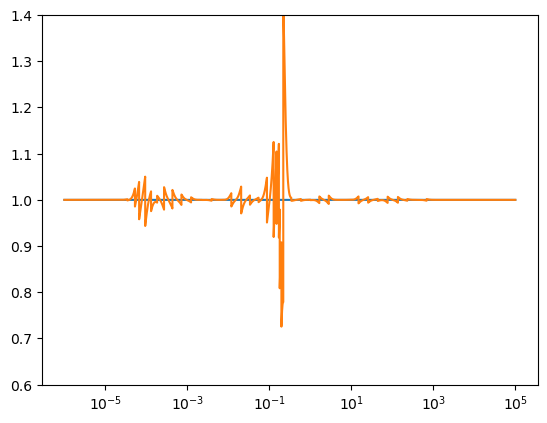

In [21]:
plt.plot(Temp_arr, np.ones_like(dLadLT_arr))
plt.plot(Temp_arr, smooth_dLadLT_arr/dLadLT_arr)

plt.xscale('log')
plt.ylim(0.6, 1.4)

### 1.4 $t(T)$

Find the time as a function of the temperature: $\Delta t \equiv t - t_i = \int\limits_{\ln a_i}^{\ln a} \, d \ln a \, \frac{1}{H(T)} = \int\limits_{\ln T_i}^{\ln T} \, d \ln T \, \frac{d \ln a}{d \ln T} \frac{1}{H(T)}$

In [22]:
def time_int_fn(Tini, Tend, **kwargs):
    """
    time_int_fn : age of the Universe [GeV^-1] and its absolute error for a given temperature, starting from a very high temperature.

    Parameters:
    Temp : temperature [GeV]
    Tini : initial (high) temperature [GeV]
    Tend : final (low) temperature [GeV]

    Returns:
    (time [GeV^-1], abs_error(time) [GeV^-1])
    """

    def Hubble_rate(lnT): return Hubble(rho_rad(gs_fn(np.power(np.e, lnT)), np.power(np.e, lnT))) # Hubble expansion rate [GeV] as a function of ln(T)

    def integrand(lnT): return dLadLT_fn(lnT) / (Hubble_rate(lnT) * (GeV*sec)) # integrand [sec] as a function of ln(T)

    res, error = quad(lambda lnT: integrand(lnT), np.log(Tini), np.log(Tend), **kwargs) # integrating

    return res*(GeV*sec), error*(GeV*sec) # result in [GeV^-1]

Test: the Universe is about 1 sec old at 1 MeV:

In [23]:
print(((time_int_fn(Thi, MeV, limit=1000, epsabs=1.e-6, epsrel=1.e-4)))[0]/sec, ((time_int_fn(Thi, 0.85*MeV, limit=1000, epsabs=1.e-6, epsrel=1.e-4)))[0]/sec)

0.7487141631228597 1.040857056815001


Time steps between consecutive temperature values in the temperature array:

*Note*: this has been commented out, since we have already pre-computed the necessary tables, and saved the final result in ./data/

**DO NOT ERASE**

In [24]:
# inv_Temp_arr = Temp_arr[::-1] # note: need to invert Temp_arr so that it goes in decreasing order
# tterr_arr = []

# for i, Tend in tqdm(enumerate(inv_Temp_arr)):
    
#     if i == 0:
#         tterr_arr.append([0., 0.])
    
#     else:
#         Tini = inv_Temp_arr[i-1]

#         def HofT(T): return Hubble(rho_rad(gs_fn(T), T))

#         epsabs = (1.e-5)/(2 * HofT(Tini) * (GeV*sec))
#         epsrel = 1.e-5

#         ti, err_ti = time_int_fn(Tini, Tend, limit=10000, epsabs=epsabs, epsrel=epsrel)

#         tterr_arr.append([ti, err_ti])

# tterr_arr = np.array(tterr_arr)

# del inv_Temp_arr, i, Tend, Tini, HofT, epsabs, epsrel, ti, err_ti

In [25]:
# print("first 10 steps:\n", tterr_arr[:10])
# print("last 10 steps:\n", tterr_arr[-10:])

The full time array is given by the cumulative sum of these small time intervals:

*Note*: this has been commented out, since the result has been saved in `./data/`.

**DO NOT ERASE**

In [26]:
# time_arr = np.cumsum(tterr_arr[:,0])
# np.savetxt(path_to_data+"time_arr.csv", time_arr, delimiter=",")

In [27]:
time_arr = np.genfromtxt(path_to_data+'time_arr.csv', delimiter=',')

In [28]:
time_arr

array([0.00000000e+00, 3.60752666e+04, 7.21871009e+04, ...,
       1.85608288e+30, 1.85796428e+30, 1.85984758e+30])

Compare new and old `time_arr`, based on the smoothed and raw $d \ln g_{*s}/d \ln T$ data, respectively.

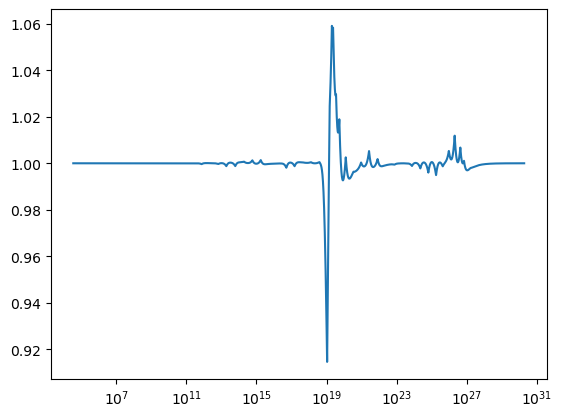

In [29]:
old_time_arr = np.genfromtxt(path_to_data+'old_time_arr.csv', delimiter=',')

plt.plot(time_arr[1:], old_time_arr[1:]/time_arr[1:])
plt.xscale('log')

del old_time_arr

Now we can define $t(T)$ as a function, from the pre-computed arrays.

In [30]:
# interpolating function
# requires reversing the time entries (i.e., written them in _decreasing_ times), and dropping the last one (for which t=0, and whose log blows up)

LtLT_fn = interp1d(np.log10(Temp_arr[:-1]), np.log10(time_arr[::-1][:-1]), bounds_error=False) # interpolating T(t) in log-space

In [31]:
def time_fn(T):
    """
    time_fn : Time [GeV^-1], or age of the Universe, as a function of the temperature T [GeV].

    Parameters:
    T : temperature of the radiation in the Universe [GeV].

    Returns:
    time_fn [GeV^-1]
    """

    Tarr = np.asarray(T) # convert input into array
    
    lowest_T = Temp_arr[:-1][0] # lowest temperature
    highest_T = Temp_arr[:-1][-1] # highest temperature

    if T > highest_T:
        raise ValueError("We took T={0:e} GeV as the earliest temperature of the Universe, and consecuently, that is where we set t=0. You have asked for the age of the Universe at an even larger temperature, T={1:e} GeV, for which t < 0.".format(highest_T, T))

    res = np.where(Tarr < lowest_T, (10.**LtLT_fn(np.log10(lowest_T)))*(lowest_T/Tarr)**2, 10.**LtLT_fn(np.log10(Tarr))) # result, making sure that if outside the bounds then it should use an analytic formula instead.

    return res.item() if np.isscalar(T) else res

### 1.5 $T(t)$

Inverting $t(T)$:

In [32]:
# interpolating function
# requires reversing the temperature entries (i.e., written them in increasing time), and dropping the first one (for which t=0, and whose log blows up)

LTLt_fn = interp1d(np.log10(time_arr[1:]), np.log10((Temp_arr[::-1])[1:]), bounds_error=False) # interpolating T(t) in log-space

In [33]:
def T_fn(t):
    """
    T_fn : Temperature [GeV] as a function of the age of the Universe t [GeV^-1].

    Parameters:
    t : time/age of the Universe [GeV^-1]

    Returns:
    T_fn [GeV]
    """

    tarr = np.asarray(t) # convert input into array

    last_t = time_arr[-1] # largest, latest time

    res = np.where(tarr > last_t,
                   (10.**LTLt_fn(np.log10(last_t)))*(tarr/last_t)**(-1/2),
                   10.**LTLt_fn(np.log10(tarr))
                  ) # result, making sure that if outside the bounds then it should use an analytic formula instead.

    return res.item() if np.isscalar(t) else res

In [34]:
T_fn(sec)/MeV

0.8669335200370244

The critical time $t_c$ at which $T=T_c$

In [35]:
LTLt_fn2 = lambda Lt: np.abs(LTLt_fn(Lt) - np.log10(Tcrit))
tcrit = (10**fsolve(LTLt_fn2, np.log10(1.e19 * GeV))[0])

print(tcrit, "GeV =", tcrit/sec, "sec")

del LTLt_fn2

3.4797518508257276e+19 GeV = 2.290413443069773e-05 sec


Dimensionless $\hat{T}(\hat{t}) \equiv T(\hat{t} \cdot t_c)/T_c$

In [36]:
def T_hat_fn(t_hat):
    """
    T_hat_fn : Temperature in units of Tcrit [dimless] as a function of time t in units of tcrit [dimless].

    Parameters:
    t_hat : time in units of tcrit [dimless]

    Returns:
    T_hat_fn [dimless]
    """

    return T_fn(t_hat*tcrit)/T_fn(tcrit)

In [37]:
time_arr/tcrit

array([0.00000000e+00, 1.03671952e-15, 2.07448991e-15, ...,
       5.33395184e+10, 5.33935855e+10, 5.34477073e+10])

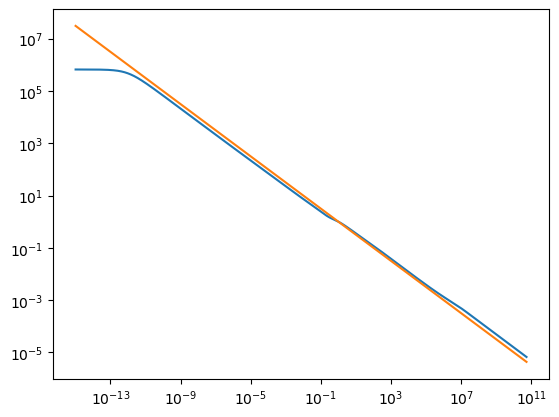

In [38]:
plt.loglog(time_arr[1:]/tcrit, Temp_arr[::-1][1:]/Tcrit)
plt.loglog(time_arr[1:]/tcrit, (time_arr[1:]/tcrit)**(-1/2))

### 1.6 $H(t)$

In [39]:
def Hubt(t):
    """
    Hubt : Hubble expansion rate [GeV].

    Parameters:
    t : time [GeV^-1]

    Returns:
    Hubt [GeV]
    """

    gs_t = gs_fn(T_fn(t)) # rel. d.o.f. in entropy at the time
    T_t = T_fn(t) # temperature at the time [GeV]

    rho_r_t = rho_rad(gs_t, T_t) # radiation energy density at the time [GeV^4]
    hub_t = Hubble(rho_r_t) # Hubble rate at the time [GeV^-1]

    return hub_t

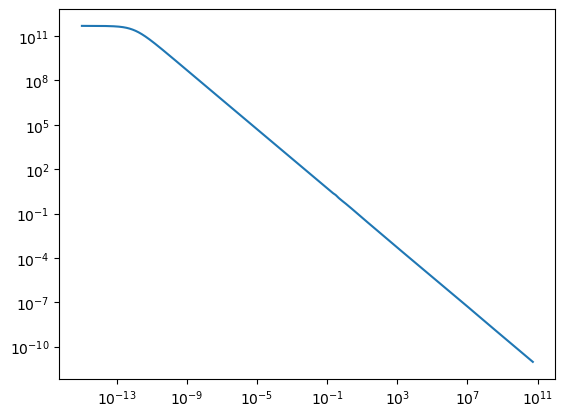

In [40]:
plt.loglog(time_arr[1:]/tcrit, Hubt(time_arr[1:])*tcrit)

### 1.7 $a(t)$

In [41]:
def scale_factor(t):
    """
    scale_factor : scale factor of the Universe [dimless].
     
    Parameters:
    t : time [GeV^-1]

    Returns:
    scale_factor [dimless]
    """

    S0 = scoeff * gs0 * T_g0**3 # total entropy today

    T_t = T_fn(t) # temperature at the time [GeV]
    gs_t = gs_fn(T_t) # rel. d.o.f. in entropy at the time
    
    a_t = np.power(S0/(scoeff * gs_t * T_t**3), 1/3)

    return a_t

In [42]:
Omrad = lambda t: rho_coeff*ge0 * T_fn(t)**4 / rho_crit
Ommat = lambda t: (Omega_m)*scale_factor(t)**(-3)

LtEq = lambda Lt: np.log10(Omrad(10**Lt)) - np.log10(Ommat(10**Lt))

teq = 10**fsolve(LtEq, 36)[0]

print("t_eq =", teq, "GeV^-1 =", teq/yr, "yrs")
print("T_eq =", T_fn(teq)/eV, "eV")

del Omrad, Ommat, LtEq, teq

t_eq = 2.901359022647972e+36 GeV^-1 = 60515.01084054567 yrs
T_eq = 0.8006412114950393 eV


/tmp/ipykernel_13820/3193362701.py:17: RuntimeWarning: invalid value encountered in power
  (10.**LTLt_fn(np.log10(last_t)))*(tarr/last_t)**(-1/2),
/tmp/ipykernel_13820/3193362701.py:18: RuntimeWarning: invalid value encountered in log10
  10.**LTLt_fn(np.log10(tarr))


### 1.8 $\frac{d \ln T}{d \ln a}$ & $\dot{T}(t)$

$\frac{d \ln T}{d \ln a}$

In [43]:
def dlnTdlna(t):
    """
    dlnTdlna : log-derivative w.r.t. the scale factor of ln(T) [dimless].

    Parameters:
    t : time [GeV^-1]

    Returns:
    dlnTdlna [dimless]
    """
    
    tarr = np.asarray(t)
    
    res = np.where( (time_arr[1] < tarr), np.where((tarr < time_arr[-1]), 1./dLadLT_fn(np.log(T_fn(tarr))), -1), -1)
    
    return res.item() if np.isscalar(t) else res

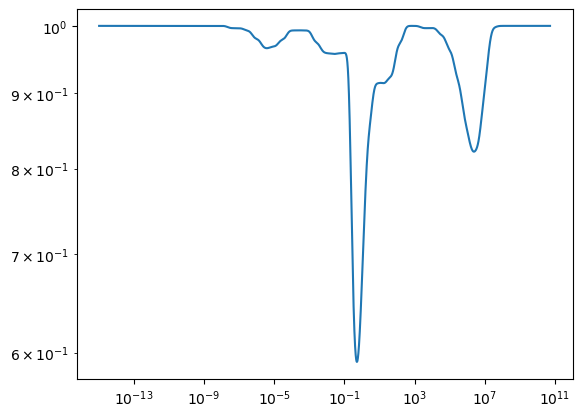

In [44]:
plt.loglog(time_arr[1:]/tcrit, np.abs(dlnTdlna(time_arr[1:])))

$\frac{dT(t)}{dt} = \frac{d \ln T}{d \ln a} H T$

In [45]:
def dTdt(t):
    """
    dTdt : time derivative of the temperature [GeV^2].

    Parameters:
    t : time [GeV^-1]

    Returns:
    dTdt [GeV^2]
    """
        
    return dlnTdlna(t) * Hubt(t) * T_fn(t)

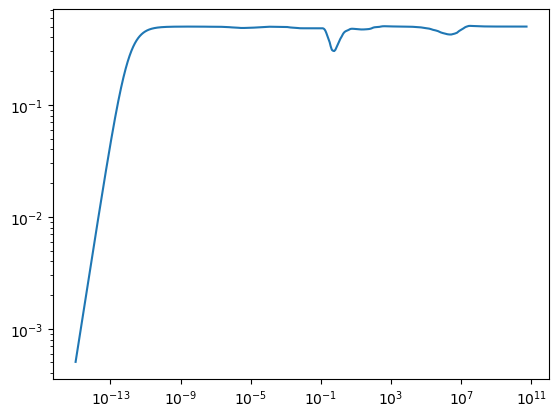

In [46]:
plt.loglog(time_arr[1:]/tcrit, np.abs(time_arr[1:]*dTdt(time_arr[1:]))/T_fn(time_arr[1:]))

## 2. Axion Physics

Defining the axion potentials for the two basic models.

### 2.1 Temperature dependence

Interpolation function of the temperature-dependence of the topological suceptibility, $F(T)$, and its derivative $F'(T)$

$F(T) = \frac{1}{\left(1 + (T/T_c)^{8 p} \right)^{1/p}} = \frac{(T/T_c)^{-8}}{(1 + (T/T_c)^{-8p})^{1/p}}$

In [47]:
def FTemp(T, p=12, small=1.e-10):
    """
    FTemp : ad-hoc interpolation function of the temperature dependence of the topological susceptibility, F(T) [dimless].

    Parameters:
    T : temperature [GeV]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    FTemp [dimless]
    """

    large = 1/small # a large number

    tau = T/Tcrit # ratio of temperature to critical temperature

    tau_arr = np.asarray(tau) # turning argument into array

    # disable RuntimeWarning, since I will correct operations with large/small numbers below
    with warn.catch_warnings():
        warn.simplefilter("ignore", category=RuntimeWarning)

        res = np.where(np.power(tau_arr, 8*p) > large,
                       np.power(tau_arr, -8),
                       np.where(np.nan_to_num(np.power(tau_arr, 8*p), posinf=large) < small,
                                1,
                                np.power(tau_arr, -8)/np.power(1 + np.power(tau_arr, -8*p), 1./p)
                                )
                       ) # interpolating function

    return res.item() if np.isscalar(tau) else res

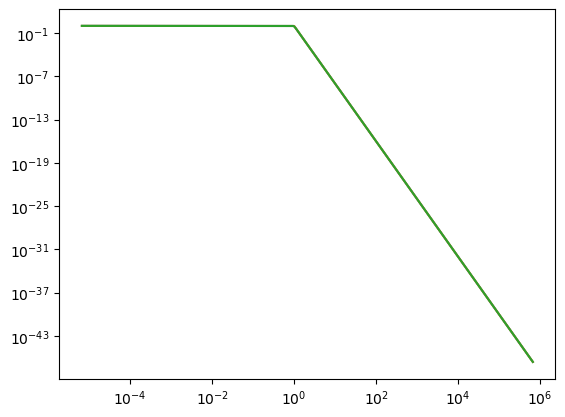

In [48]:
plt.loglog(Temp_arr/Tcrit, FTemp(Temp_arr))
plt.loglog(Temp_arr/Tcrit, FTemp(Temp_arr, 8))
plt.loglog(Temp_arr/Tcrit, FTemp(Temp_arr, 4))

# plt.xlim(0.3, 2)
# plt.ylim(0.01,1.5);

$F'(T) =  - \frac{8}{T_c} \, F(T)^{1+p} \, \left( T/T_c \right)^{8p - 1}$

In [49]:
def dFTdT(T, p=12, small=1.e-10):
    """
    dFTdT : Derivative F'(T) [GeV^-1] of F(T) w.r.t. temperature.

    Parameters:
    T : temperature [GeV]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    dFTdT [GeV^-1]
    """

    large = 1/small # a large number
    
    x = T/Tcrit # ratio of temperature to critical temperature

    FT = FTemp(T, p=p, small=small)

    # disable RuntimeWarning, since I will correct operations with large/small numbers below
    with warn.catch_warnings():
        warn.simplefilter("ignore", category=RuntimeWarning)

        factor = np.nan_to_num(np.power(x,-1 + 8*p), posinf=large)

    return -8.*np.power(FT, 1+p)*factor / Tcrit

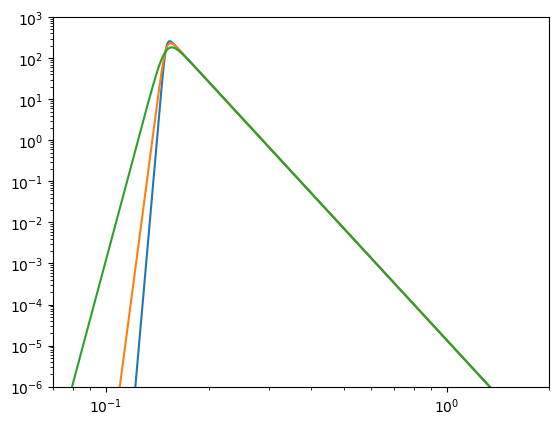

In [50]:
plt.loglog(Temp_arr, np.abs(dFTdT(Temp_arr)/Tcrit))
plt.loglog(Temp_arr, np.abs(dFTdT(Temp_arr, p=8)/Tcrit))
plt.loglog(Temp_arr, np.abs(dFTdT(Temp_arr, p=4)/Tcrit))
plt.xlim(0.07, 2), plt.ylim(1.e-6, 1.e3);

$\frac{d \ln F}{d \ln T} = \frac{T}{F} F'(T) = -8 \left( \frac{(T/T_c)^{8p}}{1 + (T/T_c)^{8p}} \right) = \frac{-8}{1 + (T/T_c)^{-8p}}$

In [51]:
def dlnFlndT(T, p=12, small=1.e-10):
    """
    dlnFlndT : the log-derivative [dimless] w.r.t. temperature of ln(F).

    Parameters:
    T : temperature [GeV]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    dlnFdlnT [dimless]
    """

    large = 1/small # a large number
    
    tau = T/Tcrit # ratio of temperature to critical temperature
    tau_arr = np.asarray(tau) # turning argument into array

    # disable RuntimeWarning, since I will correct operations with large/small numbers below
    with warn.catch_warnings():
        warn.simplefilter("ignore", category=RuntimeWarning)
        
        res = np.where(np.power(tau_arr, 8*p) > large,
                       -8,
                       -8 * np.power(tau_arr, 8*p)/(1 + np.power(tau_arr, 8*p))
                      )

    return res.item() if np.isscalar(tau) else res

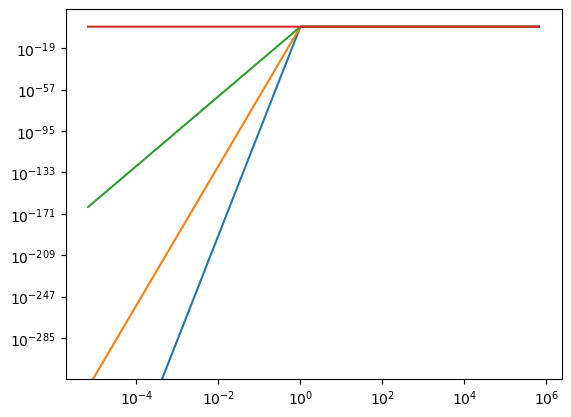

In [52]:
plt.loglog(Temp_arr/Tcrit, np.abs(dlnFlndT(Temp_arr)))
plt.loglog(Temp_arr/Tcrit, np.abs(dlnFlndT(Temp_arr, p=8)))
plt.loglog(Temp_arr/Tcrit, np.abs(dlnFlndT(Temp_arr, p=4)))
plt.loglog(Temp_arr/Tcrit, 8*np.ones_like(Temp_arr))
# plt.xlim(0.01, 10), plt.ylim(1.e-2, 10);

### 2.2 Angular dependence

$\chi(\theta) \equiv \sqrt{1 + 2z' \left( \cos(\theta) - 1 \right)}$,

where $z' \equiv z/(1+z)^2$.

In [53]:
def chpt_fn(theta):
    """
    chpt_fn : Dependence of the topological susceptibility on the axion angle, obtained from chiral perturbation theory.

    Parameters:
    theta : axion angle [radians]

    Returns:
    chpt_fn [dimless]
    """
    
    return np.sqrt(1. + 2.*zp*( np.cos(theta) - 1. ))

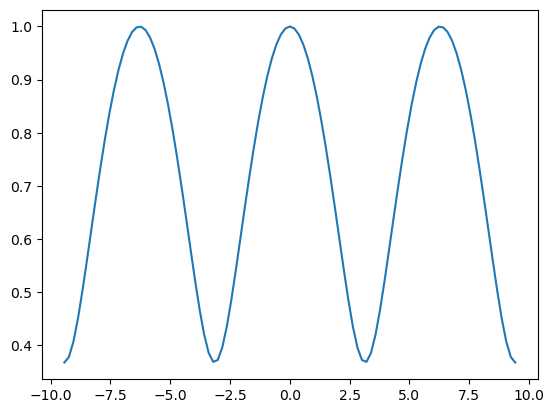

In [54]:
tharr = np.linspace(-3*pi, 3*pi, 101)

plt.plot(tharr, chpt_fn(tharr))

del tharr

### 2.3 Canonical Axion

Axion potential from QCD

$V_{\rm QCD}(\theta, T) = - m_\pi^2 f_\pi^2 \, F(T) \, \chi(\theta)$

In [55]:
def Va_QCD(theta, T=0, p=12, small=1.e-10, cancel_cc=True):
    """
    Va_QCD : axion potential [GeV^4] from QCD, according to leading order in chiral perturbation theory.

    Parameters:
    theta : axion angle [radians]
    T : temperature [GeV] (default: 0)
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)
    cancel_cc : whether we deduct the CC term (default: True)

    Returns:
    Va_QCD [GeV^4]
    """
    
    pref = mpi**2 * fpi**2
    osc = chpt_fn(theta)

    v = -pref*FTemp(T, p=p, small=small)*osc

    if cancel_cc == True:
        v -= -pref
    
    return v

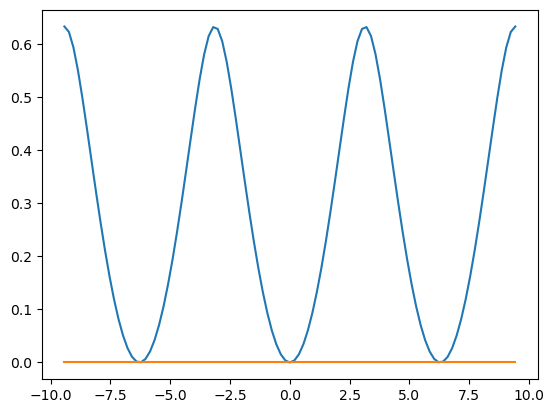

In [56]:
tharr = np.linspace(-3*pi, 3*pi, 101)

plt.plot(tharr, Va_QCD(tharr)/(mpi**2 * fpi**2))
plt.plot(tharr, np.zeros_like(tharr))

del tharr

Field derivative of QCD axion potential

$V'(\theta, T) = z' \, m_\pi^2 f_\pi^2 \, F(T) \, \frac{\sin(\theta)}{\chi(\theta)}$

In [57]:
def Va_QCD_prime(theta, T=0, p=12, small=1.e-10):
    """
    Va_QCD_prime : the field derivative of the axion QCD potential [GeV^4].

    Parameters:
    theta : axion field
    T : temperature [GeV] (default: 0)
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    Va_QCD_prime [GeV^4]
    """

    pref = mpi**2 * fpi**2
    ma2fa2 = zp*pref
    
    num = ma2fa2*FTemp(T, p=p, small=small)*np.sin(theta)
    den = chpt_fn(theta)

    return num/den

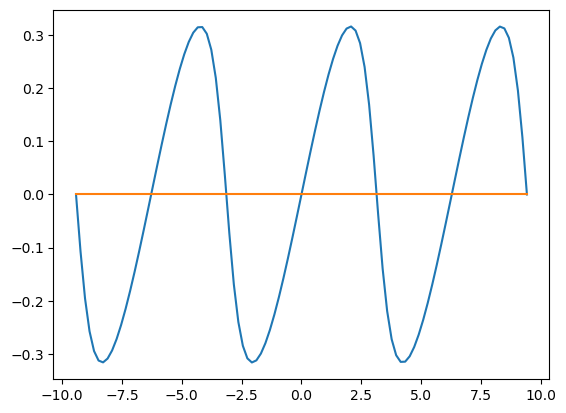

In [58]:
tharr = np.linspace(-3*pi, 3*pi, 101)

plt.plot(tharr, Va_QCD_prime(tharr)/(mpi**2 * fpi**2))
plt.plot(tharr, np.zeros_like(tharr))

del tharr

Second field derivative of QCD axion potential

$V''(\theta, T) = z' \, m_\pi^2 f_\pi^2 \, F(T) \, \left( \frac{\cos\theta}{\chi(\theta)} + \frac{z' \sin^2(\theta)}{\chi^3(\theta)} \right)$

In [59]:
def Va_QCD_primeprime(theta, T=0, p=12, small=1.e-10):
    """
    Va_QCD_primeprime : the second field derivative of the axion QCD potential [GeV^4].

    Parameters:
    theta : axion field
    T : temperature [GeV] (default: 0)
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    Va_QCD_primeprime [GeV^4]
    """

    pref = mpi**2 * fpi**2
    ma2fa2 = zp*pref

    first_term = np.cos(theta)/chpt_fn(theta)
    second_term = zp * np.sin(theta)**2 / np.power(chpt_fn(theta), 3)

    vpp = ma2fa2*FTemp(T, p=p, small=small)*(first_term + second_term)

    return vpp

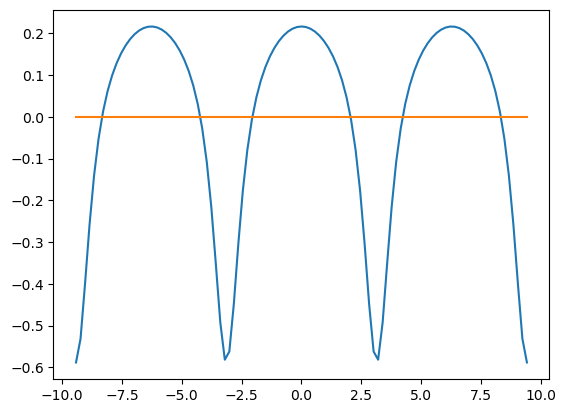

In [60]:
tharr = np.linspace(-3*pi, 3*pi, 101)

plt.plot(tharr, Va_QCD_primeprime(tharr)/(mpi**2 * fpi**2))
plt.plot(tharr, np.zeros_like(tharr))

del tharr

QCD axion mass

Axion mass at zero temperature ($T=0$), *i.e.*, around $\theta = 0$:

$m_a(f_a) = \sqrt{z'} \, m_\pi f_\pi / f_a$

In [61]:
def ma_QCD(fa, T=0, p=12, small=1.e-10):
    """
    ma_QCD : mass of the axion [GeV], to leading order in chPT (i.e., the first term in Eq. (19) of arXiv:1511.02867).

    Parameters:
    fa : axion decay constant [GeV]
    T : temperature [GeV] (default: 0)
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    ma_QCD [GeV]
    """
    
    pref = mpi**2 * fpi**2
    ma2fa2 = zp * pref
    
    return np.sqrt(ma2fa2 * FTemp(T=T, p=p, small=small) / fa**2)

In [62]:
ma_QCD(1.e12) / eV

5.7744625260303095e-06

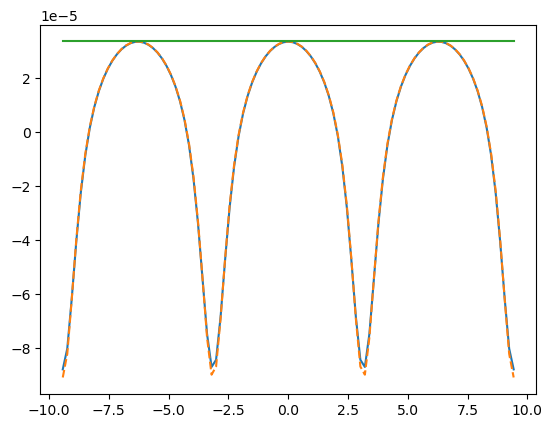

In [63]:
tharr = np.linspace(-3*pi, 3*pi, 101)

plt.plot(tharr, np.gradient(Va_QCD_prime(tharr), tharr))
plt.plot(tharr, Va_QCD_primeprime(tharr), ls='--')

plt.plot(tharr, np.ones_like(tharr)*ma_QCD(1)**2)

del tharr

### 2.4 $\mathbb{Z}_N$-axion + Reheaton Model

#### 2.4.a $\mathbb{Z}_N$ contributions

$\mathbb{Z}_N$ potential

$V_N(\theta) \supset (m_a^2)_{\rm QCD} f_a^2 \, (-1)^N \frac{\epsilon_N}{N^2} \cos( N\theta )$,

with

$\epsilon_N \simeq \sqrt{\frac{1 - z^2}{\pi}} (1+z) N^{3/2} z^{N-1}$

In [64]:
def epsilon_N(N):
    """
    epsilon_N : suppression [dimless] of the QCD axion mass in the ZN-axion model.

    Parameters:
    N : number of SM copies [dimless, integer]

    Return:
    epsilon_N [dimless]
    """

    if N == np.inf:
        eps_N = 0
    else:
        eps_N = np.sqrt((1 - zud**2)/pi) * (1 + zud) * np.power(N, 3/2) * np.power(zud, N-1)

    return eps_N

In [249]:
def Va_N(theta, N, cancel_cc=True):
    """
    Va_N : axion potential [GeV^4] in the ZN model.

    Parameters:
    theta : axion field [radians]
    N : number of SM copies [dimless, integer]
    cancel_cc : whether we deduct the CC term (default: True)

    Returns:
    Va_N [GeV^4]
    """

    if N == np.inf:
        v = 0
    
    else:
        ma2fa2 = zp * mpi**2 * fpi**2

        eps_N = epsilon_N(N)
    
        prefN = ma2fa2*np.power(-1, N)*eps_N / np.power(N, 2)
        oscN = np.cos(N*theta)

        v = prefN*oscN
        
        if cancel_cc == True:
            v -= prefN
    
    return v

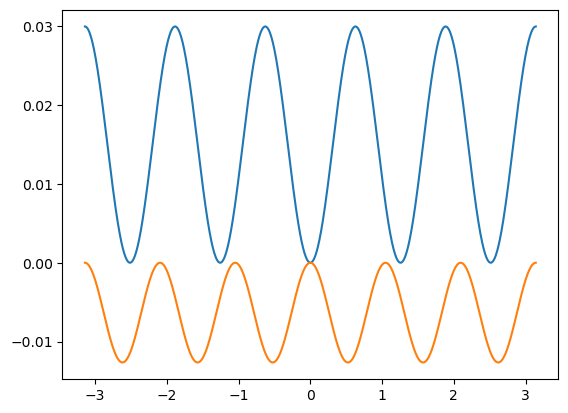

In [66]:
N1 = 5
N2 = 6

tharr = np.linspace(-pi, pi, 1001)

plt.plot(tharr, Va_N(tharr, N1)/(zp * mpi**2 * fpi**2))
plt.plot(tharr, Va_N(tharr, N2)/(zp * mpi**2 * fpi**2))

del N1, N2, tharr

Field derivative of $\mathbb{Z}_N$ axion potential

$V_N'(\theta) = (m_a^2)_{\rm QCD} f_a^2 \, (-1)^{N+1} \frac{\epsilon_N}{N} \sin( N\theta )$

In [254]:
def Va_N_prime(theta, N):
    """
    Va_N_prime : field derivative of the axion potential [GeV^4] in the ZN model.

    Parameters:
    theta : axion field [radians]
    N : number of SM copies [dimless, integer]

    Returns:
    Va_N_prime [GeV^4]
    """

    if N == np.inf:
        vp = 0
    
    else:
        ma2fa2 = zp * mpi**2 * fpi**2

        eps_N = epsilon_N(N)
    
        prefNp = ma2fa2*np.power(-1, N+1)*eps_N / N
        oscN = np.sin(N*theta)

        vp = prefNp*oscN
    
    return vp

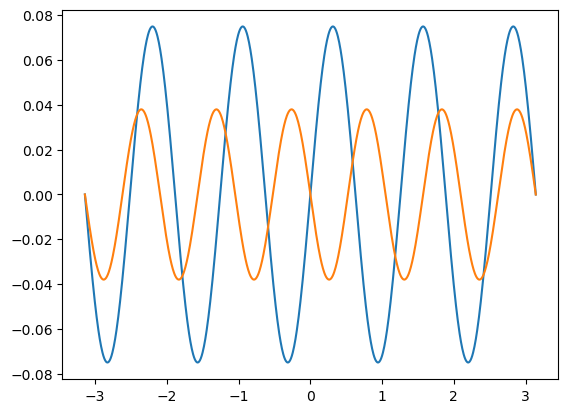

In [68]:
N1 = 5
N2 = 6

tharr = np.linspace(-pi, pi, 1001)

plt.plot(tharr, Va_N_prime(tharr, N1)/(zp * mpi**2 * fpi**2))
plt.plot(tharr, Va_N_prime(tharr, N2)/(zp * mpi**2 * fpi**2))

del N1, N2, tharr

Second field derivative of $\mathbb{Z}_N$ axion potential

$V_N''(\theta) = (m_a^2)_{\rm QCD} f_a^2 \, (-1)^{N+1} \epsilon_N \cos( N\theta )$

In [255]:
def Va_N_primeprime(theta, N):
    """
    Va_N_primeprime : second field derivative of the axion potential [GeV^4] in the ZN model.

    Parameters:
    theta : axion field [radians]
    N : number of SM copies [dimless, integer]

    Returns:
    Va_N_primeprime [GeV^4]
    """

    if N == np.inf:
        vpp = 0

    else:
        ma2fa2 = zp * mpi**2 * fpi**2

        eps_N = epsilon_N(N)
    
        prefNp = ma2fa2*np.power(-1, N+1)*eps_N
        oscN = np.cos(N*theta)

        vpp = prefNp*oscN
    
    return vpp

$\mathbb{Z}_N$ axion mass

$\left( m_a^2 \right)_N = (-1)^{N+1} \epsilon_N \left( m_a^2 \right)_{\rm QCD}$

In [256]:
def ma_N2(N, fa):
    """
    ma_N2 : squared axion mass [GeV^2] in the ZN model.

    Parameters:
    N : number of SM copies [dimless, integer]
    fa : axion decay constant [GeV]

    Returns:
    ma_N2 [GeV^2]
    """

    eps_N = epsilon_N(N)

    if N == np.inf:
        sup = 0
    else:
        sup = np.power(-1, N+1)*eps_N

    return sup * ma_QCD(fa)**2

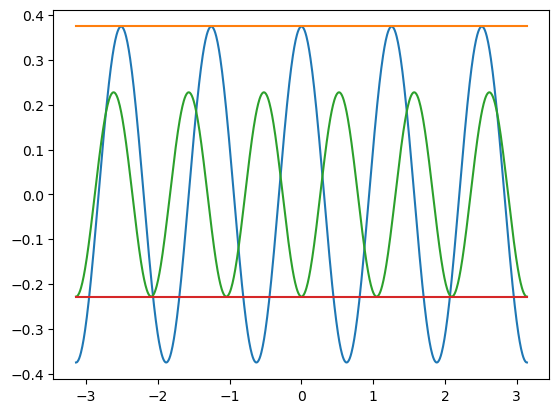

In [71]:
N1 = 5
N2 = 6

tharr = np.linspace(-pi, pi, 1001)

plt.plot(tharr, Va_N_primeprime(tharr, N1)/(zp * mpi**2 * fpi**2))
plt.plot(tharr, np.ones_like(tharr)*ma_N2(N1, 1)/(zp * mpi**2 * fpi**2))
plt.plot(tharr, Va_N_primeprime(tharr, N2)/(zp * mpi**2 * fpi**2))
plt.plot(tharr, np.ones_like(tharr)*ma_N2(N2, 1)/(zp * mpi**2 * fpi**2))

del N1, N2, tharr

#### 2.4.b Reheaton contributions

Contribution to the potential

$V_\phi(\theta, T) = \frac{(m_a^2)_{\rm QCD} f_a^2}{z'} \left[ 1 - (1 + \epsilon_\phi) F(T)  \right] \, \chi(\theta) = m_\pi^2 f_\pi^2 \, \left[ 1 - (1 + \epsilon_\phi) F(T)  \right] \, \chi(\theta)$

In [72]:
def Va_phi(theta, T, eps_phi, p=12, small=1.e-10, cancel_cc=True):
    """
    Va_phi : axion potential [GeV^4] contribution from the reheaton in the ZN model.

    Parameters:
    theta : axion field [radians]
    T : temperature [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)
    cancel_cc : whether we deduct the CC term (default: True)

    Returns:
    Va_phi [GeV^4]
    """
    
    pref = (mpi**2 * fpi**2)
    temp_pref = (1 - (1 + eps_phi)*FTemp(T, p=p, small=small))
    osc = chpt_fn(theta)

    v = pref*temp_pref*osc
    
    if cancel_cc == True:
        v -= -eps_phi * pref
    
    return v

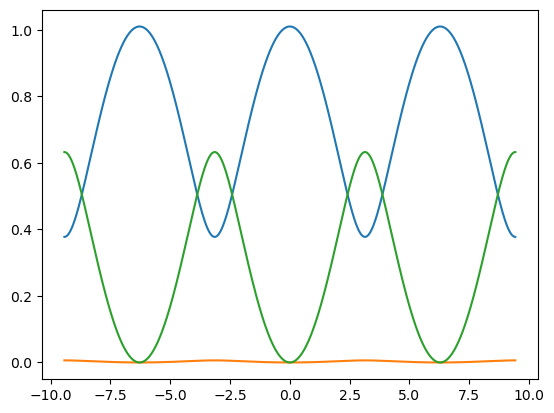

In [73]:
T1 = 10.*Tcrit
T2 = Tcrit/10.

ephi = 1.e-2

tharr = np.linspace(-3*pi, 3*pi, 1001)

plt.plot(tharr, Va_phi(tharr, T1, ephi)/(mpi**2 * fpi**2))
plt.plot(tharr, Va_phi(tharr, T2, ephi)/(mpi**2 * fpi**2))
plt.plot(tharr, Va_phi(tharr, T2, ephi)/(ephi * mpi**2 * fpi**2))

del T1, T2, ephi, tharr

Field derivative of reheaton contribution to axion potential

$V_\phi'(\theta, T) = - z' m_\pi^2 f_\pi^2 \left[ 1 - (1+\epsilon_\phi) F(T) \right] \,\frac{\sin(\theta)}{\chi(\theta)}$

In [74]:
def Va_phi_prime(theta, T, eps_phi, p=12, small=1.e-10):
    """
    Va_phi_prime : field derivative of the axion potential [GeV^4] contribution from the reheaton in the ZN model.

    Parameters:
    theta : axion field [radians]
    T : temperature [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    Va_phi_prime [GeV^4]
    """

    pref = (mpi**2 * fpi**2)
    ma2fa2 = zp*pref
    temp_pref = (1 - (1 + eps_phi)*FTemp(T, p=p, small=small))
    
    num = -ma2fa2*temp_pref*np.sin(theta)
    den = chpt_fn(theta)

    return num/den

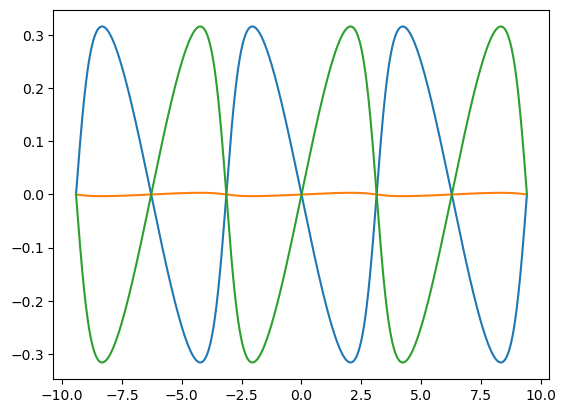

In [75]:
T1 = 10.*Tcrit
T2 = Tcrit/10.

ephi = 1.e-2

tharr = np.linspace(-3*pi, 3*pi, 1001)

plt.plot(tharr, Va_phi_prime(tharr, T1, ephi)/(mpi**2 * fpi**2))
plt.plot(tharr, Va_phi_prime(tharr, T2, ephi)/(mpi**2 * fpi**2))
plt.plot(tharr, Va_phi_prime(tharr, T2, ephi)/(ephi * mpi**2 * fpi**2))

del T1, T2, ephi, tharr

Second field derivative of reheaton contribution to axion potential

$V_\phi''(\theta, T) = - z' \, m_\pi^2 f_\pi^2 \, \left[ 1 - (1+\epsilon_\phi) F(T) \right] \, \left( \frac{\cos\theta}{\chi(\theta)} + \frac{z' \sin^2(\theta)}{\chi^3(\theta)} \right)$

In [76]:
def Va_phi_primeprime(theta, T, eps_phi, p=12, small=1.e-10):
    """
    Va_phi_primeprime : second field derivative of the axion potential [GeV^4] contribution from the reheaton in the ZN model.

    Parameters:
    theta : axion field [radians]
    T : temperature [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    Va_phi_primeprime [GeV^4]
    """

    pref = (mpi**2 * fpi**2)
    ma2fa2 = zp*pref
    temp_pref = (1 - (1 + eps_phi)*FTemp(T, p=p, small=small))

    first_term = np.cos(theta)/chpt_fn(theta)
    second_term = zp * np.sin(theta)**2 / np.power(chpt_fn(theta), 3)
    
    vpp = -ma2fa2*temp_pref*(first_term + second_term)

    return vpp

Reheaton contribution to axion mass

$(m_a^2)_\phi = \epsilon_\phi (m_a^2)_{\rm QCD}$

In [77]:
def ma_phi2(eps_phi, fa):
    """
    ma_phi2 : axion mass squared [GeV^2] contribution from the reheaton in the ZN model.

    Parameters:
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    fa : axion decay constant [GeV]

    Returns:
    ma_phi2 [GeV^2]
    """

    return eps_phi*ma_QCD(fa)**2

At hight temperatures the minimum is $\theta = \pi$, and this is the axion mass:

$\left( m_a^2 \right)_{\pi} = \left( \frac{1+z}{1-z} \right) \, (m_a^2)_{\rm QCD}$

In [78]:
def ma_pi2(fa):

    pref = (1 + zud)/(1 - zud)

    return pref*ma_QCD(fa)**2

### 2.5 Total

Total axion potential

$V_{\rm tot}(\theta, T) = V_N(\theta) + V_\phi (\theta, T)$

In [79]:
def Vtot(theta, T, model, eps_phi, N, p=12, small=1.e-10, cancel_cc=True):
    """
    Vtot : total axion potential [GeV^4], summed over all contributions.

    Parameters:
    theta : axion field [radians]
    T : temperature [GeV]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)
    cancel_cc : whether we deduct the CC term (default: True)

    Returns:
    Vtot [GeV^4]
    """

    if type(model) != str:
        raise TypeError("The argument 'model' must be a string, and equal to either 'QCD' or 'ZN'. The type you passed is '{}'".format(type(model)))

    if model == 'QCD':
        vtot = Va_QCD(theta, T=T, p=p, small=small, cancel_cc=cancel_cc)

    elif model == 'ZN':
        if N == np.inf:
            vn = 0.
        else:
            vn = Va_N(theta, N, cancel_cc=cancel_cc)

        vphi = Va_phi(theta, T, eps_phi, p=p, small=small, cancel_cc=cancel_cc)

        vtot = vn + vphi
    
    else:
        raise ValueError("The argument 'model' must be either 'QCD' or 'ZN'. You passed '{}'".format(model))
    
    return vtot

epsilon_N =  0.07496392083572753
epsilon_phi =  0.01


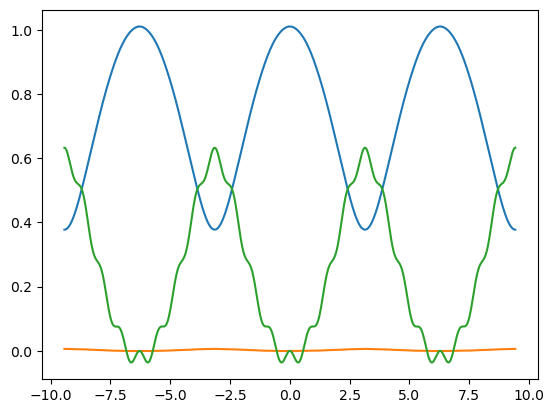

In [80]:
T1 = 10.*Tcrit
T2 = Tcrit/10.

ephi = 1.e-2
eN = 8

print("epsilon_N = ", epsilon_N(eN))
print("epsilon_phi = ", ephi)

tharr = np.linspace(-3*pi, 3*pi, 1001)

plt.plot(tharr, Vtot(tharr, T1, 'ZN', ephi, eN)/(mpi**2 * fpi**2))
plt.plot(tharr, Vtot(tharr, T2, 'ZN', ephi, eN)/(mpi**2 * fpi**2))
plt.plot(tharr, Vtot(tharr, T2, 'ZN', ephi, eN)/(ephi * mpi**2 * fpi**2))

del T1, T2, ephi, eN, tharr

Field derivative of total axion potential

In [81]:
def Vtot_prime(theta, T, model, eps_phi, N, p=12, small=1.e-10):
    """
    Vtot_prime : field derivative of the total axion potential [GeV^4], summed over all contributions.

    Parameters:
    theta : axion field [radians]
    T : temperature [GeV]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    Vtot_prime [GeV^4]
    """

    if type(model) != str:
        raise TypeError("The argument 'model' must be a string, and equal to either 'QCD' or 'ZN'. The type you passed is '{}'".format(type(model)))

    if model == 'QCD':
        vtotp = Va_QCD_prime(theta, T=T, p=p, small=small)
    
    elif model == 'ZN':
        if N == np.inf:
            vnp = 0.
        else:
            vnp = Va_N_prime(theta, N)

        vphip = Va_phi_prime(theta, T, eps_phi, p=p, small=small)

        vtotp = vnp + vphip

    else:
        raise ValueError("The argument 'model' must be either 'QCD' or 'ZN'. You passed '{}'".format(model))

    return vtotp

epsilon_N =  0.0032871285943440317
epsilon_phi =  0.01


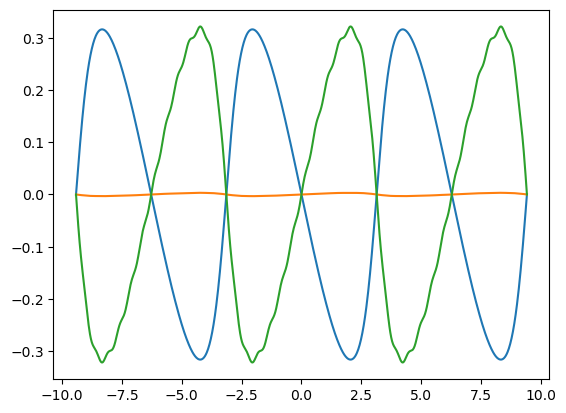

In [82]:
T1 = 10.*Tcrit
T2 = Tcrit/10.

ephi = 1.e-2
eN = 13

print("epsilon_N = ", epsilon_N(eN))
print("epsilon_phi = ", ephi)

tharr = np.linspace(-3*pi, 3*pi, 1001)

plt.plot(tharr, Vtot_prime(tharr, T1, 'ZN', ephi, eN)/(mpi**2 * fpi**2))
plt.plot(tharr, Vtot_prime(tharr, T2, 'ZN', ephi, eN)/(mpi**2 * fpi**2))
plt.plot(tharr, Vtot_prime(tharr, T2, 'ZN', ephi, eN)/(ephi * mpi**2 * fpi**2))

del T1, T2, ephi, eN, tharr

Second field derivative of total axion potential

In [83]:
def Vtot_primeprime(theta, T, model, eps_phi, N, p=12, small=1.e-10):
    """
    Vtot_primeprime : second field derivative of the total axion potential [GeV^4], summed over all contributions.

    Parameters:
    theta : axion field [radians]
    T : temperature [GeV]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    Vtot_primeprime [GeV^4]
    """

    if type(model) != str:
        raise TypeError("The argument 'model' must be a string, and equal to either 'QCD' or 'ZN'. The type you passed is '{}'".format(type(model)))

    if model == 'QCD':
        vtotpp = Va_QCD_primeprime(theta, T=T, p=p, small=small)
    
    elif model == 'ZN':
        if N == np.inf:
            vnpp = 0.
        else:
            vnpp = Va_N_primeprime(theta, N)

        vphipp = Va_phi_primeprime(theta, T, eps_phi, p=p, small=small)

        vtotpp = vnpp + vphipp

    else:
        raise ValueError("The argument 'model' must be either 'QCD' or 'ZN'. You passed '{}'".format(model))

    return vtotpp

The log-derivative w.r.t. the scale factor $a$ of $\ln (m_a)$, where $m_a \equiv \sqrt{V''(\langle \theta \rangle)} / f_a$

$\frac{d \ln m_a}{d \ln a} = \frac{1}{2} \frac{d \ln V''}{d \ln a} = \frac{1}{2} \frac{d \ln V''}{d \ln T} \frac{d \ln T}{d \ln a} = \frac{1}{2} \frac{d \ln V''}{d \ln F} \frac{d \ln F}{d \ln T} \frac{d \ln T}{d \ln a}$.

In [278]:
def dlnmadlna(t, vev, model, eps_phi, N, p=12, small=1.e-10):
    """
    dlnmadlna : log-derivative w.r.t. the scale factor of the log of the axion mass around an axion VEV [dimless].

    t : time [GeV^-1]
    vev : VEV of the axion field [radians]
    T : temperature [GeV]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    dlnmadlna [dimless]
    """

    if type(model) != str:
        raise TypeError("The argument 'model' must be a string, and equal to either 'QCD' or 'ZN'. The type you passed is '{}'".format(type(model)))

    if model == 'QCD':
        dlnVppdlnF = 1
    
    elif model == 'ZN':
        
        chipp = -zp*((np.cos(vev)/chpt_fn(vev)) + ((zp*np.sin(vev)**2)/(chpt_fn(vev)**3))) # second derivative of the angular dependence, evaluated at the VEV
        pref = -(mpi**2 * fpi**2) * (1 + eps_phi) # prefactor of numerator
            
        num = pref*FTemp(T_fn(t), p=p, small=small)*chipp
        den = Va_N_primeprime(vev, N) + Va_phi_primeprime(vev, T_fn(t), eps_phi, p=p, small=small)
        dlnVppdlnF = num/den

    else:
        raise ValueError("The argument 'model' must be either 'QCD' or 'ZN'. You passed '{}'".format(model))

    return 0.5*dlnVppdlnF*dlnFlndT(T_fn(t), p=p, small=small)*dlnTdlna(t)

[-2.57332367e-47 -2.58377336e-47 -2.59426547e-47 ...  1.00001000e+05
  1.00001000e+05  1.00001000e+05] [100000.99999934 100000.99999934 100000.99999934 100000.99999934
 100000.99999934 100000.99999934 100000.99999934 100000.99999934
 100000.99999934 100000.99999934]


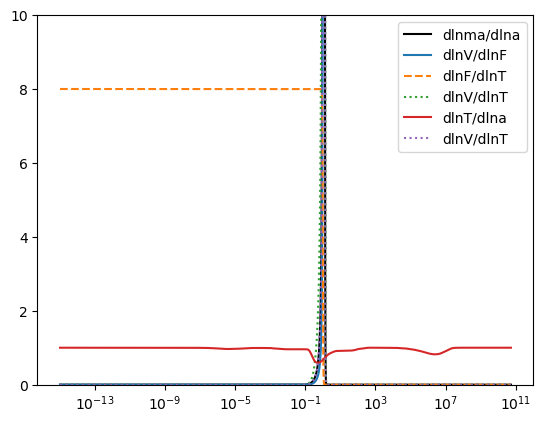

In [285]:
epsphi = 1.e-5

dlVlF = ((-(mpi**2 * fpi**2) * (1 + epsphi))*FTemp(T_fn(time_arr[1:]))*(-zp*((np.cos(pi)/chpt_fn(pi)) + ((zp*np.sin(pi)**2)/(chpt_fn(pi)**3)))))/(Va_phi_primeprime(pi, T_fn(time_arr[1:]), epsphi))

plt.plot(time_arr[1:]/tcrit, np.abs(dlnmadlna(time_arr[1:], pi, 'ZN', epsphi, np.inf)), 'k', label='dlnma/dlna')
plt.plot(time_arr[1:]/tcrit, np.abs(dlVlF), '-', label='dlnV''/dlnF')
plt.plot(time_arr[1:]/tcrit, np.abs(dlnFlndT(T_fn(time_arr[1:]))), '--', label='dlnF/dlnT')
plt.plot(time_arr[1:]/tcrit, np.abs(dlVlF)*np.abs(dlnFlndT(T_fn(time_arr[1:]))), ':', label='dlnV''/dlnT')
plt.plot(time_arr[1:]/tcrit, np.abs(dlnTdlna(time_arr[1:])), label='dlnT/dlna')
plt.plot(time_arr[1:]/tcrit, 0.5*np.abs(dlVlF)*np.abs(dlnFlndT(T_fn(time_arr[1:])))*np.abs(dlnTdlna(time_arr[1:])), ':', label='dlnV''/dlnT')

plt.xscale('log')
plt.ylim(0, 10)

print(dlVlF[:], dlVlF[-10:])

plt.legend()

del epsphi, dlVlF

/tmp/ipykernel_13820/3193362701.py:17: RuntimeWarning: divide by zero encountered in power
  (10.**LTLt_fn(np.log10(last_t)))*(tarr/last_t)**(-1/2),
/tmp/ipykernel_13820/3193362701.py:18: RuntimeWarning: divide by zero encountered in log10
  10.**LTLt_fn(np.log10(tarr))
/tmp/ipykernel_13820/3193362701.py:17: RuntimeWarning: divide by zero encountered in power
  (10.**LTLt_fn(np.log10(last_t)))*(tarr/last_t)**(-1/2),
/tmp/ipykernel_13820/3193362701.py:18: RuntimeWarning: divide by zero encountered in log10
  10.**LTLt_fn(np.log10(tarr))
/tmp/ipykernel_13820/3193362701.py:17: RuntimeWarning: divide by zero encountered in power
  (10.**LTLt_fn(np.log10(last_t)))*(tarr/last_t)**(-1/2),
/tmp/ipykernel_13820/3193362701.py:18: RuntimeWarning: divide by zero encountered in log10
  10.**LTLt_fn(np.log10(tarr))
/tmp/ipykernel_13820/3193362701.py:17: RuntimeWarning: divide by zero encountered in power
  (10.**LTLt_fn(np.log10(last_t)))*(tarr/last_t)**(-1/2),
/tmp/ipykernel_13820/3193362701.py:18:

((0.001, 100), (1e-10, 100))

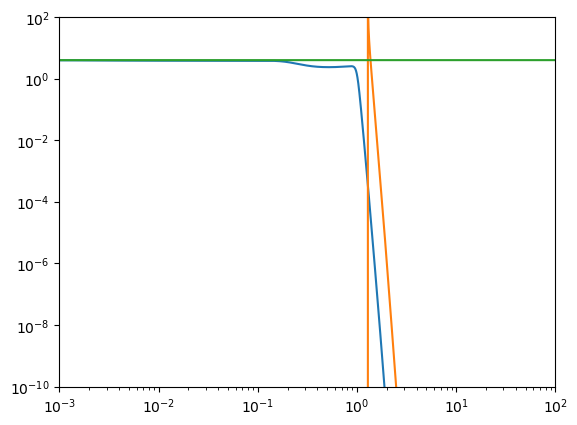

In [284]:
plt.loglog(time_arr/tcrit, dlnmadlna(time_arr, 0, 'QCD', 1.e-5, np.inf))
plt.loglog(time_arr/tcrit, dlnmadlna(time_arr, pi, 'ZN', 1.e-5, np.inf))
plt.loglog(time_arr/tcrit, np.ones_like(time_arr)*4)
plt.xlim(0.001, 100), plt.ylim(1.e-10, 100)

In [287]:
print([dlnmadlna(time_arr[1], 0, 'QCD', 0.01, 53), dlnmadlna(tcrit, 0, 'QCD', 0.01, 53), dlnmadlna(10*tcrit, 0, 'QCD', 0.01, 53)])

print([dlnmadlna(tcrit/10, 0, 'QCD', 0.01, 53), dlnmadlna(tcrit, 0, 'QCD', 0.01, 53), dlnmadlna(10*tcrit, 0, 'QCD', 0.01, 53)])

print([dlnmadlna(tcrit/10, 0, 'ZN', 0.01, 53), dlnmadlna(tcrit, 0, 'ZN', 0.01, 53), dlnmadlna(10*tcrit, 0, 'ZN', 0.01, 53)])

print([dlnmadlna(tcrit/10, 0, 'ZN', 0.01, np.inf), dlnmadlna(tcrit, 0, 'ZN', 0.01, np.inf), dlnmadlna(10*tcrit, 0, 'ZN', 0.01, np.inf)])

print([dlnmadlna(tcrit/10, 0, 'ZN', 0.01, 2), dlnmadlna(tcrit, 0, 'ZN', 0.01, 2), dlnmadlna(10*tcrit, 0, 'ZN', 0.01, 2)])

print([dlnmadlna(tcrit/10, pi, 'QCD', 0.01, 53), dlnmadlna(tcrit, pi, 'QCD', 0.01, 53), dlnmadlna(10*tcrit, pi, 'QCD', 0.01, 53)])

print([dlnmadlna(tcrit/10, pi, 'ZN', 0.01, 53), dlnmadlna(tcrit, pi, 'ZN', 0.01, 53), dlnmadlna(10*tcrit, pi, 'ZN', 0.01, 53)])

print([dlnmadlna(tcrit/10, pi, 'ZN', 0.01, np.inf), dlnmadlna(tcrit, pi, 'ZN', 0.01, np.inf), dlnmadlna(10*tcrit, pi, 'ZN', 0.01, np.inf)])

print([dlnmadlna(tcrit/10, pi, 'ZN', 0.01, 2), dlnmadlna(tcrit, pi, 'ZN', 0.01, 2), dlnmadlna(10*tcrit, pi, 'ZN', 0.01, 2)])

[4.0, 1.339981490033836, 5.081802125469036e-43]
[3.834531969832336, 1.339981490033836, 5.081802125469036e-43]
[-0.003305121844197911, -27.361436288302574, 5.132620146723162e-41]
[-0.003305121844197908, -27.361436288301938, 5.132620146723722e-41]
[-0.0016881046803865203, -1.2726479306328211, -5.4195058882720166e-43]
[3.834531969832336, 1.339981490033836, 5.081802125469036e-43]
[-0.0033051218441979093, -27.361436288302176, 5.132620146723516e-41]
[-0.003305121844197908, -27.36143628830194, 5.132620146723723e-41]
[-0.005100660066150645, 4.1878474372118255, 1.418957814277155e-42]


Total axion mass

Contributions from $\mathbb{Z}_N$ and reheaton:

In [92]:
def ma_tot2(eps_phi, N, fa):
    """
    ma_tot2 : the square of the total axion mass [GeV^2] in the ZN model (w/ reheaton).

    Parameters:
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    fa : axion decay constant [GeV]

    Returns:
    ma_tot2 [GeV^2]
    """

    return ma_phi2(eps_phi, fa) + ma_N2(N, fa)

The minimum value of $N$ for which the reheaton piece is the dominant contribution to the axion mass (although not that if $N$ is even then it will lead to an even smaller value of the total axion mass, since they will partially cancel out)

In [93]:
def Nmin(eps_phi):
    """
    Nmin : the smallest number of SM copies for which the N-copies contribution to the axion mass is smaller than a given reheaton contribution.

    Parameters : eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]

    Returns:
    Nmin [dimless, integer]
    """

    Nguess = 1 + (np.log(eps_phi) - np.log(np.sqrt((1 - zud**2)/pi) * (1 + zud)))/np.log(zud)
    Nguess += -(3/2)*np.log(Nguess)/np.log(zud)

    smallest_N = lambda eN: (epsilon_N(eN) - eps_phi)/eps_phi
    res = int(np.ceil(fsolve(smallest_N, Nguess)[0]))

    return res

In [94]:
eps_phi_test = 1.e-5
Nmin_test = Nmin(eps_phi_test)

print("eps_phi =", eps_phi_test, "\nN_min=", Nmin_test)
print("ma_phi2 fa2 =", ma_phi2(eps_phi_test, 1), "\nma_N2 fa2 =", ma_N2(Nmin_test, 1), "\nma_tot2 fa2 =", ma_tot2(eps_phi_test, Nmin_test, 1))

eps_phi = 1e-05 
N_min= 22
ma_phi2 fa2 = 3.3344417464528347e-10 
ma_N2 fa2 = -2.33771011982704e-10 
ma_tot2 fa2 = 9.967316266257946e-11


## 3. Axion Equations & Solution

Solving for the cosmic evolution of the axion field.

### 3.1 Time(s)

Various time instants and timescales of interest; all things time-related.

#### 3.1.a Time of onset of oscillations: $t_{\rm osc}$:

$3 H(t_{\rm osc}) = m_a(t_{\rm osc})$

In [95]:
def tosc(ma_fn, ratio=1):
    """
    tosc : time [GeV^-1] at which the axion oscillations begin.
    ratio : the ratio of ma/(3*H) we are interested in (default: 1)

    Parameters:
    ma_fn : axion mass [GeV] as a function of time [GeV^-1]

    Returns:
    tosc [GeV^-1]
    """

    tiny = 1.e-16 # tiny number

    # first, we search for a good estimate of the time of oscillation
    Tosc_guess = np.power( np.sqrt(10./(pi**2 * gs_fn(Tcrit))) * ma_fn(1.e10*tcrit) * mpl, 2/(8+4)) * np.power(Tcrit, 8/(8+4)) # Eq. (49) of arXiv:2403.17697
    xosc_guess = 0.5/(tcrit * Hubble(rho_rad(gs_fn(Tosc_guess), Tosc_guess)))

    # defining x = t/tcrit
    h_of_x = lambda x: tcrit*Hubt(x*tcrit) # dimless Hubble rate
    dimless_ma_of_x = lambda x: np.where(tcrit*ma_fn(x*tcrit) < tiny, tiny, tcrit*ma_fn(x*tcrit)) # dimless axion mass

    min_Lfn = lambda Lx: np.log10(dimless_ma_of_x(10.**Lx)) - np.log10(3*h_of_x(10.**Lx)) - np.log10(ratio) # function whose root we want

    # finding solution
    res = least_squares(min_Lfn, np.log10(xosc_guess), bounds=(np.log10(time_arr[1]/tcrit), np.inf))
    x_osc = (10.**res.x[0])

    return x_osc*tcrit

Test: QCD model

In [96]:
ma_of_t = lambda t: ma_QCD(1.e17, T_fn(t))
print("fa=1.e17 GeV, x_osc=",tosc(ma_of_t)/tcrit)

ma_of_t = lambda t: ma_QCD(1.e12, T_fn(t))
print("fa=1.e12 GeV, x_osc=",tosc(ma_of_t)/tcrit)

ma_of_t = lambda t: ma_QCD(1.e11, T_fn(t))
print("fa=1.e11 GeV, t_osc = {:g}, x_osc = {:g}".format(tosc(ma_of_t),tosc(ma_of_t)/tcrit))

ma_of_t = lambda t: ma_QCD(1.e11, T_fn(t))
print("fa=1.e11 GeV, ma/(3H) = 100 at: t_fast = {:g}, x_fast = {:g}".format(tosc(ma_of_t, 100),tosc(ma_of_t, 100)/tcrit))

fa=1.e17 GeV, x_osc= 0.9053759370270575
fa=1.e12 GeV, x_osc= 0.013110578874766372
fa=1.e11 GeV, t_osc = 2.07846e+17, x_osc = 0.00597301
fa=1.e11 GeV, ma/(3H) = 100 at: t_fast = 1.00098e+18, x_fast = 0.0287658


Test: $\mathbb{Z}_N$ model

In [97]:
ma_of_t = lambda x: np.sqrt(ma_phi2(1.e-5, 1.e12))
print("fa=1.e12 GeV, eps_phi=1.e-5, x_osc=",tosc(ma_of_t)/tcrit)

ma_of_t = lambda x: np.sqrt(ma_phi2(1.e-15, 1.e12))
print("fa=1.e12 GeV, eps_phi=1.e-15, x_osc=",tosc(ma_of_t)/tcrit)

ma_of_t = lambda x: np.sqrt(ma_phi2(1.e-5, 1.e18))
print("fa=1.e18 GeV, eps_phi=1.e-5, x_osc=",tosc(ma_of_t)/tcrit)

ma_of_t = lambda x: np.sqrt(ma_phi2(1.e-15, 1.e18))
print("fa=1.e18 GeV, eps_phi=1.e-15, x_osc=",tosc(ma_of_t)/tcrit)

fa=1.e12 GeV, eps_phi=1.e-5, x_osc= 0.00236848949009471
fa=1.e12 GeV, eps_phi=1.e-15, x_osc= 238.4821114868305
fa=1.e18 GeV, eps_phi=1.e-5, x_osc= 2364.630917862091
fa=1.e18 GeV, eps_phi=1.e-15, x_osc= 236690385.6406767


#### 3.1.b Interval of Integration

Defining convenient integration boundaries:

In [98]:
def find_t_interval(model, fa, eps_phi, N, ini_ratio, end_ratio):
    """
    find_t_interval : find a reasonable interval in time [GeV^-1] in which to perform the integration of the axion equations of motion, centered around the oscillation time t_osc.

    Parameters:
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    fa : axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    ini_ratio : ratio ma/(3H) at t_ini
    end_ratio : ratio ma/(3H) at t_end

    Returns:
    (t_ini, t_end) [[GeV^-1], [GeV^-1]]
    """

    if model == 'QCD':
        ma_of_tini = lambda t: ma_QCD(fa, T_fn(t))
        ma_of_tend = ma_of_tini

    elif model == 'ZN':
        # testing if theta=0 is a minimum at late times
        if Nmin(eps_phi) > N:
            raise ValueError("Nmin(eps_phi={:g}) = {:g} > {:i}; that means that theta=0 is a local MAXIMUM and the axion does not solve the strong CP problem. Please increase N or increase eps_phi.".format(eps_phi, Nmin(eps_phi), N))
        
        ma_of_tini = lambda t: np.sqrt(ma_pi2(fa)) # at high temperatures the minimum is at theta = pi
        ma_of_tend = lambda t: np.sqrt(ma_tot2(eps_phi, N, fa)) # at low temperatures the minimum is at theta = 0

        Vtot_primeprime(pi, Thi, 'ZN', eps_phi, N)

    else:
        raise ValueError("The argument 'model' must be either 'QCD' or 'ZN'. You passed '{}'".format(model))
    
    t_ini = tosc(ma_of_tini, ini_ratio)
    t_end = tosc(ma_of_tend, end_ratio)


    return (t_ini, t_end)

In [99]:
[t/tcrit for t in list(find_t_interval('QCD', 1.e17, 1, 1, 0.01, 100))]

[0.13823447593739777, 75.92613544203353]

In [100]:
[t/tcrit for t in list(find_t_interval('QCD', 1.e15, 1, 1, 0.01, 100))]

[0.028765771541093783, 0.9053759370263642]

In [101]:
[t/tcrit for t in list(find_t_interval('ZN', 1.e17, 1.e-5, np.inf, 0.01, 100))]

[0.00455276389038249, 23647.369180103833]

In [102]:
[t/tcrit for t in list(find_t_interval('ZN', 1.e15, 1.e-5, np.inf, 0.01, 100))]

[4.550434772469732e-05, 238.48211148891696]

In [103]:
# find_t_interval('blah', 1.e17, 1.e-5, 51, 0.01, 100)

#### 3.1.c Natural Timescale

In [104]:
def natural_timescale(model, fa, eps_phi, N, time_units, ZN_early=None):
    """
    natural_timescale : The natural timescale [GeV^-1] of a given axion model.

    Parameters:
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    fa - axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    time_units : whether time is in units of tcrit or min[tcrit, 1/maxion] (at zero temperature) (default: 'tcrit')
    ZN_early : if model='ZN' the choice of timescale depends on whether we are considering the early or late time evolution of the axion

    Returns:
    natural_timescale [GeV^-1]
    """
    if type(time_units) != str:
        raise TypeError("The argument 'time_units' must be a string, and equal to either 'tcrit' or '1/maxion'. The type you passed is '{}'".format(type(time_units)))

    if time_units == 'tcrit':
        timescale = tcrit

    elif time_units == '1/maxion':
        if model == 'QCD':
            timescale = min([tcrit, 1/ma_QCD(fa)])
        elif model == 'ZN':
            if ZN_early:
                timescale = min([tcrit, 1/np.sqrt(ma_pi2(fa))])
            else:
                timescale = min([tcrit, 1/np.sqrt(max([ma_tot2(eps_phi, N, fa), ma_phi2(eps_phi, fa)]))])
            
        else:
            raise ValueError("The argument 'model' must be either 'QCD' or 'ZN'. You passed '{}'".format(model))
    else:
        raise ValueError("The argument 'time_units' must be either 'tcrit' or '1/maxion'. You passed '{}'".format(time_units))
        
    return timescale

#### 3.1.d Fast (oscillatory) timescale

In [105]:
def fast_time_int_fn(fast_fn, tini, tend, **kwargs):
    """
    fast_time_int_fn : The fast (i.e., oscillatory) timescale, which is an integral.

    Parameters:
    fast_fn : The large mass scale [GeV] associated with the fast oscillations; must be a function of time.
                 For *small* axion angles this corresponds to the square root of the second field-derivative of the axion potential, namely, the (time-dependent) axion mass!
    tini : initial (early) integration time [GeV^-1]
    tend : final (late) integration time [GeV^-1]

    Returns:
    fast_time_int_fn [dimless]
    """

    # natural timescale in the integration
    fast_scale = fast_fn(tend)
    timescale = 1/fast_scale

    # dimless times
    xini, xend = tini/timescale, tend/timescale

    # the integrand, to be integrated w.r.t. ln(x)
    def integrand(lnx): return fast_fn(np.exp(lnx)*timescale) * np.exp(lnx) / fast_scale
    
    # the integral, and its error
    res, error = quad(lambda lnx: integrand(lnx), np.log(xini), np.log(xend), **kwargs) # integrating w.r.t. x
    
    return res, error

Test:

In [106]:
my_ma_fn = lambda t: ma_QCD(1.e12, T=T_fn(t))

tintarr = np.logspace(np.log10(0.0001*tcrit), np.log10(100*tcrit), 1001)
marr = my_ma_fn(tintarr)

integral = simpson(marr, tintarr)

print(integral/(tcrit*ma_QCD(1.e12)))

del tintarr, marr, integral

99.42771415010372


In [107]:
my_ma_fn = lambda t: ma_QCD(1.e12, T=T_fn(t))

my_result = fast_time_int_fn(my_ma_fn, (0.0001*tcrit), (100*tcrit), epsabs=1.-10, epsrel=1.e-10, limit=10000)
print(my_result)
print(my_result[0]/(tcrit*ma_QCD(1.e12)))

del my_ma_fn, my_result

(19978703.279535595, 0.0011237345536109606)
99.4277141490002


In [108]:
def fast_time_arr(fast_fn, t_Arr, limit=10000, epsabs=1.e-3, epsrel=1.e-3):
    """
    fast_time_arr : Array with the fast (i.e., oscillatory) timescale.

    Parameters:
    fast_fn : The large mass scale [GeV] associated with the fast oscillations; must be a function of time.
                 For *small* axion angles this corresponds to the square root of the second field-derivative of the axion potential, namely, the (time-dependent) axion mass!
    t_Arr : array of integration times [GeV^-1]
    
    Returns:
    fast_time_arr [dimless]
    """

    int_steps_Arr = [] # array of integral steps
    
    int_kws = {'limit':limit, 'epsabs':epsabs, 'epsrel':epsrel} # default keywords for integration

    # performing the integration for each step in the time array
    for i, tend in enumerate(t_Arr):
        
        if i == 0:
            int_steps_Arr.append([0., 0.]) # obviously, the integral over an interval of size 0  is 0
    
        else:
            tini = t_Arr[i-1] # lower end of the integral is previous time value

            dt = tend-tini # size of integration step

            # estimate of size of integral in step
            size = fast_fn(tend)*dt

            int_kws['epsabs'] = epsabs*size # correcting absolute error by estimated size of integral

            fval, err_fval = fast_time_int_fn(fast_fn, tini, tend, **int_kws) # perform integral

            int_steps_Arr.append([fval, err_fval]) # append result

    
    int_steps_Arr = np.array(int_steps_Arr) # turn it into an array

    del i, tend, tini, fval, err_fval # delete temporary variables

    res_Arr = np.cumsum(int_steps_Arr[:,0]) # summing each integral contribution

    return res_Arr

Test:

In [109]:
# my_ma_fn = lambda t: ma_QCD(1.e12, T=T_fn(t))

# test_fast_time = fast_time_arr(my_ma_fn, (time_arr)[1:])

In [110]:
# test_fast_time[1:]/(ma_QCD(1.e12)*tcrit)

Comparing exact result with what we would get if the axion mass was a constant:

In [111]:
# plt.loglog(time_arr[1:]/tcrit, test_fast_time/(ma_QCD(1.e12)*tcrit))
# plt.loglog(time_arr[1:]/tcrit, time_arr[1:]/tcrit, ls='--')

# plt.xlim(0.01,100), plt.ylim(1.e-3, 100);

In [112]:
# plt.loglog(time_arr[1:]/tcrit, test_fast_time)
# plt.loglog(time_arr[1:]/tcrit, ma_QCD(1.e12)*time_arr[1:], ls='--')

# plt.xlim(0.01,100), plt.ylim(1.e2, 1.e7);

In [113]:
# del my_ma_fn, test_fast_time

### 3.2 Axion Equations of Motion (EOM)

Writing down the equations of motion for the axion field. We shall use the dimensionless time variable $x \equiv t/t_c$.

#### 3.2.a Full EOM

Writing down the axion EOM:

$\ddot{\theta} + 3 H(t) \dot{\theta} + V'(\theta, t) = 0$

In [288]:
def axion_eom(x, Y, model, fa, eps_phi, N, timescale, p=12, small=1.e-10):
    """
    axion_eom : Equations of motion of the axion field. Converts the originally nonlinear second-order ODE into a system of two first-order ODEs.

    Parameters:
    x : dimensionless time - independent variable [dimless]
    Y : axion angle and its time derivative - dependent variables [y, y'] = [theta, theta'] ][radians, radians]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    fa : axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    timescale : the time units [GeV^-1]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    [y', y''] = [theta', theta''] [dimless, dimless]
    """

    y, dy = Y # breaking down the tuplet

    temp = T_fn(x*timescale) # temperature [GeV]
    h = timescale*Hubt(x*timescale) # dimless Hubble rate

    dimfac = (timescale/fa)**2 # prefactor to turn potential into dimless quantity
    vp = dimfac*Vtot_prime(y, temp, model, eps_phi, N, p=p, small=small) # field derivative of the potential [dimless]

    ddy = -3*h*dy - vp

    return [dy, ddy]

Now we define the Jacobian matrix $\mathbf{J}$ associated with the system of differential equations of motion for the axion field. This should help the `solve_ivp` routine.

Defining $y_1 \equiv \theta$ and $y_2 \equiv \dot\theta$, we can transform the single second-order ODE into two first-order ODE as follows:

$\dot{y}_1 = f_1 \equiv y_2$

(since $\dot{\theta} = \dot{\theta}$, duh!), and

$\dot{y}_2 = f_2 \equiv - 3 H(t) y_2 - V'(y_1, t)$

The jacobian $\mathbf{J}(t, \vec{y})$ is a matrix defined as

$\mathbf{J}_{i,j} \equiv \frac{\partial f_i}{\partial y_j}$.

Clearly, then, in our case we have:

$\mathbf{J}_{1,1} = 0$

$\mathbf{J}_{1,2} = 1$

$\mathbf{J}_{2,1} = -V''(y_1, t)$

$\mathbf{J}_{2,2} = -3 H(t)$

Thus, we know these entries analytically, and also, there is some degree of sparsity to the matrix (which actually changes over time, since $-V''(y_1, t)$ vanishes at large temperatures... but let's ignore that for now).

In [289]:
def axion_jac(x, Y, model, fa, eps_phi, N, timescale, p=12, small=1.e-10):
    """
    axion_jac : The Jacobian matrix for the axion EOM when written as as system of two first-order ODEs.

    Parameters:
    x : dimensionless time - independent variable [dimless]
    Y : axion angle and its time derivative - dependent variables [y, y'] = [theta, theta'] ][radians, radians]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    fa : axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    timescale : the time units [GeV^-1]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    [[J11, J12], [J21, J22]]
    """

    y, dy = Y # breaking down the tuplet

    temp = T_fn(x*timescale) # temperature [GeV]
    h = timescale*Hubt(x*timescale) # dimless Hubble rate

    dimfac = (timescale/fa)**2 # prefactor to turn potential into dimless quantity
    vpp = dimfac*Vtot_primeprime(y, temp, model, eps_phi, N, p=p, small=small) # second field derivative of the potential [dimless]

    # first row of Jacobian
    jac11 = 0
    jac12 = 1

    # second row of Jacobian
    jac21 = -vpp
    jac22 = -3*h

    jac = [[jac11, jac12], [jac21, jac22]] # the Jacobian matrix

    return jac

#### 3.2.b Multi-scale analysis (MSA) EOM

For our simple treatment of the MSA EOM to be valid, the following conditions must be satisfied:

1. $m_a(t) \gg H(t)$: _i.e._, the axion must be sufficiently deep in its oscillatory regime.
2. $\left\vert \theta - \langle \theta \rangle \right\vert \ll 1$: _i.e._, the oscillations should be small.

Condition (1) is at the heart of the MSA, so we must have it. We will use Condition (2) to expand $V_a(\theta)$ for small oscillations. If it is not satisfied, a more sophisticated analysis is possible, but beyond our current goals, which include expediency.

We begin by considering the general EOM:

$\ddot{\theta} + 3 H(t) \dot{\theta} + V'(\theta, t) = 0$

Let us now expand $V'(\theta, t)$ around the VEV $\langle \theta \rangle$:


$V'(\theta, t) = V'(\langle \theta \rangle, t) + V''(\langle \theta \rangle, t) \, (\theta - \langle \theta \rangle) + \frac{1}{2} V'''(\langle \theta \rangle, t) \, (\theta - \langle \theta \rangle)^2 + \mathcal{O}((\theta - \langle \theta \rangle)^3)$.

Because $\langle \theta \rangle$ is a VEV, we have $V'(\langle \theta \rangle, t) = 0$ by definition. Furthermore, we can see that $V'''(\langle \theta \rangle, t) = 0$ as well, for the potentials (QCD and $\mathbb{Z}_N$) and VEVs ($\langle \theta \rangle = k \pi$) we will consider:

$V_{\rm QCD}(\theta, t), \, V_\phi (\theta, t) \propto \chi(\theta) \Rightarrow V'''(\theta, t) \propto \chi'''(\theta) \propto \sin\theta \Rightarrow V'''(k \pi, t) = 0$
$V_N(\theta, t) \propto \cos(N\theta) \Rightarrow V'''(\theta, t) \propto\sin(N\theta) \Rightarrow V'''(k \pi, t) = 0$.

Thus, we have

$V'(\theta, t) = m^2(t) \, (\theta - \langle \theta \rangle) + \mathcal{O}((\theta - \langle \theta \rangle)^3)$,

having denoted $m^2(t) \equiv V''(\langle \theta \rangle, t)$.

Due to Condition (1) we have $m(t) \gg H(t)$, and we can do an MSA. To do this, we define a time-dependent function $f(x)$ that will act as a _fast_ variable on which $\theta(t)$ depends. Any slow modulation of this variable is independent of $f$, and encoded in $x$. We give $f$ a prefactor $1/\epsilon$ for bookkeeping, in order to keep track of the "fast" variables. We will expand the EOM and its solution in powers of $\epsilon$, and solve them consistently. We do this expansion by keeping track of $x$ and $f$ as if they were _separate_ time variables. At the end, we make $\epsilon = 1$.

Thus, we begin by assuming:

$\theta(t) = \Theta_0(t, \frac{1}{\epsilon} f) + \epsilon \Theta_1(t, \frac{1}{\epsilon} f)$.

Also, by the chain rule:

$\frac{d}{dt} = \partial_t + \frac{1}{\epsilon} \dot{f} \partial_f$

$\frac{d^2}{dt^2} = \partial^2_t + \frac{1}{\epsilon} 2 \dot{f} \partial_x \partial_f + \frac{1}{\epsilon} \ddot{f} \partial_f + \frac{1}{\epsilon^2} \dot{f}^2 \partial_f^2$

Plugging these expressions in the axion EOM and collecting the various terms according to their order in $\epsilon$, we obtain:

$\frac{1}{\epsilon^2}\left[ \dot{f}^2 \partial^2_f \Theta_0 + m^2(t) (\Theta_0 - \langle \theta \rangle) \right] + \frac{1}{\epsilon}\left[ 2 \dot f \partial_x \partial_f \Theta_0 + \ddot{f} \partial_f \Theta_0 + 3 H(t) \dot{f} \partial_f \Theta_0 + \dot{f}^2 \partial^2_f \Theta_1 + m^2(t) \Theta_1 \right] + \mathcal{O}(1) = 0$.

In this notebook we will solve to zeroth-order in $\epsilon$ (_i.e._, we take $\theta(t) \approx \Theta_0$). To do that, we focus on the equation above and solve order-by-order.

From the $\mathcal{O}(1/\epsilon^2)$ equation, we find that with $f(t) \equiv \int\limits_{t_i}^t' \mathrm{d}t \, m(t)$ we obtain:

$\Theta_0(t, f) = \langle \theta \rangle + A_0(t) \cos(f(t) + \phi_0(t))$.

Noting that $\dot{f} = m$ and $\ddot{f} = \dot{m}$, we can then plug the above result into the $\mathcal{O}(1/\epsilon)$ equation to find:

$\left[-m(2 \dot{A}_0 + 3 H A_0 + \frac{\dot{m}}{m}A_0) \sin(f + \phi_0) \right] + \left[ - 2 m \dot{\phi} A_0 \cos(f + \phi_0) \right] + \left[ m^2 (\partial^2_f \Theta_1 + \Theta_1) \right] = 0$.

The last term is yet another oscillatory term, which tells us the functional form of $\Theta_1$: $\Theta_1(t) = A_1(t) \cos(f(t) + \phi_1(t))$. The first two terms are called _secular terms_, because once a long time has happened (an "age" or "saeculum") they may grow very large, thereby breaking down the perturbative expansion. Thus, the coefficients of these secular terms must vanish, which gives us the EOM of $A_0(t)$ and $\phi_0(t)$. Furthermore, since $\sin$ and $\cos$ are linearly independent, each of these two terms must vanish independently. This means that:

$\dot{A}_0 + \frac{1}{2}\left( \frac{\dot{m}}{m} + 3 H \right) A_0 = 0$, and

$\dot\phi_0 = 0$.

To find $A_1$ and $\phi_1$ we need to go to next order in $\epsilon$; as we said above we will content ourselves with $\theta(t) \approx \Theta_0(t)$ instead.

The initial conditions for $A_{0i} \equiv A_0(t_i)$ and $\phi_{0i} = \phi_0$ can be found from those for $\theta$ and $\dot\theta$ (noting that $f(t_i) = 0$):

$\theta_i = \langle \theta \rangle + A_{0i} \cos(\phi_{0i} )$,

$\dot\theta_i = \dot{A}_{0i} \cos(\phi_{0i}) - m(t_i) A_{0i} \sin(\phi_{0i})$.

There is clearly an additional degree of freedom, stemming from having introduced $A_0(t)$ and $\phi_0(t)$. Picking $\dot{A}_{0i} = 0$, we have only $A_{0i}$ and $\phi_{0i}$ to worry about.

Finally, note that

$\frac{\dot m}{m} = \frac{d \ln m}{dt} = \frac{d \ln m}{d \ln a} H$.

To summarize, to zeroth-order in $H/m$, we have

$\theta(t) \approx \langle \theta \rangle + A_0(t) \cos(f(t) + \phi_{i0})$, where

$f(t) \equiv \int\limits_{t_i}^t \mathrm{d}t' \, m(t')$

$\dot{A}_0(t) + \frac{3}{2} H(t) \left( 1 + \frac{1}{3} \frac{d \ln m}{d \ln a} \right) A_0(t) = 0$

$\theta_i = \langle \theta \rangle + A_{0i} \cos(\phi_{0i} )$, and

$\dot\theta_i = - m(t_i) A_{0i} \sin(\phi_{0i})$.

Writing down the MSA EOM:

In [290]:
def axion_msa(x, Y, model, fa, eps_phi, N, timescale, vev, p=12, small=1.e-10):
    """
    axion_msa : Equation of motion for the axion oscillation's amplitude [radians] as a function of (dimensionless) time.
    
    Parameters:
    x : dimensionless time - independent variable [dimless]
    Y : amplitude of the axion angle oscillations [radians]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    fa : axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    timescale : the time units [GeV^-1]
    vev : axion angle VEV [radians]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    [y'] [[dimless]]
    """

    y = Y[0] # unpacking (single-element) list

    dLmdLa = dlnmadlna(x*timescale, vev, model, eps_phi, N, p=p, small=small) # dlnm_a/dlna around an axion VEV
    h = timescale*Hubt(x*timescale) # dimless Hubble rate

    dy = -(3/2)*h*(1 + (1/3)*dLmdLa)*y # time derivative

    return [dy]

Now, the jacobian matrix:

$\mathbf{J} = \frac{\partial \dot{A}_0(A_0)}{\partial A_0} = -\frac{3}{2} H(t) \left( 1 + \frac{1}{3} \frac{d \ln m}{d \ln a} \right)$

In [291]:
def msa_jac(x, Y, model, fa, eps_phi, N, timescale, vev, p=12, small=1.e-10):
    """
    msa_jac : The Jacobian matrix for the axion MSA EOM.
    
    Parameters:
    x : dimensionless time - independent variable [dimless]
    Y : amplitude of the axion angle oscillations [radians]
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    fa : axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    timescale : the time units [GeV^-1]
    vev : axion angle VEV [radians]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)

    Returns:
    msa_jac [[dimless]]
    """

    dLmdLa = dlnmadlna(x*timescale, vev, model, eps_phi, N, p=p, small=small) # dlnm_a/dlna around an axion VEV
    h = timescale*Hubt(x*timescale) # dimless Hubble rate

    jac = [[-(3/2)*h*(1 + (1/3)*dLmdLa)]] # jacobian

    return jac

Finally, the initial conditions:

$\theta_i = \langle \theta \rangle + A_{0i} \cos(\phi_{0i} )$, and

$\dot\theta_i = - m(t_i) A_{0i} \sin(\phi_{0i})$

which, defining $\Delta\theta_i = \theta_i - \langle \theta \rangle$, can be analytically solved:

$A_{0i} = \sqrt{(\Delta\theta_i)^2 + (\dot{\theta}_i/m(t_i))^2}$

$\phi_{0,i} = \arctan\left( y=-\dot{\theta}_i/m(t_i), x=\Delta\theta_i \right)$

In [292]:
def msa_ic(vev, mi, thetai, dthetai, debug=False):
    """
    msa_ic : initial conditions for the MSA variables A0 and phi0.

    Parameters:
    vev : axion angle VEV [radians]
    mi : (dimless) axion mass at initial time [dimless]
    thetai : axion angle initial condition [radians]
    dthetai : axion angular speed [radians]

    Returns:
    msa_ic : [A0i, phi0i]
    """

    Dtheta = thetai - vev # amplitude of initial axion oscillation around VEV
    dthetai_norm = dthetai/mi

    A0i = np.sqrt(Dtheta**2 + dthetai_norm**2)
    phi0i = np.arctan2(-dthetai_norm, Dtheta)

    if debug:
        return [A0i, phi0i], [(vev + A0i*np.cos(phi0i)) - thetai, (-mi*A0i*np.sin(phi0i)) - dthetai]
    else:
        return [A0i, phi0i]

### 3.3 Axion energy density and abundance

Update this to include switcheroo strategy (which is the best way to compute axion_density? and axion_abundance?)

- Cross-check: since I have solved for $H(t)$ in the radiation-dominated era, solutions will be inconsistent if:
  - axion has a significant energy density (including CC) when oscillating around $\theta = \pi$, and/or
  - oscillations must begin before matter domination too.

#### 3.3.a $\rho_a(t)$

In [119]:
def axion_density(t, Yvars, model, approach, fa, eps_phi, N, vev, p=12, small=1.e-10, debug=False):
    """
    axion_density : axion energy density [GeV^4].

    Parameters:
    t : time - independent variable [GeV^-1]
    Yvars : the dependent variables. If strategy='brute', these are the axion variables: axion angle [radians], and axion angular speed [radians*GeV]. If strategy='switcheroo'
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    approach : whether we should compute the energy density with the full evolution of the angle variables (approach='full'), or only the MSA (approach='MSA').
    fa : axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    vev : axion angle VEV [radians]
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)
    
    Returns:
    axion_density [GeV^4]
    """

    temp = T_fn(t)

    if approach == 'full':
        
        theta, dtheta = Yvars # theta and its time derivative

        ke = 0.5 * dtheta**2 * fa**2 # kinetic energy
        pe = Vtot(theta, temp, model, eps_phi, N, p=p, small=small, cancel_cc=True) # potential energy

        en = ke + pe # total energy
    
    elif approach == 'MSA':

        A0, dA0 = Yvars # amplitude and its time derivative

        cos2_avg = 0.5 # average of cos^2 over many periods
        sin2_avg = 0.5 # average of sin^2 over many periods

        ke = 0.5 * (dA0 * fa)**2 * cos2_avg + 0.5 * Vtot_primeprime(vev, temp, model, eps_phi, N, p=p, small=small)*(A0**2) * sin2_avg # kinetic energy
        pe = Vtot(vev, temp, model, eps_phi, N, p=p, small=small, cancel_cc=True) + 0.5 * Vtot_primeprime(vev, temp, model, eps_phi, N, p=p, small=small)*(A0**2) * cos2_avg # potential energy

        en = ke + pe # total energy

    else:
        raise ValueError("The parameter 'approach' must be either 'full' or 'MSA'. You passed '{}'".format(approach))

    if debug:
        return en, ke, pe
    
    else:
        return en

#### 3.3.b $\Omega_a h^2$

In [120]:
def axion_abundance(strategy, t_Arr, rho_Arr, tosc=None):
    """
    axion_abundance : calculate the axion abundance [dimless] today, Omega_a*h^2
    
    Parameters:
    strategy : The strategy to solve the EOM, either 'brute' or 'switcheroo'.
    t_Arr : array of times [GeV^-1]. Better extend to sufficiently late times.
    rho_Arr : array of the axion energy density values [GeV^4]
    tosc : time at which the last axion oscillation began [GeV^1-1] (default: None)
    
    Returns:
    axion_abundance : omega_a = Omega_a * h**2 [dimless]
    """

    a_Arr = scale_factor(t_Arr) # computing scale factor array
    rhoa3_Arr = rho_Arr * np.power(a_Arr, 3) # computing rho_axion * a^3

    if strategy == 'brute':

        if tosc == None:
            raise ValueError("We need tosc, but you passed tosc = None.")

        norm_rhoa3_Arr = rhoa3_Arr / rhoa3_Arr[-1] # normalized to the last entry (simply to make units more natural).

        tend = t_Arr[-1] # the last time computed
        last_third = np.log10(tend/max([tosc, 10*tcrit]))/3. # in log-space, the last 1/3 of the integration interval; by this time we expect that the axion oscillations have died out
        tini = tend / np.power(10., last_third) # the lowest time we shall consider for the computation of the axion energy density.

        tini_idx = np.argmin(np.abs(t_Arr - tini)) # the location of xini in x_Arr

        # print("xend=", xend)
        # print("xini=", xini, "xini_idx=", xini_idx)
        # print("last third=", last_third)

        # now, we construct the integrand of norm_rhoa3_Arr. Because of the oscillations, it is not exactly equal to 1 at late times throughout, so we will average its value over the last third
        integrand_Arr = norm_rhoa3_Arr[tini_idx:] * a_Arr[tini_idx:] # array of integrand (rho*a^3 * a) values
        lna_Arr = np.log(a_Arr[tini_idx:]) # array of ln(a) values

        # print("norm_rhoa3=", norm_rhoa3_Arr[xini_idx:])
        # print("a_Arr=", a_Arr[xini_idx:])
        # print("lna_Arr=", lna_Arr[xini_idx:])

        exact_norm = simpson(integrand_Arr, lna_Arr) / simpson(a_Arr[tini_idx:], lna_Arr) # exact norm
        # print("exact norm=", exact_norm)

        Omega_a = exact_norm*rhoa3_Arr[-1]/rho_crit # fractional axion abundance today

    elif strategy == 'switcheroo':
        Omega_a = rhoa3_Arr[-1]/rho_crit # fractional axion abundance today

    else:
        raise ValueError("The parameter 'strategy' must be either 'brute' or 'switcheroo'. You passed '{}'".format(strategy))


    omega_a = Omega_a * h * h # axion energy abundance today

    return omega_a

### 3.4 Solving the axion EOM

#### 3.4.a Defining the `class` object `axion_sol`

- Add class object to routine solving eom (for more easily handling the switcheroo; add energy density to the objects)

- Must include attributes such as .method, .strategy, .fa, .eps_phi, .N, .eps_N, .theta_i, .dthetai .x, .xosc(s), .theta, .dtheta, .rho, .omega_a, .switc_x/A/phi/mu etc. (so that we can keep track of where and when the switcheroos take place, and what the values of the various integrated quantities are); also

In [121]:
class AxionSol:
    """
    The class of solutions to the axion EOM.

    The attributes are:

    model : The model under consideration, either 'QCD' or 'ZN'.
    strategy : The strategy to solve the EOM, either 'brute' or 'switcheroo'.
    fa : The axion decay constant [GeV].
    ma : The axion mass today [GeV].
    t_ini : The initial integration (dimless) time.
    t_end : The final integration (dimless) time.
    theta_ini : The initial value of the axion angle.
    dtheta_ini : The initial value of the axion angular speed.
    toscs : The (dimless) oscillation time(s), tosc/tcrit. For 'QCD' there is only one, for 'ZN' there are two.
    theta_osc : The axion angle at the oscillation time(s)
    dtheta_osc : The axion angular speed at the oscillation time(s)
    t_arr : The array of (dimless) times from the solution.
    theta_arr : The array of axion angle values from the solution.
    dtheta_arr : The array of axion angular speed values from the solution.
    rho_arr : The array of axion energy density values from the solution.
    omega_a : The axion energy density today.
    eps_phi : The suppression of the 'ZN' axion mass squared contribution from the reheaton.
    N : The number of SM copies in the 'ZN' model.
    eps_N : The suppression of the 'ZN' axion mass squared contribution from the N SM copies.
    msa_ranges : The time intervals during which the multiple-scale analysis (MSA) evolution is used.
    msa_t_arr : The array of (dimless) times used in the multiple-scale analysis (MSA) portion(s) of the 'switcheroo' strategy.
    msa_A_arr : The array of amplitude values used in the multiple-scale analysis (MSA) portion(s) of the 'switcheroo' strategy.
    msa_phi_arr : The array of phase values used in the multiple-scale analysis (MSA) portion(s) of the 'switcheroo' strategy.
    """

    default_allowed = ['model', 'strategy', 'model_attributes', 'strategy_attributes', 'fa', 'ma', 't_ini', 't_end', 'theta_ini', 'dtheta_ini', 'toscs', 'theta_osc', 'dtheta_osc', 't_arr', 'theta_arr', 'dtheta_arr', 'rho_arr', 'omega_a']

    def __init__(self, model, strategy):
        
        self.model = model
        self.strategy = strategy

        # checking axion model:
        if self.model == 'QCD':
            self.toscs = [None] # only one xosc
            # no extra attributes allowed:
            self.eps_phi = None
            self.N = None
            self.eps_N = None
            self.model_attributes = []
            
        elif self.model == 'ZN':
            self.toscs = [None]*2 # two xosc's
            self.model_attributes = ['eps_phi', 'N', 'eps_N']
            
        else:
            raise AttributeError("The Class attribute 'model' must be either 'QCD' or 'ZN'. You passed '{}'".format(model))

        # checking solving strategy:
        if self.strategy == 'brute':
            self.msa_ranges = None
            self.msa_t_arr = None
            self.msa_A_arr = None
            self.msa_phi_arr = None
            self.strategy_attributes = []
        elif self.strategy == 'switcheroo':
            self.strategy_attributes = ['msa_ranges', 'msa_t_arr', 'msa_A_arr', 'msa_phi_arr']
        else:
            raise AttributeError("The Class attribute 'strategy' must be either 'brute' or 'switcheroo'. You passed '{}'".format(strategy))

In [122]:
my_sol = AxionSol('QCD', 'brute')
# print(my_sol)
my_sol.fa = 5
my_sol.eps_phi = 5
my_sol.ms_ranges = 5
# print(dir(my_sol))
print(my_sol.toscs)
print(my_sol.fa)
print(my_sol.eps_phi)
print(my_sol.msa_ranges)
# print(my_sol.x_i)
# print(my_sol.msa_ranges)
# print(my_sol.allowed)

del my_sol

[None]
5
5
None


#### **----->TODO** 3.4.b Solving the Axion EOM

**TODO**: need to do many things!

- finalize verbose checkpoints
- when patching, drop the edges, and append solutions
- check if solver works for small (tiny) theta_ini
- correct strange behavior during MSA (envelope amplitude is decreasing too fast?)
- speed up EOM computation in some cases
- find optimal epsabs and epsrel

In [293]:
def solve_axion_eom(model, strategy, fa, eps_phi, N, y0, dy0, endpoint_ratios, p=12, small=1.e-10, method='Radau', start_MSA=100, dense_MSA=False, verbose=False, **kwargs):
    """
    solve_axion_eom : solves the axion equations of motion with given initial conditions.

    Parameters:
    model : the axion model under consideration (can only be 'QCD' or 'ZN')
    strategy : The strategy to solve the EOM, either 'brute' or 'switcheroo'.
    fa : axion decay constant [GeV]
    eps_phi : suppression of the axion mass in the ZN+reheaton model [dimless]
    N : number of copies of the SM in the ZN model [dimless, integer]
    y0 : initial condition for axion angle, theta [radians]
    dy0 : initial condition for time derivative of axion angle, theta' [radians*GeV]
    endpoint_ratios : tuple - the ratios ma/(3H) at t_ini and t_end bracketing the integration time interval [dimless]. The latter is taken as a _suggestion_, the final value will be such that t_end is after tcrit
    p : power for interpolation (default: 12)
    small : determines when the function is asymptoting to 0 or 1 (default: 1.e-6)
    method : integration method (default: 'Radau')
    start_MSA : the minimum ratio ma/(3H) needed before the MSA approximation can kick in
    dense_MSA : whether we want to compute the axion solution in a dense array whenever MSA is computed. If True, it will search for the optimal dense array, based on the mass of the axion mass at the time. Alternatively, if its an integer, it will use that as the number of steps in log-space for the dense array.

    Returns:
    AxionSol Class object
    """

    ###########################################################
    # prepping:

    large_enough = 30 # ~ one and a half orders of magnitude
    just_a_little = 3 # ~ half an order of magnitude
    kwargs['atol'] *= y0 # correcting absolute tolerance based on scale of initial misalignment

    ###########################################################
    
    sol = AxionSol(model, strategy) # instance of the AxionSol Class object

    # allocating various attributes
    sol.fa = fa # fa
    sol.theta_ini = y0 # theta_ini
    sol.dtheta_ini = dy0 # dtheta_ini

    if model == 'QCD':
        sol.ma = ma_QCD(sol.fa, T=0, p=p, small=small) # axion mass today
        sol.toscs[0] = find_t_interval(model, sol.fa, sol.eps_phi, sol.N, 1, 1)[0] # toscs

    if model == 'ZN':
        sol.eps_phi = eps_phi # eps_phi
        sol.N = N # N
        sol.eps_N = epsilon_N(N) # eps_N
        sol.ma = np.sqrt(ma_tot2(sol.eps_phi, sol.N, sol.fa)) # axion mass today
        sol.toscs[0], sol.toscs[1] = find_t_interval(model, sol.fa, sol.eps_phi, sol.N, 1, 1) # first and second oscillation times
        
        # correct toscs in specific cases:
        # 1 - the low-temperature ZN-axion mass is such that the second stage of oscillation would begin to oscillate BEFORE tcrit, except that this mass only 'appears' at tcrit. Essentially, we simply define this second_tosc = tcrit
        second_tosc_at_tcrit = (sol.toscs[1] < tcrit)
        if second_tosc_at_tcrit:
            sol.toscs[1] = tcrit
        
        # 2 - the high-temperature ZN-axion mass is such that the first stage of oscillation would begin to oscillate AFTER tcrit, except that by this time the axion mass has acquired its low-temperature value. Essentially, there is no first stage of oscillation, and we simply define first_tosc = second_tosc
        no_first_tosc = (sol.toscs[0] > tcrit)
        if no_first_tosc:
            sol.toscs[0] = sol.toscs[1]

    sol.t_ini, sol.t_end = find_t_interval(model, sol.fa, sol.eps_phi, sol.N, endpoint_ratios[0], endpoint_ratios[1]) # t_ini, t_end
    # correcting t_end to ensure it occurs after tcrit:
    sol.t_end = max([sol.t_end, large_enough*tcrit])

    if verbose:
        print("*********************************\n")
        print("**** Model={0}, Strategy={1} ****\n".format(sol.model, sol.strategy))
        print("*********************************\n")
        print("Defining important timescales:")
        print(".... t_ini/tcrit =", sol.t_ini/tcrit)
        print(".... t_osc[0]/tcrit =", sol.toscs[0]/tcrit)
        print(".... t_end/tcrit =", sol.t_end/tcrit)
    
    ###########################################################
    
    # functions relevant for solve_ivp
    # axion EOM:
    def eqs(x, Y, timescale):
        """
        Axion EOM as a function of time x and axion variables Y, for a given timescale.
        """

        return axion_eom(x, Y, sol.model, sol.fa, sol.eps_phi, sol.N, timescale, p=p, small=small)

    # axion jacobian:
    def jac(x, Y, timescale):
        """
        Axion Jacobian as a function of rescaled time xr and rescaled axion variables Yr
        """
        
        return axion_jac(x, Y, sol.model, sol.fa, sol.eps_phi, sol.N, timescale, p=p, small=small)

    eom_sparsity = csr_matrix([[0, 1], [1, 1]]) # sparsity matrix of the full EOM jacobian

    if strategy == 'switcheroo':

        def eqs_switch(x, y, timescale, vev):
            """
            Axion MSA EOM as a function of time x and axion variables Y, for a given timescale and axion VEV.
            """
            return axion_msa(x, y, sol.model, sol.fa, sol.eps_phi, sol.N, timescale, vev, p=p, small=small)

        def jac_switch(x, y, timescale, vev):
            """
            Axion MSA Jacobian as a function of time x and axion variables Y, for a given timescale and axion VEV.
            """
            return msa_jac(x, y, sol.model, sol.fa, sol.eps_phi, sol.N, timescale, vev, p=p, small=small)

    ###########################################################

    # defining event function:
    def at_x0(x, x0): # our event: evaluate at a specific time!
        
        return (x/x0 - 1)

    ###########################################################

    # should we really use MSA, or should we override it?
    override = False # default: do what the user says!
    
    # trust but verify: if the interval is too small, the MSA expansion will not be good enough!
    if strategy == 'switcheroo':

        if model == 'QCD':

            tini_MSA = find_t_interval(model, sol.fa, sol.eps_phi, sol.N, 1, start_MSA)[1] # when we can start the MSA
            
            override = (sol.t_end <= tini_MSA) # if interval is too small, override 'switcheroo' and use 'brute'

            if verbose and override:
                print("\n[override] You requested strategy='switcheroo' and start_MSA={0} but, since the MSA starts at tini_MSA = {1:g} >= t_end = {2:g}, I will override it.\n".format(start_MSA, tini_MSA, sol.t_end))
        
        if model == 'ZN':

            tini_MSA1, tini_MSA2 = find_t_interval(model, sol.fa, sol.eps_phi, sol.N, start_MSA, start_MSA) # when we can start the MSA

            tend_MSA1 = tcrit/just_a_little # we end MSA for the first oscillatory stage a little before tcrit

            # correcting the MSA intervals: #TODO
            if second_tosc_at_tcrit:
                tini_MSA2 = just_a_little*tcrit # the 2nd stage of oscillation begins at tcrit, so move tini_MSA2 until after tcrit
            if no_first_tosc:
                tini_MSA1 = large_enough*sol.toscs[1] # the first stage of oscillation does not occur, some move tini_MSA1 until after it
            
            # we may need to override in one case but not the other
            over1 = ((tend_MSA1 <= tini_MSA1) or no_first_tosc) # do we override switcheroo for the first stage of oscillations?
            over2 = (sol.t_end <= tini_MSA2) # do we override switcheroo for the second stage of oscillations
            override = bool(int(over1)*int(over2)) # do we override switcheroo completely?

            if verbose and over1:
                print("\n--- [over1=True] You requested strategy='switcheroo' and start_MSA={0} but, since the 1st MSA starts at tini_MSA1 = {1:g} >= tend_MSA1 = tcrit/{2} = {3:g}, I will override it.\n".format(start_MSA, tini_MSA1, just_a_little, tend_MSA1))

            elif verbose and over2:
                print("\n--- [over2=True] You requested strategy='switcheroo' and start_MSA={0} but, since the 2nd MSA starts at tini_MSA2 = {1:g} >= t_end = {2:g}, I will override it.\n".format(start_MSA, tini_MSA2, sol.t_end))

            elif verbose and override:
                print("\n--- [over1=over2=True] You requested strategy='switcheroo', but for the given parameters the MSA is not a good enough approximation. I will override it.\n")

    
    #################################################################
    ####---------------------------------------------------------####
    ####-----------------   Brute Force: EOM   ------------------####
    ####---------------------------------------------------------####
    #################################################################

    if (strategy == 'brute') or (override):

        if verbose and (strategy == 'switcheroo'):
            print("**** Strategy={1} - Overridden ****".format(sol.model, sol.strategy))
    
        # the timescale to use
        timescale = natural_timescale(sol.model, sol.fa, sol.eps_phi, sol.N, '1/maxion')

        # rescaling time-related quantities
        dimless_interval = (sol.t_ini/timescale, sol.t_end/timescale) # new integration time interval
        dimless_dy0 = dy0*timescale # rescaling the initial value of the time derivative

        # time events
        xevents = [tosc/timescale for tosc in [sol.toscs[0]]] # oscillation times
        xevents.append(tcrit/timescale) # critical time
        xevents.sort()
        xevents = np.array(xevents)

        if verbose:
            print(" -> Events:")
            print(".... xevents =", xevents)
            print(".... tevents = ", xevents*timescale)

        # events functions
        events = [(lambda x, Y, ts, xev=xev: at_x0(x, xev)) for xev in xevents] # events

        if verbose:
            print(" -> Solving EOM.")

        # solving the equations of motion!
        eq_sol = solve_ivp(eqs, dimless_interval, [y0, dimless_dy0], events=events, method=method, jac=jac, jac_sparsity=eom_sparsity, args=(timescale,), **kwargs)

        if verbose:
                print(".... Done!")

        # assigning new attributes; rescaling back from x = t/timescale
        sol.t_arr = eq_sol.t * timescale # the time array
        sol.theta_arr = eq_sol.y[0]
        sol.dtheta_arr = eq_sol.y[1]/timescale # the time derivative

        # all events
        sol.t_events = timescale * np.array(eq_sol.t_events)[:,0] # events: toscs and tcrit
        sol.theta_events = np.array(eq_sol.y_events)[:,0,0] # the axion angle at all events
        sol.dtheta_events = np.array(eq_sol.y_events)[:,0,1]/timescale # the axion angular speed at all events

        vev = None # for strategy = 'brute' no need to define the axion VEV

    ###########################################################

    elif (strategy == 'switcheroo'):

        #################################################################
        ####---------------------------------------------------------####
        ####-------------   QCD Switcheroo: EOM-MSA   ---------------####
        ####---------------------------------------------------------####
        #################################################################

        if model == 'QCD':

            if verbose:
                print("**** EOM-MSA ****".format(sol.model, sol.strategy))

            #.........................................................#
            #             (1) Full Equations Of Motion                #
            #.........................................................#

            if verbose:
                print("(1) EOM")
            
            # the timescale to use
            timescale1 = natural_timescale(sol.model, sol.fa, sol.eps_phi, sol.N, '1/maxion')

            # rescaling time-related quantities
            interval1 = (sol.t_ini/timescale1, tini_MSA/timescale1) # new integration time interval
            dimless_dy0 = dy0*timescale1 # rescaling the initial value of the time derivative

            # time events
            xevents1 = [sol.toscs[0]/timescale1] # oscillation time
            # if tcrit occurs before the MSA kicks in, add it as an event
            tcrit_before_MSA = (tini_MSA >= tcrit)
            if tcrit_before_MSA:
                xevents1.append(tcrit/timescale1)
            xevents1.sort()
            xevents1 = np.array(xevents1)
            
            # events functions
            events1 = [(lambda x, Y, ts, xev=xev: at_x0(x, xev)) for xev in xevents1] # events

            #..........................................................

            if verbose:
                print(" -> Solving EOM.")

            # solving the equations of motion!
            eq_sol1 = solve_ivp(eqs, interval1, [y0, dimless_dy0], events=events1, method=method, jac=jac, jac_sparsity=eom_sparsity, args=(timescale1,), **kwargs)

            if verbose:
                print(".... Done!")

            #..........................................................

            # assigning new attributes; rescaling back from x = t/timescale1 once again
            sol.t_arr = eq_sol1.t * timescale1 # the time array
            sol.theta_arr = eq_sol1.y[0]
            sol.dtheta_arr = eq_sol1.y[1]/timescale1 # the time derivative

            #.........................................................#
            #             (2) Multi-Scale Approximation               #
            #.........................................................#

            if verbose:
                print("(2) MSA")

            # time at start of MSA, and corresponding axion values
            sol.msa_t_ini = [sol.t_arr[-1]]
            sol.msa_theta_ini, sol.msa_dtheta_ini = [sol.theta_arr[-1]], [sol.dtheta_arr[-1]]

            # computing the VEV
            vev_MSA = int(np.round(np.abs(sol.theta_arr[-1])/pi))*pi
            ma_fn = lambda t: np.sqrt(Vtot_primeprime(vev_MSA, T_fn(t), sol.model, sol.eps_phi, sol.N, p=p, small=small))/sol.fa
            sol.msa_ma_ini = [ma_fn(sol.msa_t_ini[-1])]

            if verbose:
                print(" -> Important quantities:")
                print(".... vev_MSA =", vev_MSA)
                print(".... msa_ma_ini =", sol.msa_ma_ini[-1])
                print(".... ma_fn(time_arr[-1]) =", ma_fn(time_arr[-1]))
                print(".... ma =", sol.ma)

            # rescaling time-related quantities: natural timescale is sol.msa_t_ini itself:
            timescale2 = sol.msa_t_ini[-1]
            interval2 = (sol.msa_t_ini[-1]/timescale2, sol.t_end/timescale2) # new integration time interval

            # preparing initial conditions for MSA
            Aphi, testing = msa_ic(vev_MSA, sol.msa_ma_ini[-1]*timescale2, sol.msa_theta_ini[-1], sol.msa_dtheta_ini[-1]*timescale2, debug=True)
            A0i, phi0i = Aphi
            if verbose:
                print(".... [A0i, phi0i] =", Aphi)
                print(".... testing msa_ic: ", testing)

            # preparing functions for MSA
            def eqs_MSA(x, Y): return eqs_switch(x, Y, timescale2, vev_MSA)
            def jac_MSA(x, Y): return jac_switch(x, Y, timescale2, vev_MSA)

            # time events
            # if tcrit does NOT occur before the MSA kicks in, add it as an event
            xevents2 = []
            if not tcrit_before_MSA:
                xevents2.append(tcrit/timescale2)
            xevents2.sort()
            xevents2 = np.array(xevents2)
            
            # events functions
            if len(xevents2) == 0:
                events2 = None
            else:
                events2 = [(lambda x, Y, xev=xev: at_x0(x, xev)) for xev in xevents2] # events

            #..........................................................

            if verbose:
                print(" -> Solving MSA.")

            # solving the MSA EOM!
            eq_sol2 = solve_ivp(eqs_MSA, interval2, [A0i], events=events2, method=method, jac=jac_MSA, **kwargs)

            if verbose:
                print(".... Done!")

            #..........................................................

            # assigning new attributes; rescaling back from x = t/timescale2 once again
            sol.msa_t_arr = [eq_sol2.t * timescale2]
            sol.msa_A_arr = [eq_sol2.y[0]]
            sol.msa_dA_arr = [eqs_MSA(eq_sol2.t, sol.msa_A_arr)[0]/timescale2]
            sol.msa_phi = [phi0i]
            if verbose:
                print(" -> Results:")
                print(".... msa_t_arr =", sol.msa_t_arr[-1])
                print(".... msa_A_arr =", sol.msa_A_arr[-1])
                print(".... msa_dA_arr =", sol.msa_dA_arr[-1])
                print(".... msa_phi =", sol.msa_phi[-1])
            # computing the fast timescale
            sol.msa_fast_arr = [fast_time_arr(ma_fn, sol.msa_t_arr[-1], limit=10000, epsabs=1.e-3, epsrel=1.e-3)]
            
            # interpolating fast timescale function
            # first, dimensionless:
            # f_fn = interp1d(np.log10(sol.msa_t_arr/timescale2), sol.msa_fast_arr/(timescale2*sol.msa_ma_ini))
            # dense_fast_fn = lambda t: (timescale2*sol.msa_ma_ini) * f_fn(np.log10(t/timescale2)) # interpolating fast timescale
            f_fn = interp1d(sol.msa_t_arr[-1]/timescale2, sol.msa_fast_arr[-1]/(timescale2*sol.msa_ma_ini[-1]))
            # next, dimensionful
            dense_fast_fn = lambda t: (timescale2*sol.msa_ma_ini[-1]) * f_fn(t/timescale2) # interpolating fast timescale

            # computing MSA energy density
            sol.msa_rho_arr = [axion_density(sol.msa_t_arr[-1], [sol.msa_A_arr[-1], sol.msa_dA_arr[-1]], sol.model, 'MSA', sol.fa, sol.eps_phi, sol.N, vev_MSA, p=p, small=small)]

            if verbose:
                print(".... t_arr just before MSA =", sol.t_arr[-1])
                print(".... first two msa times: msa_t_arr[:2] =", sol.msa_t_arr[-1][:2])

            #.........................................................#
            #             Matching EOM - MSA solutions                #
            #.........................................................#

            if dense_MSA == False:
                sol.t_arr = np.concatenate([sol.t_arr, sol.msa_t_arr[-1][1:]])
                theta2_arr = vev_MSA + sol.msa_A_arr[-1][1:]*np.cos(sol.msa_fast_arr[-1][1:] + sol.msa_phi[-1])
                dtheta2_arr = sol.msa_dA_arr[-1][1:]*np.cos(sol.msa_fast_arr[-1][1:] + sol.msa_phi[-1]) - ma_fn(sol.msa_t_arr[-1][1:])*sol.msa_A_arr[-1][1:]*np.sin(sol.msa_fast_arr[-1][1:] + sol.msa_phi[-1])

            else:
                # more interpolating functions:
                A_Lx = interp1d(np.log10(sol.msa_t_arr[-1]/timescale2),
                                sol.msa_A_arr[-1],
                                bounds_error=False,
                                fill_value='extrapolate',
                                assume_sorted=True
                               )
                dense_A_fn = lambda t: A_Lx(np.log10(t/timescale2))

                dA_Lx = interp1d(np.log10(sol.msa_t_arr[-1]/timescale2),
                                 sol.msa_dA_arr[-1],
                                 bounds_error=False,
                                 fill_value='extrapolate',
                                 assume_sorted=True
                                )
                dense_dA_fn = lambda t: dA_Lx(np.log10(t/timescale2))

                # defining number of steps in dense array
                if dense_MSA == True:
                    # we will just use a default number of steps
                    Nsteps = 1001 # given number of steps

                elif type(dense_MSA) == int:
                    Nsteps = dense_MSA # given number of steps

                # computing dense arrays
                dense_t_arr = np.logspace(np.log10(sol.msa_t_arr[-1][0]), np.log10(sol.msa_t_arr[-1][-1]), Nsteps) # dense time array, Nsteps; shift first term slightly later!
                # correcting to avoid float errors
                dense_t_arr[0] = sol.msa_t_arr[-1][0]
                dense_t_arr[-1] = sol.msa_t_arr[-1][-1]
                
                # dropping the first entry!
                dense_t_arr = dense_t_arr[1:]

                # dense arrays
                dense_fast_arr = dense_fast_fn(dense_t_arr) # dense fast timescale
                dense_A_arr = dense_A_fn(dense_t_arr) # dense A
                dense_dA_arr = dense_dA_fn(dense_t_arr) # dense dA

                # dense axion variables
                sol.t_arr = np.concatenate([sol.t_arr, dense_t_arr])
                theta2_arr = vev_MSA + dense_A_arr*np.cos(dense_fast_arr + sol.msa_phi[-1])
                dtheta2_arr = dense_dA_arr*np.cos(dense_fast_arr + sol.msa_phi[-1]) - ma_fn(dense_t_arr)*dense_A_arr*np.sin(dense_fast_arr + sol.msa_phi[-1])

            if verbose:
                print(".... msa_fast_arr =", sol.msa_fast_arr[-1])
                print(".... dense_fast_fn(msa_t_arr[:3]) =", dense_fast_fn(sol.msa_t_arr[-1][:3]))
                
            # end of MSA
            sol.msa_t_end = [sol.msa_t_arr[-1][-1]]
            sol.msa_theta_end = [theta2_arr[-1]]
            sol.msa_dtheta_end = [dtheta2_arr[-1]]
            
            # appending/concatenating MSA axion evolution
            sol.theta_arr = np.concatenate([sol.theta_arr, theta2_arr])
            sol.dtheta_arr = np.concatenate([sol.dtheta_arr, dtheta2_arr])

            #.........................................................#
            #                        Events                           #
            #.........................................................#

            if verbose:
                print(" -> Events:")
                print(".... eq_sol1: t_events =", eq_sol1.t_events)
                print(".... eq_sol1: y_events =", eq_sol1.y_events)
                print(".... eq_sol2: t_events =", eq_sol2.t_events)
                print(".... eq_sol2: y_events =", eq_sol2.y_events)

            # picking up events from 1st interval
            time_events1 = timescale1 * np.array(eq_sol1.t_events)[:,0]
            theta_events1 = np.array(eq_sol1.y_events)[:,0,0]
            dtheta_events1 = np.array(eq_sol1.y_events)[:,0,1]/timescale1

            # picking up events from 2nd interval
            time_events2 = timescale2 * np.array(eq_sol2.t_events)[:,0]
            A_events2 = np.array(eq_sol2.y_events)[:,0,0]
            theta_events2 = vev_MSA + A_events2*np.cos(dense_fast_fn(time_events2) + sol.msa_phi[-1])
            dA_events2 = eqs_MSA(np.array(eq_sol2.t_events)[:,0], A_events2)[0]/timescale2
            dtheta_events2 = dA_events2*np.cos(dense_fast_fn(time_events2) + sol.msa_phi[-1]) - ma_fn(time_events2)*A_events2*np.sin(dense_fast_fn(time_events2) + sol.msa_phi[-1])

            # all events
            # time
            sol.t_events = np.concatenate([time_events1, time_events2])
            # theta
            sol.theta_events = np.concatenate([theta_events1, theta_events2]) # the axion angle at tosc1
            # dtheta
            sol.dtheta_events = np.concatenate([dtheta_events1, dtheta_events2]) # the axion angular speed at tosc1

            # # for compatibility with the 'ZN' case (where there may be more than one MSA period), we turn these msa quantities into lists
            # sol.msa_t_arr = [sol.msa_t_arr]
            # sol.msa_A_arr = [sol.msa_A_arr]
            # sol.msa_dA_arr = [sol.msa_dA_arr]
            # sol.msa_phi = [sol.msa_phi]
            # sol.msa_fast_arr = [sol.msa_fast_arr]
            # sol.msa_rho_arr = [sol.msa_rho_arr]

        #################################################################
        ####---------------------------------------------------------####
        ####-----------   ZN Switcheroo: EOM-MSA1-EOM   -------------####
        ####---------------------------------------------------------####
        #################################################################
            
        elif (over1, over2) == (False, True): # eom-msa1-eom
            
            if verbose:
                print("**** EOM-MSA1-EOM ****".format(sol.model, sol.strategy))
            
            #.........................................................#
            #             (1) Full Equations Of Motion                #
            #.........................................................#

            if verbose:
                print("(1) EOM")
            
            # the timescale to use
            timescale1 = natural_timescale(sol.model, sol.fa, sol.eps_phi, sol.N, '1/maxion', ZN_early=True)

            # rescaling time-related quantities
            interval1 = (sol.t_ini/timescale1, tini_MSA1/timescale1) # new integration time interval
            dimless_dy0 = dy0*timescale1 # rescaling the initial value of the time derivative

            # time events
            xevents1 = [tosc/timescale1 for tosc in sol.toscs if tosc <= tini_MSA1] # oscillation times
            xevents1.sort()
            xevents1 = np.array(xevents1)
            
            # events functions
            if len(xevents1) == 0:
                events1 = None
            else:
                events1 = [(lambda x, Y, ts, xev=xev: at_x0(x, xev)) for xev in xevents1] # events

            #..........................................................

            if verbose:
                print(" -> Solving EOM.")

            # solving the equations of motion!
            eq_sol1 = solve_ivp(eqs, interval1, [y0, dimless_dy0], events=events1, method=method, jac=jac, jac_sparsity=eom_sparsity, args=(timescale1,), **kwargs)

            if verbose:
                print(".... Done!")

            #..........................................................

            # assigning new attributes; rescaling back from x = t/timescale1 once again
            sol.t_arr = eq_sol1.t * timescale1 # the time array
            sol.theta_arr = eq_sol1.y[0]
            sol.dtheta_arr = eq_sol1.y[1]/timescale1 # the time derivative

            #.........................................................#
            #             (2) Multi-Scale Approximation               #
            #.........................................................#

            if verbose:
                print("(2) MSA")

            # time at start of MSA, and corresponding axion values
            sol.msa_t_ini = [sol.t_arr[-1]]
            sol.msa_theta_ini, sol.msa_dtheta_ini = [sol.theta_arr[-1]], [sol.dtheta_arr[-1]]

            # computing the VEV
            vev_MSA1 = int(np.round(np.abs(sol.theta_arr[-1])/pi))*pi
            ma_fn = lambda t: np.sqrt(Vtot_primeprime(vev_MSA1, T_fn(t), sol.model, sol.eps_phi, sol.N, p=p, small=small))/sol.fa
            sol.msa_ma_ini = [ma_fn(sol.msa_t_ini[-1])]

            if verbose:
                print(" -> Important quantities:")
                print(".... vev_MSA1 =", vev_MSA1)
                print(".... msa_ma_ini =", sol.msa_ma_ini[-1])
                print(".... ma_fn(time_arr[-1]) =", ma_fn(time_arr[-1]))
                print(".... ma =", sol.ma)

            # rescaling time-related quantities: natural timescale is sol.t_MSA itself:
            timescale2 = sol.msa_t_ini[-1]
            interval2 = (sol.msa_t_ini[-1]/timescale2, tend_MSA1/timescale2) # new integration time interval

            # preparing initial conditions for MSA
            Aphi, testing = msa_ic(vev_MSA1, sol.msa_ma_ini[-1]*timescale2, sol.msa_theta_ini[-1], sol.msa_dtheta_ini[-1]*timescale2, debug=True)
            A0i, phi0i = Aphi
            if verbose:
                print(".... [A0i, phi0i] =", Aphi)
                print(".... testing msa_ic: ", testing)

            # preparing functions for MSA
            def eqs_MSA1(x, Y): return eqs_switch(x, Y, timescale2, vev_MSA1)
            def jac_MSA1(x, Y): return jac_switch(x, Y, timescale2, vev_MSA1)

            #..........................................................

            if verbose:
                print(" -> Solving MSA.")

            # solving the MSA EOM!
            eq_sol2 = solve_ivp(eqs_MSA1, interval2, [A0i], method=method, jac=jac_MSA1, **kwargs)

            if verbose:
                print(".... Done!")

            #..........................................................

            # assigning new attributes; rescaling back from x = t/timescale2 once again
            sol.msa_t_arr = [eq_sol2.t * timescale2]
            sol.msa_A_arr = [eq_sol2.y[0]]
            sol.msa_dA_arr = [eqs_MSA1(eq_sol2.t, sol.msa_A_arr[-1])[0]/timescale2]
            sol.msa_phi = [phi0i]
            if verbose:
                print(" -> Results:")
                print(".... msa_t_arr =", sol.msa_t_arr[-1])
                print(".... msa_A_arr =", sol.msa_A_arr[-1])
                print(".... msa_dA_arr =", sol.msa_dA_arr[-1])
                print(".... msa_phi =", sol.msa_phi[-1])
            # computing the fast timescale
            sol.msa_fast_arr = [fast_time_arr(ma_fn, sol.msa_t_arr[-1], limit=10000, epsabs=1.e-3, epsrel=1.e-3)]
            
            # interpolating fast timescale function
            # first, dimensionless:
            # f_fn = interp1d(np.log10(sol.msa_t_arr/timescale2), sol.msa_fast_arr/(timescale2*sol.msa_ma_ini))
            # dense_fast_fn = lambda t: (timescale2*sol.msa_ma_ini) * f_fn(np.log10(t/timescale2)) # interpolating fast timescale
            f_fn = interp1d(sol.msa_t_arr[-1]/timescale2, sol.msa_fast_arr[-1]/(timescale2*sol.msa_ma_ini[-1]))
            # next, dimensionful
            dense_fast_fn = lambda t: (timescale2*sol.msa_ma_ini[-1]) * f_fn(t/timescale2) # interpolating fast timescale

            # computing MSA energy density
            sol.msa_rho_arr = [axion_density(sol.msa_t_arr[-1], [sol.msa_A_arr[-1], sol.msa_dA_arr[-1]], sol.model, 'MSA', sol.fa, sol.eps_phi, sol.N, vev_MSA1, p=p, small=small)]

            if verbose:
                print(".... t_arr just before MSA =", sol.t_arr[-1])
                print(".... first two msa times: msa_t_arr[:2] =", sol.msa_t_arr[-1][:2])

            #.........................................................#
            #             Matching EOM - MSA solutions                #
            #.........................................................#

            if dense_MSA == False:
                sol.t_arr = np.concatenate([sol.t_arr, sol.msa_t_arr[-1][1:]])
                theta2_arr = vev_MSA1 + sol.msa_A_arr[-1][1:]*np.cos(sol.msa_fast_arr[-1][1:] + sol.msa_phi[-1])
                dtheta2_arr = sol.msa_dA_arr[-1][1:]*np.cos(sol.msa_fast_arr[-1][1:] + sol.msa_phi[-1]) - ma_fn(sol.msa_t_arr[-1][1:])*sol.msa_A_arr[-1][1:]*np.sin(sol.msa_fast_arr[-1][1:] + sol.msa_phi[-1])

            else:
                # more interpolating functions:
                A_Lx = interp1d(np.log10(sol.msa_t_arr[-1]/timescale2),
                                sol.msa_A_arr[-1],
                                bounds_error=False,
                                fill_value='extrapolate',
                                assume_sorted=True
                               )
                dense_A_fn = lambda t: A_Lx(np.log10(t/timescale2))

                dA_Lx = interp1d(np.log10(sol.msa_t_arr[-1]/timescale2),
                                 sol.msa_dA_arr[-1],
                                 bounds_error=False,
                                 fill_value='extrapolate',
                                 assume_sorted=True
                                )
                dense_dA_fn = lambda t: dA_Lx(np.log10(t/timescale2))

                # defining number of steps in dense array
                if dense_MSA == True:
                    # we will just use a default number of steps
                    Nsteps = 1001 # given number of steps

                elif type(dense_MSA) == int:
                    Nsteps = dense_MSA # given number of steps

                # computing dense arrays
                dense_t_arr = np.logspace(np.log10(sol.msa_t_arr[-1][0]), np.log10(sol.msa_t_arr[-1][-1]), Nsteps) # dense time array, Nsteps; shift first term slightly later!
                # correcting to avoid float errors
                dense_t_arr[0] = sol.msa_t_arr[-1][0]
                dense_t_arr[-1] = sol.msa_t_arr[-1][-1]

                # dropping the first entry!
                dense_t_arr = dense_t_arr[1:]

                # dense arrays
                dense_fast_arr = dense_fast_fn(dense_t_arr) # dense fast timescale
                dense_A_arr = dense_A_fn(dense_t_arr) # dense A
                dense_dA_arr = dense_dA_fn(dense_t_arr) # dense dA

                # dense axion variables
                sol.t_arr = np.concatenate([sol.t_arr, dense_t_arr])
                theta2_arr = vev_MSA1 + dense_A_arr*np.cos(dense_fast_arr + sol.msa_phi[-1])
                dtheta2_arr = dense_dA_arr*np.cos(dense_fast_arr + sol.msa_phi[-1]) - ma_fn(dense_t_arr)*dense_A_arr*np.sin(dense_fast_arr + sol.msa_phi[-1])

            if verbose:
                print(" -> msa_fast_arr =", sol.msa_fast_arr[-1])
                print(" -> dense_fast_fn(msa_t_arr[:3]) =", dense_fast_fn(sol.msa_t_arr[-1][:3]))

            # end of MSA
            sol.msa_t_end = [sol.msa_t_arr[-1][-1]]
            sol.msa_theta_end = [theta2_arr[-1]]
            sol.msa_dtheta_end = [dtheta2_arr[-1]]
                
            # appending/concatenating MSA axion evolution
            sol.theta_arr = np.concatenate([sol.theta_arr, theta2_arr])
            sol.dtheta_arr = np.concatenate([sol.dtheta_arr, dtheta2_arr])

            #.........................................................#
            #           (3) Full Equations Of Motion Again            #
            #.........................................................#

            if verbose:
                print("(3) EOM")

            # the timescale to use
            timescale3 = natural_timescale(sol.model, sol.fa, sol.eps_phi, sol.N, '1/maxion', ZN_early=False)

            # rescaling time-related quantities
            interval3 = (sol.msa_t_end[-1]/timescale3, sol.t_end/timescale3) # new integration time interval

            # initial conditions
            y3_ini = theta2_arr[-1]
            dimless_dy3_ini = dtheta2_arr[-1]*timescale3 # rescaling the initial value of the time derivative

            # time events
            xevents3 = [tosc/timescale3 for tosc in sol.toscs if sol.msa_t_end[-1] < tosc] # oscillation times
            xevents3.sort()
            xevents3 = np.array(xevents3)
            
            # events functions
            if len(xevents3) == 0:
                events3 = None
            else:
                events3 = [(lambda x, Y, ts, xev=xev: at_x0(x, xev)) for xev in xevents3] # events

            #..........................................................

            if verbose:
                print(" -> Solving EOM.")

            # solving the equations of motion!
            eq_sol3 = solve_ivp(eqs, interval3, [y3_ini, dimless_dy3_ini], events=events3, method=method, jac=jac, jac_sparsity=eom_sparsity, args=(timescale3,), **kwargs)

            if verbose:
                print(".... Done!")

            #..........................................................

            # appending/concatenating EOM axion evolution; rescaling back from x = t/timescale3 once again
            sol.t_arr = np.concatenate([sol.t_arr, eq_sol3.t * timescale3])
            sol.theta_arr = np.concatenate([sol.theta_arr, eq_sol3.y[0]])
            sol.dtheta_arr = np.concatenate([sol.dtheta_arr, eq_sol3.y[1]/timescale3])

            #.........................................................#
            #                        Events                           #
            #.........................................................#

            if verbose:
                print(" -> Events:")
                print(".... eq_sol1: t_events =", eq_sol1.t_events)
                print(".... eq_sol1: y_events =", eq_sol1.y_events)
                print(".... eq_sol3: t_events =", eq_sol3.t_events)
                print(".... eq_sol3: y_events =", eq_sol3.y_events)

            # picking up events from 1st interval
            time_events1 = timescale1 * np.array(eq_sol1.t_events)[:,0]
            theta_events1 = np.array(eq_sol1.y_events)[:,0,0]
            dtheta_events1 = np.array(eq_sol1.y_events)[:,0,1]/timescale1

            # picking up events in 3rd interval
            time_events3 = timescale3 * np.array(eq_sol3.t_events)[:,0]
            theta_events3 = np.array(eq_sol3.y_events)[:,0,0]
            dtheta_events3 = np.array(eq_sol3.y_events)[:,0,1]/timescale3

            # all events
            # times
            sol.t_events = np.concatenate([time_events1, time_events3]) # tosc1
            # theta
            sol.theta_events = np.concatenate([theta_events1, theta_events3]) # the axion angle at tosc1
            # dthetaprint(" -> V''/fa^2 =", Vtot_primeprime(vev_MSA1, T_fn(T_fn(sol.msa_t_ini[-1])), sol.model, sol.eps_phi, sol.N, p=p, small=small)/sol.fa / sol.fa)
            sol.dtheta_events = np.concatenate([dtheta_events1, dtheta_events3]) # the axion angular speed at tosc1

            # # for compatibility with the 'ZN' case (where there may be more than one MSA period), we turn these msa quantities into lists
            # sol.msa_t_arr = [sol.msa_t_arr]
            # sol.msa_A_arr = [sol.msa_A_arr]
            # sol.msa_dA_arr = [sol.msa_dA_arr]
            # sol.msa_phi = [sol.msa_phi]
            # sol.msa_fast_arr = [sol.msa_fast_arr]
            # sol.msa_rho_arr = [sol.msa_rho_arr]

        #################################################################
        ####---------------------------------------------------------####
        ####-------------   ZN Switcheroo: EOM-MSA2   ---------------####
        ####---------------------------------------------------------####
        #################################################################

        elif (over1, over2) == (True, False): # eom-msa2

            if verbose:
                print("**** EOM-MSA2 ****".format(sol.model, sol.strategy))
            
            #.........................................................#
            #             (1) Full Equations Of Motion                #
            #.........................................................#

            if verbose:
                print("(1) EOM")
            
            # the timescale to use
            timescale1 = natural_timescale(sol.model, sol.fa, sol.eps_phi, sol.N, '1/maxion', ZN_early=True)

            # rescaling time-related quantities
            interval1 = (sol.t_ini/timescale1, tini_MSA2/timescale1) # new integration time interval
            dimless_dy0 = dy0*timescale1 # rescaling the initial value of the time derivative

            # time events
            xevents1 = [tosc/timescale1 for tosc in sol.toscs if tosc <= tini_MSA2] # oscillation times
            # if tcrit occurs before the MSA kicks in, add it as an event
            tcrit_before_MSA = (tini_MSA2 >= tcrit)
            if tcrit_before_MSA:
                xevents1.append(tcrit/timescale1)
            xevents1.sort()
            xevents1 = np.array(xevents1)
            
            # events functions
            if len(xevents1) == 0:
                events1 = None
            else:
                events1 = [(lambda x, Y, ts, xev=xev: at_x0(x, xev)) for xev in xevents1] # events

            #..........................................................

            if verbose:
                print(" -> Solving EOM.")
            
            # solving the equations of motion!
            eq_sol1 = solve_ivp(eqs, interval1, [y0, dimless_dy0], events=events1, method=method, jac=jac, jac_sparsity=eom_sparsity, args=(timescale1,), **kwargs)

            if verbose:
                print(".... Done!")

            #..........................................................

            # assigning new attributes; rescaling back from x = t/timescale1 once again
            sol.t_arr = eq_sol1.t * timescale1 # the time array
            sol.theta_arr = eq_sol1.y[0]
            sol.dtheta_arr = eq_sol1.y[1]/timescale1 # the time derivative

            #.........................................................#
            #             (2) Multi-Scale Approximation               #
            #.........................................................#

            if verbose:
                print("(2) MSA")

            # time at start of MSA, and corresponding axion values
            sol.msa_t_ini = [sol.t_arr[-1]]
            sol.msa_theta_ini, sol.msa_dtheta_ini = [sol.theta_arr[-1]], [sol.dtheta_arr[-1]]

            # computing the VEV
            vev_MSA2 = int(np.round(np.abs(sol.theta_arr[-1])/pi))*pi
            ma_fn = lambda t: np.sqrt(Vtot_primeprime(vev_MSA2, T_fn(t), sol.model, sol.eps_phi, sol.N, p=p, small=small))/sol.fa
            sol.msa_ma_ini = [ma_fn(sol.msa_t_ini[-1])]

            if verbose:
                print(" -> Important quantities:")
                print(".... vev_MSA =", vev_MSA)
                print(".... msa_ma_ini =", sol.msa_ma_ini[-1])
                print(".... ma_fn(time_arr[-1]) =", ma_fn(time_arr[-1]))
                print(".... ma =", sol.ma)

            # rescaling time-related quantities: natural timescale is sol.t_MSA itself:
            timescale2 = sol.msa_t_ini[-1]
            interval2 = (sol.msa_t_ini[-1]/timescale2, sol.t_end/timescale2) # new integration time interval

            # preparing initial conditions for MSA
            Aphi, testing = msa_ic(vev_MSA2, sol.msa_ma_ini[-1]*timescale2, sol.msa_theta_ini[-1], sol.msa_dtheta_ini[-1]*timescale2, debug=True)
            A0i, phi0i = Aphi
            if verbose:
                print(".... [A0i, phi0i] =", Aphi)
                print(".... testing msa_ic: ", testing)

            # preparing functions for MSA
            def eqs_MSA2(x, Y): return eqs_switch(x, Y, timescale2, vev_MSA2)
            def jac_MSA2(x, Y): return jac_switch(x, Y, timescale2, vev_MSA2)

            # time events
            xevents2 = [tosc/timescale2 for tosc in sol.toscs if tosc > tini_MSA2] # oscillation times
            # if tcrit does NOT occur before the MSA kicks in, add it as an event
            if not tcrit_before_MSA:
                xevents2.append(tcrit/timescale2)
            xevents2.sort()
            xevents2 = np.array(xevents2)
            
            # events functions
            if len(xevents2) == 0:
                events2 = None
            else:
                events2 = [(lambda x, Y, xev=xev: at_x0(x, xev)) for xev in xevents2] # events

            #..........................................................

            if verbose:
                print(" -> Solving MSA.")

            # solving the MSA EOM!
            eq_sol2 = solve_ivp(eqs_MSA2, interval2, [A0i], events=events2, method=method, jac=jac_MSA2, **kwargs)

            if verbose:
                print(".... Done!")

            #..........................................................

            # assigning new attributes; rescaling back from x = t/timescale2 once again
            sol.msa_t_arr = [eq_sol2.t * timescale2]
            sol.msa_A_arr = [eq_sol2.y[0]]
            sol.msa_dA_arr = [eqs_MSA2(eq_sol2.t, sol.msa_A_arr[-1])[0]/timescale2]
            sol.msa_phi = [phi0i]
            if verbose:
                print(" -> Results:")
                print(".... msa_t_arr =", sol.msa_t_arr[-1])
                print(".... msa_A_arr =", sol.msa_A_arr[-1])
                print(".... msa_dA_arr =", sol.msa_dA_arr[-1])
                print(".... msa_phi =", sol.msa_phi[-1])
            # computing the fast timescale
            sol.msa_fast_arr = [fast_time_arr(ma_fn, sol.msa_t_arr[-1], limit=10000, epsabs=1.e-3, epsrel=1.e-3)]
            
            # interpolating fast timescale function
            # first, dimensionless:
            # f_fn = interp1d(np.log10(sol.msa_t_arr/timescale2), sol.msa_fast_arr/(timescale2*sol.msa_ma_ini))
            # dense_fast_fn = lambda t: (timescale2*sol.msa_ma_ini) * f_fn(np.log10(t/timescale2)) # interpolating fast timescale
            f_fn = interp1d(sol.msa_t_arr[-1]/timescale2, sol.msa_fast_arr[-1]/(timescale2*sol.msa_ma_ini[-1]))
            # next, dimensionful
            dense_fast_fn = lambda t: (timescale2*sol.msa_ma_ini[-1]) * f_fn(t/timescale2) # interpolating fast timescale

            # computing MSA energy density
            sol.msa_rho_arr = [axion_density(sol.msa_t_arr[-1], [sol.msa_A_arr[-1], sol.msa_dA_arr[-1]], sol.model, 'MSA', sol.fa, sol.eps_phi, sol.N, vev_MSA2, p=p, small=small)]

            if verbose:
                print(".... t_arr just before MSA =", sol.t_arr[-1])
                print(".... first two msa times: msa_t_arr[:2] =", sol.msa_t_arr[-1][:2])

            #.........................................................#
            #             Matching EOM - MSA solutions                #
            #.........................................................#

            if dense_MSA == False:
                sol.t_arr = np.concatenate([sol.t_arr, sol.msa_t_arr[-1][1:]])
                theta2_arr = vev_MSA2 + sol.msa_A_arr[-1][1:]*np.cos(sol.msa_fast_arr[-1][1:] + sol.msa_phi[-1])
                dtheta2_arr = sol.msa_dA_arr[-1][1:]*np.cos(sol.msa_fast_arr[-1][1:] + sol.msa_phi[-1]) - ma_fn(sol.msa_t_arr[-1][1:])*sol.msa_A_arr[-1][1:]*np.sin(sol.msa_fast_arr[-1][1:] + sol.msa_phi[-1])

            else:
                # more interpolating functions:
                A_Lx = interp1d(np.log10(sol.msa_t_arr[-1]/timescale2),
                                sol.msa_A_arr[-1],
                                bounds_error=False,
                                fill_value='extrapolate',
                                assume_sorted=True
                               )
                dense_A_fn = lambda t: A_Lx(np.log10(t/timescale2))

                dA_Lx = interp1d(np.log10(sol.msa_t_arr[-1]/timescale2),
                                 sol.msa_dA_arr[-1],
                                 bounds_error=False,
                                 fill_value='extrapolate',
                                 assume_sorted=True
                                )
                dense_dA_fn = lambda t: dA_Lx(np.log10(t/timescale2))

                # defining number of steps in dense array
                if dense_MSA == True:
                    # we will just use a default number of steps
                    Nsteps = 1001 # given number of steps

                elif type(dense_MSA) == int:
                    Nsteps = dense_MSA # given number of steps

                # computing dense arrays
                dense_t_arr = np.logspace(np.log10(sol.msa_t_arr[-1][0]), np.log10(sol.msa_t_arr[-1][-1]), Nsteps) # dense time array, Nsteps; shift first term slightly later!
                # correcting to avoid float errors
                dense_t_arr[0] = sol.msa_t_arr[-1][0]
                dense_t_arr[-1] = sol.msa_t_arr[-1][-1]

                # dropping the first entry!
                dense_t_arr = dense_t_arr[1:]

                # dense arrays
                dense_fast_arr = dense_fast_fn(dense_t_arr) # dense fast timescale
                dense_A_arr = dense_A_fn(dense_t_arr) # dense A
                dense_dA_arr = dense_dA_fn(dense_t_arr) # dense dA

                # dense axion variables
                sol.t_arr = np.concatenate([sol.t_arr, dense_t_arr])
                theta2_arr = vev_MSA2 + dense_A_arr*np.cos(dense_fast_arr + sol.msa_phi[-1])
                dtheta2_arr = dense_dA_arr*np.cos(dense_fast_arr + sol.msa_phi[-1]) - ma_fn(dense_t_arr)*dense_A_arr*np.sin(dense_fast_arr + sol.msa_phi[-1])

            if verbose:
                print(" -> msa_fast_arr =", sol.msa_fast_arr[-1])
                print(" -> dense_fast_fn(msa_t_arr[:3]) =", dense_fast_fn(sol.msa_t_arr[-1][:3]))

            # end of MSA
            sol.msa_t_end = [sol.msa_t_arr[-1][-1]]
            sol.msa_theta_end = [theta2_arr[-1]]
            sol.msa_dtheta_end = [dtheta2_arr[-1]]
                
            # appending/concatenating MSA axion evolution
            sol.theta_arr = np.concatenate([sol.theta_arr, theta2_arr])
            sol.dtheta_arr = np.concatenate([sol.dtheta_arr, dtheta2_arr])

            #.........................................................#
            #                        Events                           #
            #.........................................................#

            if verbose:
                print(" -> Events:")
                print(".... eq_sol1: t_events =", eq_sol1.t_events)
                print(".... eq_sol1: y_events =", eq_sol1.y_events)
                print(".... eq_sol2: t_events =", eq_sol2.t_events)
                print(".... eq_sol2: y_events =", eq_sol2.y_events)

            # picking up events from 1st interval
            time_events1 = timescale1 * np.array(eq_sol1.t_events)[:,0]
            theta_events1 = np.array(eq_sol1.y_events)[:,0,0]
            dtheta_events1 = np.array(eq_sol1.y_events)[:,0,1]/timescale1
            
            # picking up events in 2nd interval
            if len(xevents2) == 0:
                time_events2 = np.array([])
                A_events2 = np.array([])
                theta_events2 = np.array([])
                dA_events2 = np.array([])
                dtheta_events2 = np.array([])
            else:
                time_events2 = timescale2 * np.array(eq_sol2.t_events)[:,0]
                A_events2 = np.array(eq_sol2.y_events)[:,0,0]
                theta_events2 = vev_MSA2 + A_events2*np.cos(dense_fast_fn(time_events2) + sol.msa_phi[-1])
                dA_events2 = eqs_MSA2(np.array(eq_sol2.t_events)[:,0], A_events2)[0]/timescale2
                dtheta_events2 = dA_events2*np.cos(dense_fast_fn(time_events2) + sol.msa_phi[-1]) - ma_fn(time_events2)*A_events2*np.sin(dense_fast_fn(time_events2) + sol.msa_phi[-1])

            # all events
            # time
            sol.t_events = np.concatenate([time_events1, time_events2])
            # theta
            sol.theta_events = np.concatenate([theta_events1, theta_events2]) # the axion angle at tosc1
            # dtheta
            sol.dtheta_events = np.concatenate([dtheta_events1, dtheta_events2]) # the axion angular speed at tosc1

            # for compatibility with the 'ZN' case (where there may be more than one MSA period), we turn these msa quantities into lists
            # sol.msa_t_arr = [sol.msa_t_arr]
            # sol.msa_A_arr = [sol.msa_A_arr]
            # sol.msa_dA_arr = [sol.msa_dA_arr]
            # sol.msa_phi = [sol.msa_phi]
            # sol.msa_fast_arr = [sol.msa_fast_arr]
            # sol.msa_rho_arr = [sol.msa_rho_arr]

        #################################################################
        ####---------------------------------------------------------####
        ####--------   ZN Switcheroo: EOM-MSA1-EOM-MSA2   -----------####
        ####---------------------------------------------------------####
        #################################################################
            
        elif (over1, over2) == (False, False): # eom-msa1-eom-msa2
            
            if verbose:
                print("**** EOM-MSA1-EOM-MSA2 ****".format(sol.model, sol.strategy))

            #.........................................................#
            #             (1) Full Equations Of Motion                #
            #.........................................................#

            if verbose:
                print("(1) EOM")
            
            # the timescale to use
            timescale1 = natural_timescale(sol.model, sol.fa, sol.eps_phi, sol.N, '1/maxion', ZN_early=True)

            # rescaling time-related quantities
            interval1 = (sol.t_ini/timescale1, tini_MSA1/timescale1) # new integration time interval
            dimless_dy0 = dy0*timescale1 # rescaling the initial value of the time derivative

            # time events
            xevents1 = [tosc/timescale1 for tosc in sol.toscs if tosc <= tini_MSA1] # oscillation times
            xevents1.sort()
            xevents1 = np.array(xevents1)
            
            # events functions
            if len(xevents1) == 0:
                events1 = None
            else:
                events1 = [(lambda x, Y, ts, xev=xev: at_x0(x, xev)) for xev in xevents1] # events

            #..........................................................

            if verbose:
                print(" -> Solving EOM.")

            # solving the equations of motion!
            eq_sol1 = solve_ivp(eqs, interval1, [y0, dimless_dy0], events=events1, method=method, jac=jac, jac_sparsity=eom_sparsity, args=(timescale1,), **kwargs)

            if verbose:
                print(".... Done!")

            #..........................................................

            # assigning new attributes; rescaling back from x = t/timescale1 once again
            sol.t_arr = eq_sol1.t * timescale1 # the time array
            sol.theta_arr = eq_sol1.y[0]
            sol.dtheta_arr = eq_sol1.y[1]/timescale1 # the time derivative

            #.........................................................#
            #             (2) Multi-Scale Approximation               #
            #.........................................................#

            if verbose:
                print("(2) MSA")

            # time at start of MSA, and corresponding axion values
            sol.msa_t_ini = [sol.t_arr[-1]]
            sol.msa_theta_ini, sol.msa_dtheta_ini = [sol.theta_arr[-1]], [sol.dtheta_arr[-1]]

            # computing the VEV
            vev_MSA1 = int(np.round(np.abs(sol.theta_arr[-1])/pi))*pi
            ma_fn = lambda t: np.sqrt(Vtot_primeprime(vev_MSA1, T_fn(t), sol.model, sol.eps_phi, sol.N, p=p, small=small))/sol.fa
            sol.msa_ma_ini = [ma_fn(sol.msa_t_ini[-1])]

            if verbose:
                print(" -> Important quantities:")
                print(".... vev_MSA =", vev_MSA1)
                print(".... msa_ma_ini =", sol.msa_ma_ini[-1])
                print(".... ma_fn(time_arr[-1]) =", ma_fn(time_arr[-1]))
                print(".... ma =", sol.ma)

            # rescaling time-related quantities: natural timescale is sol.t_MSA itself:
            timescale2 = sol.msa_t_ini[-1]
            interval2 = (sol.msa_t_ini[-1]/timescale2, tend_MSA1/timescale2) # new integration time interval

            # preparing initial conditions for MSA
            Aphi, testing = msa_ic(vev_MSA1, sol.msa_ma_ini[-1]*timescale2, sol.msa_theta_ini[-1], sol.msa_dtheta_ini[-1]*timescale2, debug=True)
            A0i, phi0i = Aphi
            if verbose:
                print(".... [A0i, phi0i] =", Aphi)
                print(".... testing msa_ic: ", testing)

            # preparing functions for MSA
            def eqs_MSA1(x, Y): return eqs_switch(x, Y, timescale2, vev_MSA1)
            def jac_MSA1(x, Y): return jac_switch(x, Y, timescale2, vev_MSA1)

            #..........................................................

            if verbose:
                print(" -> Solving MSA.")

            # solving the MSA EOM!
            eq_sol2 = solve_ivp(eqs_MSA1, interval2, [A0i], method=method, jac=jac_MSA1, **kwargs)

            if verbose:
                print(".... Done!")

            #..........................................................

            # assigning new attributes; rescaling back from x = t/timescale2 once again
            sol.msa_t_arr = [eq_sol2.t * timescale2]
            sol.msa_A_arr = [eq_sol2.y[0]]
            sol.msa_dA_arr = [eqs_MSA1(eq_sol2.t, sol.msa_A_arr[-1])[0]/timescale2]
            sol.msa_phi = [phi0i]
            if verbose:
                print(" -> Results:")
                print(".... msa_t_arr =", sol.msa_t_arr[-1])
                print(".... msa_A_arr =", sol.msa_A_arr[-1])
                print(".... msa_dA_arr =", sol.msa_dA_arr[-1])
                print(".... msa_phi =", sol.msa_phi[-1])
            # computing the fast timescale
            sol.msa_fast_arr = [fast_time_arr(ma_fn, sol.msa_t_arr[-1], limit=10000, epsabs=1.e-3, epsrel=1.e-3)]
            
            # interpolating fast timescale function
            # first, dimensionless:
            # f_fn = interp1d(np.log10(sol.msa_t_arr/timescale2), sol.msa_fast_arr/(timescale2*sol.msa_ma_ini))
            # dense_fast_fn = lambda t: (timescale2*sol.msa_ma_ini) * f_fn(np.log10(t/timescale2)) # interpolating fast timescale
            f_fn = interp1d(sol.msa_t_arr[-1]/timescale2, sol.msa_fast_arr[-1]/(timescale2*sol.msa_ma_ini[-1]))
            # next, dimensionful
            dense_fast_fn = lambda t: (timescale2*sol.msa_ma_ini[-1]) * f_fn(t/timescale2) # interpolating fast timescale

            # computing MSA energy density
            sol.msa_rho_arr = [axion_density(sol.msa_t_arr[-1], [sol.msa_A_arr[-1], sol.msa_dA_arr[-1]], sol.model, 'MSA', sol.fa, sol.eps_phi, sol.N, vev_MSA1, p=p, small=small)]

            if verbose:
                print(".... t_arr just before MSA =", sol.t_arr[-1])
                print(".... first two msa times: msa_t_arr[:2] =", sol.msa_t_arr[-1][:2])

            #.........................................................#
            #             Matching EOM - MSA solutions                #
            #.........................................................#

            if dense_MSA == False:
                sol.t_arr = np.concatenate([sol.t_arr, sol.msa_t_arr[-1][1:]])
                theta2_arr = vev_MSA1 + sol.msa_A_arr[-1][1:]*np.cos(sol.msa_fast_arr[-1][1:] + sol.msa_phi[-1])
                dtheta2_arr = sol.msa_dA_arr[-1][1:]*np.cos(sol.msa_fast_arr[-1][1:] + sol.msa_phi[-1]) - ma_fn(sol.msa_t_arr[-1][1:])*sol.msa_A_arr[-1][1:]*np.sin(sol.msa_fast_arr[-1][1:] + sol.msa_phi[-1])

            else:
                # more interpolating functions:
                A_Lx = interp1d(np.log10(sol.msa_t_arr[-1]/timescale2),
                                sol.msa_A_arr[-1],
                                bounds_error=False,
                                fill_value='extrapolate',
                                assume_sorted=True
                               )
                dense_A_fn = lambda t: A_Lx(np.log10(t/timescale2))

                dA_Lx = interp1d(np.log10(sol.msa_t_arr[-1]/timescale2),
                                 sol.msa_dA_arr[-1],
                                 bounds_error=False,
                                 fill_value='extrapolate',
                                 assume_sorted=True
                                )
                dense_dA_fn = lambda t: dA_Lx(np.log10(t/timescale2))

                # defining number of steps in dense array
                if dense_MSA == True:
                    # we will just use a default number of steps
                    Nsteps = 1001 # given number of steps

                elif type(dense_MSA) == int:
                    Nsteps = dense_MSA # given number of steps

                # computing dense arrays
                dense_t_arr = np.logspace(np.log10(sol.msa_t_arr[-1][0]), np.log10(sol.msa_t_arr[-1][-1]), Nsteps) # dense time array, Nsteps; shift first term slightly later!
                # correcting to avoid float errors
                dense_t_arr[0] = sol.msa_t_arr[-1][0]
                dense_t_arr[-1] = sol.msa_t_arr[-1][-1]

                # dropping the first entry!
                dense_t_arr = dense_t_arr[1:]

                # dense arrays
                dense_fast_arr = dense_fast_fn(dense_t_arr) # dense fast timescale
                dense_A_arr = dense_A_fn(dense_t_arr) # dense A
                dense_dA_arr = dense_dA_fn(dense_t_arr) # dense dA

                # dense axion variables
                sol.t_arr = np.concatenate([sol.t_arr, dense_t_arr])
                theta2_arr = vev_MSA1 + dense_A_arr*np.cos(dense_fast_arr + sol.msa_phi[-1])
                dtheta2_arr = dense_dA_arr*np.cos(dense_fast_arr + sol.msa_phi[-1]) - ma_fn(dense_t_arr)*dense_A_arr*np.sin(dense_fast_arr + sol.msa_phi[-1])

            if verbose:
                print(" -> msa_fast_arr =", sol.msa_fast_arr[-1])
                print(" -> dense_fast_fn(msa_t_arr[:3]) =", dense_fast_fn(sol.msa_t_arr[-1][:3]))

            # end of MSA
            sol.msa_t_end = [sol.msa_t_arr[-1][-1]]
            sol.msa_theta_end = [theta2_arr[-1]]
            sol.msa_dtheta_end = [dtheta2_arr[-1]]
                
            # appending/concatenating MSA axion evolution
            sol.theta_arr = np.concatenate([sol.theta_arr, theta2_arr])
            sol.dtheta_arr = np.concatenate([sol.dtheta_arr, dtheta2_arr])

            #.........................................................#
            #           (3) Full Equations Of Motion Again            #
            #.........................................................#

            if verbose:
                print("(3) EOM")

            # the timescale to use
            timescale3 = natural_timescale(sol.model, sol.fa, sol.eps_phi, sol.N, '1/maxion', ZN_early=False)

            # rescaling time-related quantities
            interval3 = (sol.msa_t_end[-1]/timescale3, tini_MSA2/timescale3) # new integration time interval

            # initial conditions
            y3_ini = theta2_arr[-1]
            dimless_dy3_ini = dtheta2_arr[-1]*timescale3 # rescaling the initial value of the time derivative

            # time events
            xevents3 = [tosc/timescale3 for tosc in sol.toscs if sol.msa_t_end[-1] < tosc] # oscillation times
            xevents3.sort()
            xevents3 = np.array(xevents3)
            
            # events functions
            if len(xevents3) == 0:
                events3 = None
            else:
                events3 = [(lambda x, Y, ts, xev=xev: at_x0(x, xev)) for xev in xevents3] # events

            #..........................................................

            if verbose:
                print(" -> Solving EOM.")

            # solving the equations of motion!
            eq_sol3 = solve_ivp(eqs, interval3, [y3_ini, dimless_dy3_ini], events=events3, method=method, jac=jac, jac_sparsity=eom_sparsity, args=(timescale3,), **kwargs)

            if verbose:
                print(".... Done!")

            #..........................................................

            # appending/concatenating EOM axion evolution; rescaling back from x = t/timescale3 once again
            sol.t_arr = np.concatenate([sol.t_arr, eq_sol3.t * timescale3])
            sol.theta_arr = np.concatenate([sol.theta_arr, eq_sol3.y[0]])
            sol.dtheta_arr = np.concatenate([sol.dtheta_arr, eq_sol3.y[1]/timescale3])

            #.........................................................#
            #             (4) Multi-Scale Approximation               #
            #.........................................................#

            if verbose:
                print("(4) MSA")

            # time at start of MSA, and corresponding axion values
            sol.msa_t_ini.append(sol.t_arr[-1])
            sol.msa_theta_ini.append(sol.theta_arr[-1])
            sol.msa_dtheta_ini.append(sol.dtheta_arr[-1])

            # computing the VEV
            vev_MSA2 = int(np.round(np.abs(sol.theta_arr[-1])/pi))*pi
            ma_fn = lambda t: np.sqrt(Vtot_primeprime(vev_MSA2, T_fn(t), sol.model, sol.eps_phi, sol.N, p=p, small=small))/sol.fa
            sol.msa_ma_ini.append(ma_fn(sol.msa_t_ini[-1]))

            if verbose:
                print(" -> Important quantities:")
                print(".... vev_MSA =", vev_MSA2)
                print(".... msa_ma_ini =", sol.msa_ma_ini[-1])
                print(".... ma_fn(time_arr[-1]) =", ma_fn(time_arr[-1]))
                print(".... ma =", sol.ma)

            # rescaling time-related quantities: natural timescale is sol.t_MSA itself:
            timescale4 = sol.msa_t_ini[-1]
            interval4 = (sol.msa_t_ini[-1]/timescale4, sol.t_end/timescale4) # new integration time interval

            # preparing initial conditions for MSA
            Aphi, testing = msa_ic(vev_MSA2, sol.msa_ma_ini[-1]*timescale4, sol.msa_theta_ini[-1], sol.msa_dtheta_ini[-1]*timescale4, debug=True)
            A0i, phi0i = Aphi
            if verbose:
                print(".... [A0i, phi0i] =", Aphi)
                print(".... testing msa_ic: ", testing)

            # preparing functions for MSA
            def eqs_MSA2(x, Y): return eqs_switch(x, Y, timescale4, vev_MSA2)
            def jac_MSA2(x, Y): return jac_switch(x, Y, timescale4, vev_MSA2)

            #..........................................................

            if verbose:
                print(" -> Solving MSA.")

            # solving the MSA EOM!
            eq_sol4 = solve_ivp(eqs_MSA2, interval4, [A0i], method=method, jac=jac_MSA2, **kwargs)

            if verbose:
                print(".... Done!")

            #..........................................................

            # assigning new attributes; rescaling back from x = t/timescale2 once again
            sol.msa_t_arr.append(eq_sol4.t * timescale4)
            sol.msa_A_arr.append(eq_sol4.y[0])
            sol.msa_dA_arr.append(eqs_MSA2(eq_sol4.t, sol.msa_A_arr[-1])[0]/timescale4)
            sol.msa_phi.append(phi0i)
            if verbose:
                print(" -> Results:")
                print(".... msa_t_arr =", sol.msa_t_arr[-1])
                print(".... msa_A_arr =", sol.msa_A_arr[-1])
                print(".... msa_dA_arr =", sol.msa_dA_arr[-1])
                print(".... msa_phi =", sol.msa_phi[-1])
            # computing the fast timescale
            sol.msa_fast_arr.append(fast_time_arr(ma_fn, sol.msa_t_arr[-1], limit=10000, epsabs=1.e-3, epsrel=1.e-3))
            
            # interpolating fast timescale function
            # first, dimensionless:
            # f_fn = interp1d(np.log10(sol.msa_t_arr/timescale2), sol.msa_fast_arr/(timescale2*sol.msa_ma_ini))
            # dense_fast_fn = lambda t: (timescale2*sol.msa_ma_ini) * f_fn(np.log10(t/timescale2)) # interpolating fast timescale
            f_fn = interp1d(sol.msa_t_arr[-1]/timescale4, sol.msa_fast_arr[-1]/(timescale4*sol.msa_ma_ini[-1]))
            # next, dimensionful
            dense_fast_fn = lambda t: (timescale4*sol.msa_ma_ini[-1]) * f_fn(t/timescale4) # interpolating fast timescale

            # computing MSA energy density
            sol.msa_rho_arr.append(axion_density(sol.msa_t_arr[-1], [sol.msa_A_arr[-1], sol.msa_dA_arr[-1]], sol.model, 'MSA', sol.fa, sol.eps_phi, sol.N, vev_MSA2, p=p, small=small))

            if verbose:
                print(".... t_arr just before MSA =", sol.t_arr[-1])
                print(".... first two msa times: msa_t_arr[:2] =", sol.msa_t_arr[-1][:2])

            #.........................................................#
            #             Matching EOM - MSA solutions                #
            #.........................................................#

            if dense_MSA == False:
                sol.t_arr = np.concatenate([sol.t_arr, sol.msa_t_arr[-1][1:]])
                theta2_arr = vev_MSA2 + sol.msa_A_arr[-1][1:]*np.cos(sol.msa_fast_arr[-1][1:] + sol.msa_phi[-1])
                dtheta2_arr = sol.msa_dA_arr[-1][1:]*np.cos(sol.msa_fast_arr[-1][1:] + sol.msa_phi[-1]) - ma_fn(sol.msa_t_arr[-1][1:])*sol.msa_A_arr[-1][1:]*np.sin(sol.msa_fast_arr[-1][1:] + sol.msa_phi[-1])

            else:
                # more interpolating functions:
                A_Lx = interp1d(np.log10(sol.msa_t_arr[-1]/timescale4),
                                sol.msa_A_arr[-1],
                                bounds_error=False,
                                fill_value='extrapolate',
                                assume_sorted=True
                               )
                dense_A_fn = lambda t: A_Lx(np.log10(t/timescale4))

                dA_Lx = interp1d(np.log10(sol.msa_t_arr[-1]/timescale4),
                                 sol.msa_dA_arr[-1],
                                 bounds_error=False,
                                 fill_value='extrapolate',
                                 assume_sorted=True
                                )
                dense_dA_fn = lambda t: dA_Lx(np.log10(t/timescale4))

                # defining number of steps in dense array
                if dense_MSA == True:
                    # we will just use a default number of steps
                    Nsteps = 1001 # given number of steps

                elif type(dense_MSA) == int:
                    Nsteps = dense_MSA # given number of steps

                # computing dense arrays
                dense_t_arr = np.logspace(np.log10(sol.msa_t_arr[-1][0]), np.log10(sol.msa_t_arr[-1][-1]), Nsteps) # dense time array, Nsteps; shift first term slightly later!
                # correcting to avoid float errors
                dense_t_arr[0] = sol.msa_t_arr[-1][0]
                dense_t_arr[-1] = sol.msa_t_arr[-1][-1]

                # dropping the first entry!
                dense_t_arr = dense_t_arr[1:]

                # dense arrays
                dense_fast_arr = dense_fast_fn(dense_t_arr) # dense fast timescale
                dense_A_arr = dense_A_fn(dense_t_arr) # dense A
                dense_dA_arr = dense_dA_fn(dense_t_arr) # dense dA

                # dense axion variables
                sol.t_arr = np.concatenate([sol.t_arr, dense_t_arr])
                theta2_arr = vev_MSA2 + dense_A_arr*np.cos(dense_fast_arr + sol.msa_phi[-1])
                dtheta2_arr = dense_dA_arr*np.cos(dense_fast_arr + sol.msa_phi[-1]) - ma_fn(dense_t_arr)*dense_A_arr*np.sin(dense_fast_arr + sol.msa_phi[-1])

            if verbose:
                print(" -> msa_fast_arr =", sol.msa_fast_arr[-1])
                print(" -> dense_fast_fn(msa_t_arr[:3]) =", dense_fast_fn(sol.msa_t_arr[-1][:3]))

            # end of MSA
            sol.msa_t_end.append(sol.msa_t_arr[-1][-1])
            sol.msa_theta_end.append(theta2_arr[-1])
            sol.msa_dtheta_end.append(dtheta2_arr[-1])
                
            # appending/concatenating MSA axion evolution
            sol.theta_arr = np.concatenate([sol.theta_arr, theta2_arr])
            sol.dtheta_arr = np.concatenate([sol.dtheta_arr, dtheta2_arr])

            #.........................................................#
            #                        Events                           #
            #.........................................................#

            if verbose:
                print(" -> Events:")
                print(".... eq_sol1: t_events =", eq_sol1.t_events)
                print(".... eq_sol1: y_events =", eq_sol1.y_events)
                print(".... eq_sol3: t_events =", eq_sol3.t_events)
                print(".... eq_sol3: y_events =", eq_sol3.y_events)

            # picking up events from 1st interval
            time_events1 = timescale1 * np.array(eq_sol1.t_events)[:,0]
            theta_events1 = np.array(eq_sol1.y_events)[:,0,0]
            dtheta_events1 = np.array(eq_sol1.y_events)[:,0,1]/timescale1

            # picking up events in 3rd interval
            time_events3 = timescale3 * np.array(eq_sol3.t_events)[:,0]
            theta_events3 = np.array(eq_sol3.y_events)[:,0,0]
            dtheta_events3 = np.array(eq_sol3.y_events)[:,0,1]/timescale3

            # all events
            # times
            sol.t_events = np.concatenate([time_events1, time_events3]) # tosc1
            # theta
            sol.theta_events = np.concatenate([theta_events1, theta_events3]) # the axion angle at tosc1
            # dtheta
            sol.dtheta_events = np.concatenate([dtheta_events1, dtheta_events3]) # the axion angular speed at tosc1

    ###########################################################

    else:
        raise ValueError("The parameter 'strategy' must be either 'brute' or 'switcheroo'. You passed '{}'".format(strategy))


    ###########################################################
    # special events:

    if verbose:
        print(" -> Computing axion events.")

    # final axion values
    sol.theta_end, sol.dtheta_end = sol.theta_arr[-1], sol.dtheta_arr[-1]

    # location of tcrit event
    tcrit_idx = (np.where(np.isclose(sol.t_events/tcrit, 1)))[0][0]
    # corresponding values of axion angle variables
    sol.theta_crit, sol.dtheta_crit = sol.theta_events[tcrit_idx], sol.dtheta_events[tcrit_idx]    

    # location of tosc(s) event(s)
    if sol.model == 'QCD':
        tosc_idx = (np.where(np.isclose(sol.t_events/sol.toscs[0], 1)))[0][0]
        # corresponding values of axion angle variables
        sol.theta_osc, sol.dtheta_osc = sol.theta_events[tosc_idx], sol.dtheta_events[tosc_idx]
    else:
        # first tosc
        tosc1_idx = (np.where(np.isclose(sol.t_events/sol.toscs[0], 1)))[0][0]
        # corresponding values of axion angle variables
        sol.theta_osc1, sol.dtheta_osc1 = sol.theta_events[tosc1_idx], sol.dtheta_events[tosc1_idx]
        # second tosc
        tosc2_idx = (np.where(np.isclose(sol.t_events/sol.toscs[1], 1)))[0][0]
        # corresponding values of axion angle variables
        sol.theta_osc2, sol.dtheta_osc2 = sol.theta_events[tosc2_idx], sol.dtheta_events[tosc2_idx]


    ###########################################################

    if verbose:
        print(" -> Computing energy density and abundance.")
    
    # energy density
    sol.rho_arr = axion_density(sol.t_arr, [sol.theta_arr, sol.dtheta_arr], sol.model, 'full', sol.fa, sol.eps_phi, sol.N, None, p=p, small=small) # axion energy density
    # axion abundance computed from the full energy density
    sol.omega_a_full = axion_abundance('brute', sol.t_arr, sol.rho_arr, tosc=sol.toscs[-1]) # axion abundance from rho_arr

    #..........................................................

    if (strategy == 'brute') or (override):
        sol.omega_a = sol.omega_a_full # same as above

    elif strategy == 'switcheroo':
        sol.omega_a = axion_abundance(strategy, sol.msa_t_arr[-1], sol.msa_rho_arr[-1], tosc=sol.toscs[-1]) # axion abundance computed from switcheroo method

    ###########################################################

    return sol

### 3.5 Testing

Initial conditions:

In [124]:
theta_ini, dtheta_ini = 1, 0

#### 3.5.a QCD axion

Defining the parameters:

In [204]:
fa_test = (1.e12)*GeV # axion decay constant
epsphi_test = None # suppression in axion mass squared
N_test = None # number of SM copies

Solving test:

In [207]:
test_sol1 = solve_axion_eom('QCD', 'brute', fa_test, epsphi_test, N_test, 1, dtheta_ini, (0.01, 100), method='Radau', atol=1.e-7, rtol=1.e-6, vectorized=True, verbose=True)

*********************************

**** Model=QCD, Strategy=brute ****

*********************************

Defining important timescales:
.... t_ini/tcrit = 0.0027314498798823635
.... t_osc[0]/tcrit = 0.013110578874766372
.... t_end/tcrit = 30.0
 -> Events:
.... xevents = [  2634.39994979 200936.96662478]
.... tevents =  [4.56215611e+17 3.47975185e+19]
 -> Solving EOM.
.... Done!
 -> Computing axion events.
 -> Computing energy density and abundance.


In [208]:
test_sol2 = solve_axion_eom('QCD', 'switcheroo', fa_test, epsphi_test, N_test, 1, dtheta_ini, (0.01, 100), method='Radau', atol=1.e-6, rtol=1.e-5, vectorized=True, dense_MSA=5001, verbose=True)

*********************************

**** Model=QCD, Strategy=switcheroo ****

*********************************

Defining important timescales:
.... t_ini/tcrit = 0.0027314498798823635
.... t_osc[0]/tcrit = 0.013110578874766372
.... t_end/tcrit = 30.0
**** EOM-MSA ****
(1) EOM
 -> Solving EOM.
.... Done!
(2) MSA
 -> Important quantities:
.... vev_MSA = 0.0
.... msa_ma_ini = 6.905831337383238e-17
.... ma_fn(time_arr[-1]) = 5.77446252603031e-15
.... ma = 5.77446252603031e-15
.... [A0i, phi0i] = [0.08096496875670978, 0.38485713082333445]
.... testing msa_ic:  [0.0, 8.881784197001252e-16]
 -> Solving MSA.
.... Done!
 -> Results:
.... msa_t_arr = [2.19439034e+18 2.22683757e+18 2.38939294e+18 2.55194831e+18
 2.71450368e+18 2.91906456e+18 3.12362544e+18 3.32818632e+18
 3.59425744e+18 3.86032856e+18 4.18321587e+18 4.50710904e+18
 4.90131972e+18 5.29553040e+18 5.78684318e+18 6.27815595e+18
 6.89956306e+18 7.55373662e+18 8.20791018e+18 9.08573492e+18
 9.96355966e+18 1.06615735e+19 1.11385591e+19 

Text(0, 0.5, '$\\theta$')

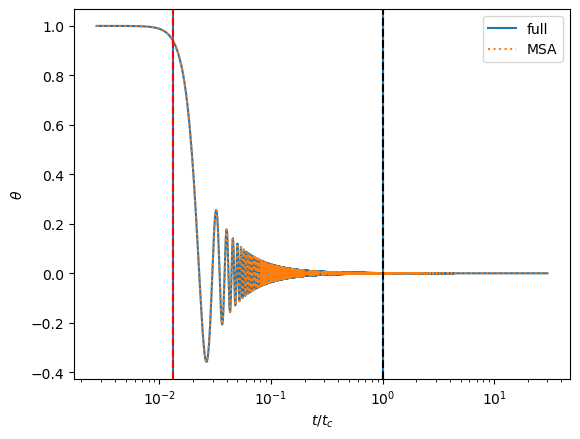

In [209]:
plt.plot(test_sol1.t_arr/tcrit, test_sol1.theta_arr, label='full')
plt.plot(test_sol2.t_arr/tcrit, test_sol2.theta_arr, ':', label='MSA')

plt.legend()
plt.xscale('log')
# plt.yscale('log')
# plt.xlim(1.e18, 6.e18)
plt.axvline(test_sol2.t_events[0]/tcrit)
plt.axvline(test_sol2.t_events[1]/tcrit)
plt.axvline(test_sol2.toscs[0]/tcrit, color='r', ls='--')
plt.axvline(1, color='k', ls='--')

plt.xlabel(r"$t/t_c$")
plt.ylabel(r"$\theta$")

Text(0, 0.5, '$\\rho_a$')

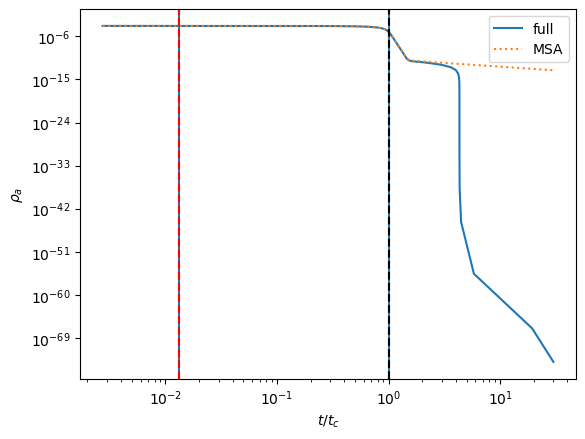

In [210]:
plt.plot(test_sol1.t_arr/tcrit, test_sol1.rho_arr, label='full')
plt.plot(test_sol2.t_arr/tcrit, test_sol2.rho_arr, ':', label='MSA')

plt.legend()
plt.xscale('log')
plt.yscale('log')
# plt.xlim(1.e18, 6.e18)
plt.axvline(test_sol2.t_events[0]/tcrit)
plt.axvline(test_sol2.t_events[1]/tcrit)
plt.axvline(test_sol2.toscs[0]/tcrit, color='r', ls='--')
plt.axvline(1, color='k', ls='--')

plt.xlabel(r"$t/t_c$")
plt.ylabel(r"$\rho_a$")

/tmp/ipykernel_13820/3530475371.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-0.1, 0.1)


Text(0, 0.5, '$\\theta$')

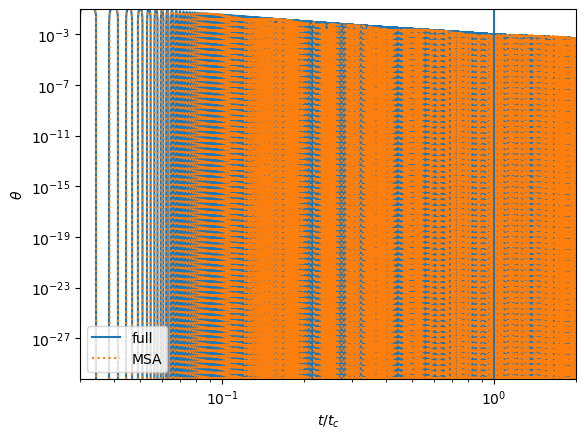

In [211]:
plt.plot(test_sol1.t_arr/tcrit, test_sol1.theta_arr, label='full')
plt.plot(test_sol2.t_arr/tcrit, test_sol2.theta_arr, ':', label='MSA')

plt.legend()
plt.xscale('log')
plt.yscale('log')
# plt.xlim(0.1, 2)
# plt.ylim(-0.01, 0.01)
plt.ylim(-0.1, 0.1)
plt.xlim(0.03, 2)
plt.axvline(test_sol2.msa_t_ini[-1]/tcrit, color='gray')
plt.axvline(test_sol2.t_events[0]/tcrit)
plt.axvline(test_sol2.t_events[1]/tcrit)

plt.xlabel(r"$t/t_c$")
plt.ylabel(r"$\theta$")

Text(0, 0.5, '$\\dot\\theta$')

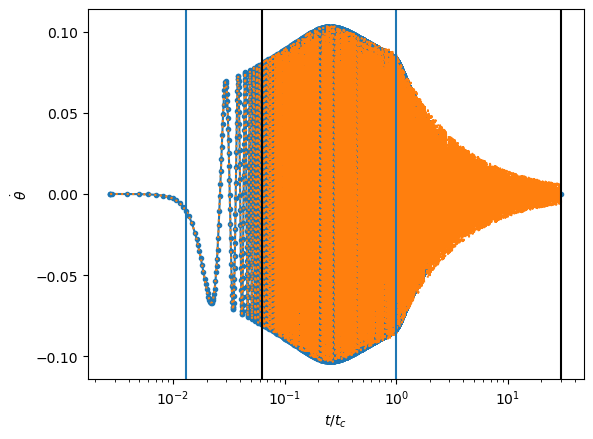

In [212]:
plt.plot(test_sol1.t_arr/tcrit, (test_sol1.dtheta_arr)/test_sol2.msa_ma_ini, marker='.', label='full')
plt.plot(test_sol2.t_arr/tcrit, (test_sol2.dtheta_arr)/test_sol2.msa_ma_ini, ls=':', label='MSA')
plt.xscale('log')
# plt.yscale('log')
# plt.xlim(9.e17, 1.2e18)#, plt.ylim(-0.2, 0.2)
# plt.xlim(2.e18, 3e18), plt.ylim(-0.2, 0.2)
plt.axvline(test_sol2.toscs[0]/tcrit)
plt.axvline(1)
plt.axvline(test_sol2.msa_t_ini/tcrit, color='k')
plt.axvline(test_sol2.msa_t_end/tcrit, color='k')

plt.xlabel(r"$t/t_c$")
plt.ylabel(r"$\dot\theta$")

Comparing energy densities

In [169]:
print(test_sol1.omega_a, test_sol2.omega_a)
print(test_sol2.omega_a_full/test_sol2.omega_a)

3.793754850215261e-56 0.12960410078472775
1.0073650842743194


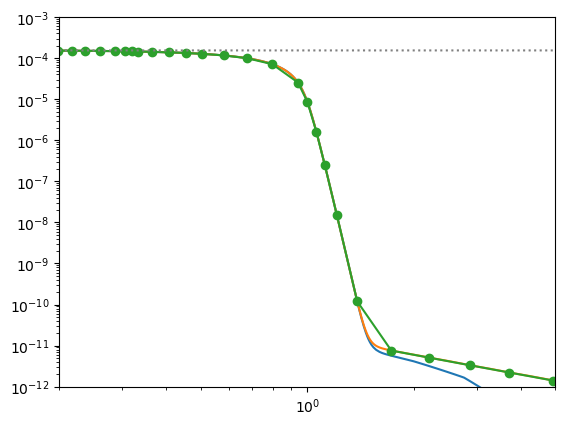

In [171]:
plt.plot(test_sol1.t_arr/tcrit, test_sol1.rho_arr, label='full')
plt.plot(test_sol2.t_arr/tcrit, test_sol2.rho_arr, label='MSA')
plt.plot(test_sol2.msa_t_arr[-1]/tcrit, test_sol2.msa_rho_arr[-1], marker='o', label='MSA, sparse')
plt.plot(test_sol2.t_arr/tcrit, np.ones_like(test_sol2.t_arr,)*(mpi*fpi)**2, ls=':', color='gray', label=r'$m_\pi^2 f_\pi^2$')
plt.xscale('log'), plt.yscale('log')
plt.xlim(0.2, 5)
plt.ylim(1.e-12, 1.e-3);

In [172]:
rho_test1, ke_test1, pe_test1 = axion_density(test_sol1.t_arr, [test_sol1.theta_arr, test_sol1.dtheta_arr], test_sol1.model, 'full', test_sol1.fa, test_sol1.eps_phi, test_sol1.N, None, debug=True) # axion energy density

In [173]:
rho_test2, ke_test2, pe_test2 = axion_density(test_sol2.t_arr, [test_sol2.theta_arr, test_sol2.dtheta_arr], test_sol2.model, 'full', test_sol2.fa, test_sol2.eps_phi, test_sol2.N, None, debug=True) # axion energy density

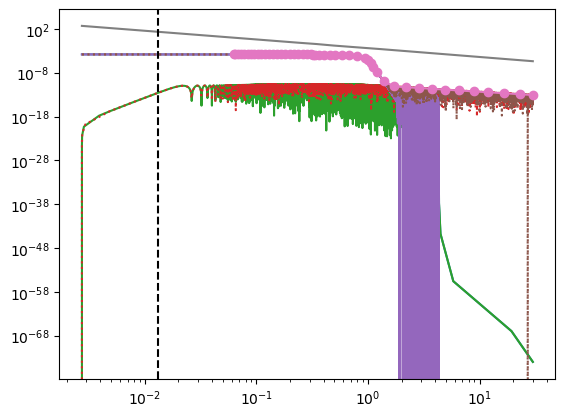

In [176]:
plt.plot(test_sol1.t_arr/tcrit, rho_rad(gs_fn(T_fn(test_sol1.t_arr)), T_fn(test_sol1.t_arr)), color='grey')
plt.plot(test_sol1.t_arr/tcrit, rho_test1)
plt.plot(test_sol2.t_arr/tcrit, rho_test2, ls=':')
plt.plot(test_sol1.t_arr/tcrit, ke_test1)
plt.plot(test_sol2.t_arr/tcrit, ke_test2, ls=':')
plt.plot(test_sol1.t_arr/tcrit, pe_test1)
plt.plot(test_sol2.t_arr/tcrit, pe_test2, ls=':')
plt.plot(test_sol2.msa_t_arr[-1]/tcrit, test_sol2.msa_rho_arr[-1], marker='o')
plt.xscale('log'), plt.yscale('log');
plt.axvline(test_sol1.toscs[0]/tcrit, color='k', ls='--')
# plt.xlim(0.04,0.1)

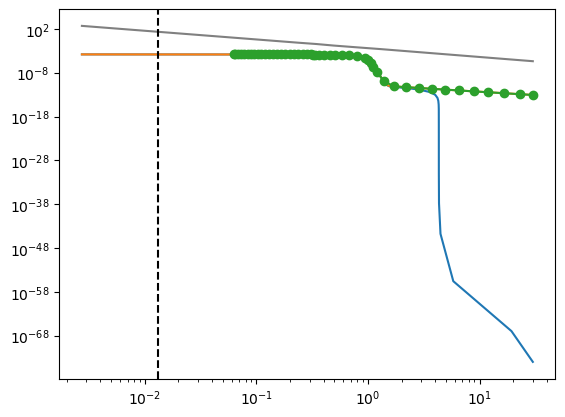

In [177]:
plt.plot(test_sol2.t_arr/tcrit, rho_rad(gs_fn(T_fn(test_sol2.t_arr)), T_fn(test_sol2.t_arr)), color='grey')
plt.plot(test_sol1.t_arr/tcrit, rho_test1)
plt.plot(test_sol2.t_arr/tcrit, rho_test2)
plt.plot(test_sol2.msa_t_arr[-1]/tcrit, test_sol2.msa_rho_arr[-1], marker='o')
plt.xscale('log'), plt.yscale('log');
plt.axvline(test_sol2.toscs[0]/tcrit, color='k', ls='--')
# plt.xlim(0.04,0.1)

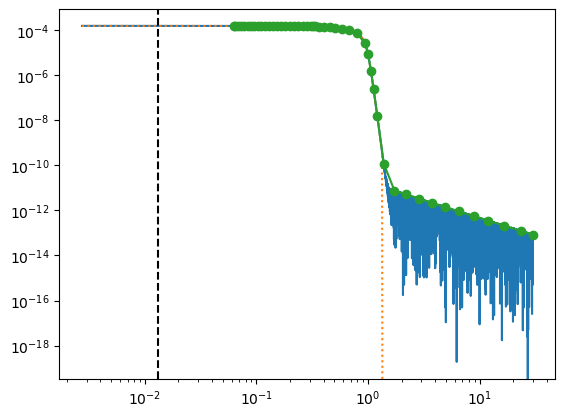

In [144]:
plt.plot(test_sol1.t_arr/tcrit, pe_test1)
plt.plot(test_sol2.t_arr/tcrit, pe_test2, ls=':')
plt.plot(test_sol1.msa_t_arr[-1]/tcrit, test_sol1.msa_rho_arr[-1], marker='o')
plt.xscale('log'), plt.yscale('log');
plt.axvline(test_sol1.toscs[0]/tcrit, color='k', ls='--')
# plt.xlim(0.04,0.1)

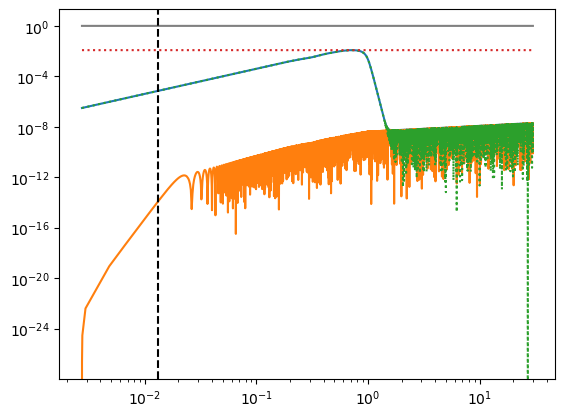

In [178]:
largest_rho_a = np.max(rho_test2/rho_rad(gs_fn(T_fn(test_sol2.t_arr)), T_fn(test_sol2.t_arr)))

plt.plot(test_sol2.t_arr/tcrit, np.ones_like(test_sol2.t_arr), color='grey')
plt.plot(test_sol2.t_arr/tcrit, rho_test2/rho_rad(gs_fn(T_fn(test_sol2.t_arr)), T_fn(test_sol2.t_arr)))
plt.plot(test_sol2.t_arr/tcrit, ke_test2/rho_rad(gs_fn(T_fn(test_sol2.t_arr)), T_fn(test_sol2.t_arr)))
plt.plot(test_sol2.t_arr/tcrit, pe_test2/rho_rad(gs_fn(T_fn(test_sol2.t_arr)), T_fn(test_sol2.t_arr)), ls=':')
plt.plot(test_sol2.t_arr/tcrit, largest_rho_a*np.ones_like(test_sol2.t_arr), ls=':')
plt.xscale('log'), plt.yscale('log');
plt.axvline(test_sol2.toscs[0]/tcrit, color='k', ls='--')
# plt.xlim(0.04,0.1)

In [179]:
del fa_test, epsphi_test, N_test, test_sol1, test_sol2, rho_test1, rho_test2, pe_test1, pe_test2, ke_test1, ke_test2

#### 3.5.b $\mathbb{Z}_N$-axion

Defining the parameters:

In [294]:
fa_test = (3.e13)*GeV # axion decay constant
epsphi_test = 1.e-5 # suppression in axion mass squared
N_test = np.inf # number of SM copies

In [295]:
test_sol1 = solve_axion_eom('ZN', 'brute', fa_test, epsphi_test, N_test, theta_ini, dtheta_ini, (0.01, 100), method='Radau', atol=1.e-8, rtol=1.e-7, vectorized=True, verbose=True)

*********************************

**** Model=ZN, Strategy=brute ****

*********************************

Defining important timescales:
.... t_ini/tcrit = 1.3626859368776177e-06
.... t_osc[0]/tcrit = 0.00013627060713621846
.... t_end/tcrit = 30.0
 -> Events:
.... xevents = [2.8862954e-03 2.1180616e+01]
.... tevents =  [4.74187897e+15 3.47975185e+19]
 -> Solving EOM.
.... Done!
 -> Computing axion events.
 -> Computing energy density and abundance.


In [296]:
test_sol2 = solve_axion_eom('ZN', 'switcheroo', fa_test, epsphi_test, N_test, theta_ini, dtheta_ini, (0.01, 100), method='Radau', atol=1.e-8, rtol=1.e-7, vectorized=True, verbose=True, dense_MSA=5001)

*********************************

**** Model=ZN, Strategy=switcheroo ****

*********************************

Defining important timescales:
.... t_ini/tcrit = 1.3626859368776177e-06
.... t_osc[0]/tcrit = 0.00013627060713621846
.... t_end/tcrit = 30.0
**** EOM-MSA1-EOM-MSA2 ****
(1) EOM
 -> Solving EOM.
.... Done!
(2) MSA
 -> Important quantities:
.... vev_MSA = 3.141592653589793
.... msa_ma_ini = 3.1751461404866305e-16
.... ma_fn(time_arr[-1]) = nan
.... ma = 6.08681794851504e-19
.... [A0i, phi0i] = [0.06447480176061605, -1.645337173666766]
.... testing msa_ic:  [0.0, 0.0]
 -> Solving MSA.
.... Done!
 -> Results:
.... msa_t_arr = [4.76376607e+17 4.79541721e+17 4.97496633e+17 5.15451546e+17
 5.33406458e+17 5.51361370e+17 5.69316282e+17 5.87271194e+17
 6.09516839e+17 6.31762483e+17 6.54008128e+17 6.76253773e+17
 6.98499417e+17 7.25515163e+17 7.52530908e+17 7.79546654e+17
 8.06562400e+17 8.33578145e+17 8.66561856e+17 8.99545567e+17
 9.32529279e+17 9.65512990e+17 9.98496701e+17 1.0389849

/tmp/ipykernel_13820/3421709655.py:1089: RuntimeWarning: invalid value encountered in sqrt
  ma_fn = lambda t: np.sqrt(Vtot_primeprime(vev_MSA1, T_fn(t), sol.model, sol.eps_phi, sol.N, p=p, small=small))/sol.fa


.... t_arr just before MSA = 4.763766070582994e+17
.... first two msa times: msa_t_arr[:2] = [4.76376607e+17 4.79541721e+17]
 -> msa_fast_arr = [0.00000000e+00 1.00496996e+00 6.70591686e+00 1.24068636e+01
 1.81078101e+01 2.38087564e+01 2.95097024e+01 3.52106482e+01
 4.22739635e+01 4.93372783e+01 5.64005926e+01 6.34639062e+01
 7.05272192e+01 7.91051070e+01 8.76829936e+01 9.62608788e+01
 1.04838763e+02 1.13416645e+02 1.23889438e+02 1.34362228e+02
 1.44835015e+02 1.55307798e+02 1.65780577e+02 1.78636129e+02
 1.91154184e+02 2.03672231e+02 2.16190269e+02 2.31362667e+02
 2.46535048e+02 2.61707411e+02 2.74158516e+02 2.86609605e+02
 2.99060678e+02 3.18302000e+02 3.37543274e+02 3.56784495e+02
 3.76025657e+02 3.95266753e+02 4.19202432e+02 4.43137983e+02
 4.67073390e+02 4.91008635e+02 5.19812806e+02 5.48012139e+02
 5.76211153e+02 6.04409809e+02 6.39102872e+02 6.73795246e+02
 7.08486843e+02 7.43177563e+02 7.85338743e+02 8.27498268e+02
 8.69655915e+02 9.11811441e+02 9.63354449e+02 1.01489338e+03
 1

/tmp/ipykernel_13820/1928970243.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(3+re_center,3.3+re_center)


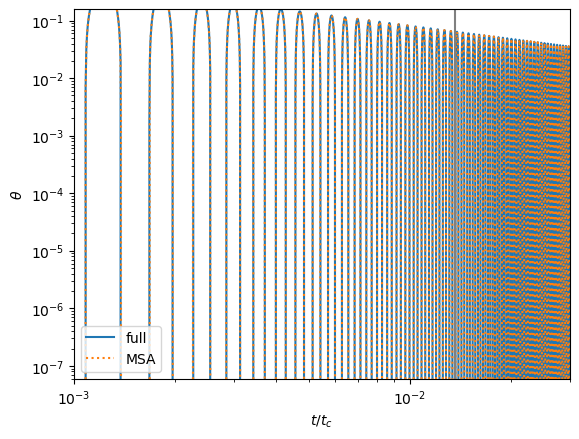

In [297]:
minus_pi = True

if minus_pi:
    re_center = -pi
else:
    re_center = 0

plt.plot(test_sol1.t_arr/tcrit, test_sol1.theta_arr + re_center, label='full')
plt.plot(test_sol2.t_arr/tcrit, test_sol2.theta_arr + re_center, ls=':', label='MSA')

plt.legend()
plt.xscale('log')
plt.yscale('log')

# zooming in to first oscillatory stage
plt.xlim(0.001, 0.03)
plt.ylim(3+re_center,3.3+re_center)

# # zooming in to second oscillatory stage
# plt.xlim(10, 50)
# plt.ylim(-0.6, 0.6)

plt.axvline(1, color='k', ls='-', lw=2)
# plt.axvline(test_sol.t_events[0]/tcrit)
# plt.axvline(test_sol.t_events[1]/tcrit)

for i in range(len(test_sol2.msa_t_ini)):
    plt.axvline(test_sol2.msa_t_ini[i]/tcrit, color='gray')
    plt.axvline(test_sol2.msa_t_end[i]/tcrit, color='gray')

plt.axvline(test_sol2.toscs[0]/tcrit, color='r', ls='--', lw=2)
plt.axvline(test_sol2.toscs[1]/tcrit, color='g', ls=':', lw=2)

plt.axhline(1, color='k', ls=':')
plt.axhline(pi, color='k', ls=':')
vev_over_pi = int(np.floor(test_sol2.theta_arr[-1]/pi))
plt.axhline(vev_over_pi*pi, color='k', ls=':')

plt.xlabel(r"$t/t_c$")
plt.ylabel(r"$\theta$")

del minus_pi, re_center

Clearing definitions

In [ ]:
# del fa_test, epsphi_test, N_test, test_sol1, test_sol2, rho_test1, rho_test2, pe_test1, pe_test2, ke_test1, ke_test2

## 4. **----->TODO**: MCMC Analysis

- Define routine function from beginning to end, taking parameters as inputs, defining xini and xend (integration interval), solving eom, computing omega_dm, and performing MCMC analysis in parallel in cores, with blobs for derived parameters

### 4.1 Defining common log-likelihoods and log-priors

The logarithm of a flat probability:

In [714]:
def ln_flat_prob(par, bounds):
    """
    ln_flat_prob : a flat log-likelihood for a given parameter.

    Parameters:
    par : parameter value
    bounds : upper and lower bounds on the parameter (tuple)

    Returns:
    ln_flat_prob
    """
    
    if bounds[0] < par < bounds[1]:
        return 0
    else:
        return -np.inf

The logarithm of a Gaussian probability:

In [715]:
def ln_gauss_prob(par, mean, sigma):
    """
    ln_gauss_prob : a Gaussian log-likelihood for a given parameter.

    Parameters:
    par : parameter value
    mean : mean value
    sigma : standard deviation

    Returns:
    ln_gauss_prob
    """
    
    chi2 = (par - mean)**2 / sigma**2
    
    return -0.5*chi2

### 4.2 Routine

In [716]:
# solve_axion_eom('QCD', fa_test, epsphi_test, N_test, theta_ini, dtheta_ini, x_span, p=8, small=1.e-10, time_units='tcrit', method='Radau', atol=1.e-4, rtol=1.e-3) # solving QCD axion EOM w/ Radau method and x = t/tcrit

Order of parameters:

QCD model: `X = [thetai, logfa]`

$\mathbb{Z}_N$ model: `X = [thetai, logfa, logephi]`

In [721]:
def log_lkl_dm(X, model, mean_dm=(Omega_dm*h*h), sigma_dm=sig_omega_dm, **kwargs):
    """
    """

    if (model == 'QCD'):
        if (len(X) != 2):
            raise ValueError("For model='QCD' there are two (2) parameters: [thetai, logfa]. Instead, you have len(X)={0}, with X={1}".format(len(X), X))
        else:
            thetai, logfa = X
            eps_phi = 1 # it doesn't matter, since in the QCD model it plays no role
    
    elif (model == 'ZN'):
        if (len(X) != 3):
            raise ValueError("For model='ZN' there are three (3) parameters: [thetai, logfa, eps_phi]. Instead, you have len(X)={0}, with X={1}".format(len(X), X))
        else:
            thetai, logfa, logephi = X
            fa = 10**logfa
            eps_phi = 10**logephi

    else:
        raise ValueError("The argument 'model' can only be either 'QCD' or 'ZN', and 'X' can only have len(X)=2 or 3, respectively. Instead, you have 'model'={0}, and len(X)={1}, with X={2}".format(model, len(X), X))

    # defining the default values of the parameters 'N' and 'dy0'
    default_fixed = {'N':np.inf, 'dy0':0, 'ini_factor':0.003, 'end_factor':100}
    # finding if these parameters are given already in kwargs
    fixed_model_params = {key : kwargs[key] if (key in kwargs.keys()) else default_fixed[key] for key in ['N', 'dy0', 'ini_factor', 'end_factor']}

    # defining all other hyperparameters
    hyper_params = {k : val for k, val in kwargs.items() if not (k in ['N', 'dy0', 'ini_factor', 'end_factor'])}

    # dimless integration interval
    x_interval = find_x_interval(model,
                                 fa,
                                 eps_phi,
                                 fixed_model_params['ini_factor'],
                                 fixed_model_params['end_factor'])

    # dimless oscillation time (second-stage for 'ZN')
    x_osc = find_x_interval(model, fa, eps_phi, 1, 1)[1]
    
    # solving axion EOM
    sol = solve_axion_eom(model,
                          fa,
                          eps_phi,
                          fixed_model_params['N'],
                          thetai,
                          fixed_model_params['dy0'],
                          x_interval,
                          **hyper_params
                         )

    # arrays from solution
    x_arr = sol.t # time array
    theta_arr = sol.y[0] # axion angle array
    dtheta_arr = sol.y[1] # axion angular velocity array
    
    # energy density
    rho_arr = (tcrit/fa)**2 * axion_density(x_arr, (theta_arr, dtheta_arr), model, fa, eps_phi, fixed_model_params['N'])

    # axion abundance
    omega_a = axion_abundance(rho_arr, x_arr, x_osc)

    print(omega_a)

    ln_lkl = ln_gauss_prob(omega_a, mean_dm, sigma_dm)

    return ln_lkl

In [732]:
log_lkl_dm([1.e-4, 14, -10], 'ZN', time_units='1/maxion', method='Radau')

xend= 7413.670361147481
xini= 1597.226860651734 xini_idx= 5547
last third= 0.6666666666666666
norm_rhoa3= [1.04051745 1.02220111 1.00431661 0.99510916 1.00022385 1.025164
 1.03827086 1.0220245  1.00495793 0.99659827 1.00250966 1.02578589
 1.03606759 1.01961576 1.00602304 0.9982991  1.00038803 1.02034782
 1.03455366 1.02365719 1.00686377 0.9989218  1.00663934 1.02679276
 1.03195052 1.01535793 1.00279267 1.00047853 1.00993188 1.02815914
 1.02915616 1.01190695 1.0018563  1.00221512 1.01251247 1.02858252
 1.02648242 1.00627727 1.00399906 1.01996284 1.02922897 1.01915434
 1.00677175 1.00160027 1.00779178 1.02347685 1.02718694 1.01397624
 1.00317101 1.00447915 1.01630363 1.02635161 1.02193377 1.00664409
 1.00358925 1.01699036 1.02623489 1.01738843 1.00681195 1.00259727
 1.00815041 1.02157351 1.02437074 1.01277912 1.00593993 1.00282015
 1.00479984 1.01705221 1.02454396 1.01688442 1.00687178 1.00300523
 1.00861811 1.02077561 1.02255985 1.01158049 1.00580423 1.00312071
 1.00458681 1.01558904 1.

-5.179046554250926e+21

### 4.3 Analysis

#### 4.3.a Setup

In [ ]:
np.random.seed(42)

In [ ]:
ndim = #
nwalkers = #
p0 = np.random.rand(nwalkers, ndim)